In [230]:
!pip install gym
!pip install hiive.mdptoolbox
!pip install tqdm

import itertools
from tqdm import tqdm
import gym
import hiive.mdptoolbox as mdptoolbox
from hiive.mdptoolbox.mdp import ValueIteration, PolicyIteration, QLearning
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output, display

# suppress pandas warning
pd.options.mode.chained_assignment = None

# set seed
np.random.seed(0)

%matplotlib inline

In [231]:
colors = {
    b'S': 'b',
    b'F': 'w',
    b'H': 'k',
    b'G': 'g'
}

directions = {
            0: '←',
            1: '↓',
            2: '→',
            3: '↑'
}

def plot_lake(env, policy=None, title='Frozen Lake'):
    squares = env.nrow
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111, xlim=(-.01, squares+0.01), ylim=(-.01, squares+0.01))
    plt.title(title, fontsize=16, weight='bold', y=1.01)
    for i in range(squares):
        for j in range(squares):
            y = squares - i - 1
            x = j
            p = plt.Rectangle([x, y], 1, 1, linewidth=1, edgecolor='k')
            p.set_facecolor(colors[env.desc[i,j]])
            ax.add_patch(p)
            
            if policy is not None:
                text = ax.text(x+0.5, y+0.5, directions[policy[i, j]],
                               horizontalalignment='center', size=25, verticalalignment='center',
                               color='k')
            
#     plt.axis('off')
#     plt.savefig('./frozen/' + title + '.png', dpi=400)

In [232]:
def get_score(env, policy, printInfo=False, episodes=1000):
    misses = 0
    steps_list = []
    for episode in range(episodes):
        observation = env.reset()
        steps=0
        while True:
            action = policy[observation]
            observation, reward, done, _ = env.step(action)
            steps+=1
            if done and reward == 1:
                # print('You have got the Frisbee after {} steps'.format(steps))
                steps_list.append(steps)
                break
            elif done and reward == 0:
                # print("You fell in a hole!")
                misses += 1
                break
    ave_steps = np.mean(steps_list)
    std_steps = np.std(steps_list)
    pct_fail  = (misses/episodes)* 100
    
    if (printInfo):
        print('----------------------------------------------')
        print('You took an average of {:.0f} steps to get the frisbee'.format(ave_steps))
        print('And you fell in the hole {:.2f} % of the times'.format(pct_fail))
        print('----------------------------------------------')
  
    return ave_steps, std_steps, pct_fail

In [233]:
# def get_policy(env,stateValue, lmbda=0.9):
#     policy = [0 for i in range(env.nS)]
#     for state in range(env.nS):
#         action_values = []
#         for action in range(env.nA):
#             action_value = 0
#             for i in range(len(env.P[state][action])):
#                 prob, next_state, r, _ = env.P[state][action][i]
#                 action_value += prob * (r + lmbda * stateValue[next_state])
#             action_values.append(action_value)
#         best_action = np.argmax(np.asarray(action_values))
#         policy[state] = best_action
#     return policy 

In [ ]:
size = 4 # or 8 but may take very long for VI to converge

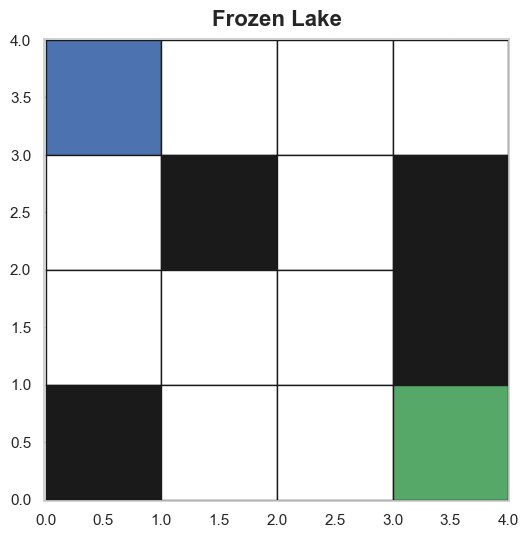

In [521]:
size = 4 # or 8
if size == 4:
    frozen_map_size = "4x4"
elif size == 8:
    frozen_map_size = "8x8"
else:
    raise Exception('map size needs to be either 4 or 8')

env = gym.make('FrozenLake-v1', map_name= frozen_map_size).unwrapped

env.max_episode_steps=250

# Create transition and reward matrices from OpenAI P matrix
rows = env.nrow
cols = env.ncol
T = np.zeros((4, rows*cols, rows*cols))
R = np.zeros((4, rows*cols, rows*cols))

old_state = np.inf

for square in env.P:
    for action in env.P[square]:
        for i in range(len(env.P[square][action])):
            new_state = env.P[square][action][i][1]
            if new_state == old_state:
                T[action][square][env.P[square][action][i][1]] = T[action][square][old_state] + env.P[square][action][i][0]
                R[action][square][env.P[square][action][i][1]] = R[action][square][old_state] + env.P[square][action][i][2]
            else:
                T[action][square][env.P[square][action][i][1]] = env.P[square][action][i][0]
                R[action][square][env.P[square][action][i][1]] = env.P[square][action][i][2]
            old_state = env.P[square][action][i][1]
            
#print(T)
#print(R)
plot_lake(env)

In [489]:
def run_value_iteration(t, r, gamma, epsilon, max_iterations):
    test = ValueIteration(t, r, gamma=gamma, epsilon=epsilon, max_iter=max_iterations)
    runs = test.run()
    policy = test.policy
    return runs, policy

def get_policy_stats(data, policy, env, showResults=False):
    policies = data['policy']
    #print(f'policies:{policies}' )
    data['average_steps'], data['steps_stddev'], data['success_pct'] = 0, 0, 0
    
    for i,p in enumerate(policies):
        try:
            pol = list(p)[0]
            steps, steps_stddev, failures = get_score(env, pol, showResults)
        except:
            pol = None
            steps, steps_stddev, failures = 250, 0, 100
        data['average_steps'][i] = steps
        data['steps_stddev'][i]  = steps_stddev
        data['success_pct'][i]   = 100-failures 
    return data

def valueIterationz(t, r, gammas, epsilons, showResults=False, max_iterations=100000):
    t0 = time.time()
    
    # create data structure to save off
    columns = ['gamma', 'epsilon', 'time', 'iterations', 'reward', 'policy', 'mean_rewards', 'max_rewards', 'error']
    data = pd.DataFrame(0.0, index=np.arange(len(gammas)*len(epsilons)), columns=columns)
    
#     print('Gamma,\tEps,\tTime,\tIter,\tReward')
#     print(100*'+')
    
    testNum = 0
    for g in gammas:
        for e in epsilons:
            runs, test_policy = run_value_iteration(t, r, g, e, max_iterations)
            
            Time = runs[-1]['Time']
            iters = runs[-1]['Iteration']
            maxR = runs[-1]['Max V']
            max_rewards, mean_rewards, errors = [], [], []
            max_rewards = [run['Max V'] for run in runs]
            mean_rewards = [run['Mean V'] for run in runs]
            errors = [run['Error'] for run in runs]
                
            policy = np.array(test_policy)
            policy = policy.reshape(size,size)
            
            data.loc[testNum, ['gamma', 'epsilon', 'time', 'iterations', 'reward', 'mean_rewards', 'max_rewards', 'error', 'policy']] = g, e, Time, iters, maxR, {tuple(mean_rewards)}, {tuple(max_rewards)}, {tuple(errors)}, {test_policy}         
            print('%.2f,\t%.0E,\t%.2f,\t%d,\t%f' % (g, e, Time, iters, maxR))
            
            testNum += 1
                
    endTime = time.time() - t0
    print("Time taken: %.2f" %endTime)
    
    data = get_policy_stats(data, policy, env, showResults)
    
    # replace all NaN's
    data.fillna(0, inplace=True)
    
    return data


In [467]:
gammas   = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99]
epsilons = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1] #[1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 1e-10]
vi_data  = valueIterationz(T, R, gammas, epsilons, showResults=False)

interest = ['gamma', 'epsilon', 'time', 'iterations', 'reward']
df = vi_data[interest]

0.10,	1E-02,	0.00,	1,	0.333333
0.10,	2E-02,	0.00,	1,	0.333333
0.10,	3E-02,	0.00,	1,	0.333333
0.10,	4E-02,	0.00,	1,	0.333333
0.10,	5E-02,	0.00,	1,	0.333333
0.10,	6E-02,	0.00,	1,	0.333333
0.10,	7E-02,	0.00,	1,	0.333333
0.10,	8E-02,	0.00,	1,	0.333333
0.10,	9E-02,	0.00,	1,	0.333333
0.10,	1E-01,	0.00,	1,	0.333333
0.20,	1E-02,	0.00,	2,	0.355556
0.20,	2E-02,	0.00,	1,	0.333333
0.20,	3E-02,	0.00,	1,	0.333333
0.20,	4E-02,	0.00,	1,	0.333333
0.20,	5E-02,	0.00,	1,	0.333333
0.20,	6E-02,	0.00,	1,	0.333333
0.20,	7E-02,	0.00,	1,	0.333333
0.20,	8E-02,	0.00,	1,	0.333333
0.20,	9E-02,	0.00,	1,	0.333333
0.20,	1E-01,	0.00,	1,	0.333333
0.30,	1E-02,	0.00,	3,	0.373333
0.30,	2E-02,	0.00,	2,	0.366667
0.30,	3E-02,	0.00,	2,	0.366667
0.30,	4E-02,	0.00,	2,	0.366667
0.30,	5E-02,	0.00,	1,	0.333333
0.30,	6E-02,	0.00,	1,	0.333333
0.30,	7E-02,	0.00,	1,	0.333333
0.30,	8E-02,	0.00,	1,	0.333333
0.30,	9E-02,	0.00,	1,	0.333333
0.30,	1E-01,	0.00,	1,	0.333333
0.40,	1E-02,	0.00,	3,	0.389630
0.40,	2E-02,	0.00,	3,	0.389630
0.40,	3E

/Users/LouisReinaldo/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/LouisReinaldo/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/LouisReinaldo/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/LouisReinaldo/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/LouisReinaldo/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [468]:
def plot_performance(results_df, values, performance_col, x_axis_name, title):
    x = values
    y = []
    for g in values:
        y.append(results_df.loc[values == g][performance_col].mean())
    sns.set(style="whitegrid")
    fig = plt.figure(figsize=(6,4))
    ax = sns.lineplot(x=x, y=y)
    ax.set_title(title)
    ax.set_xlabel(x_axis_name)
    ax.set_ylabel(performance_col)
    plt.show()

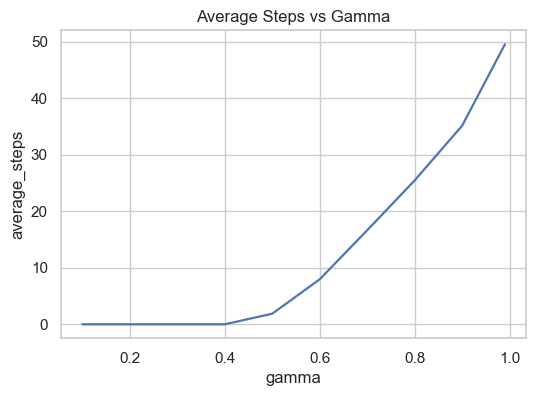

In [469]:
plot_performance(vi_data,vi_data['gamma'], 'average_steps', 'gamma', 'Average Steps vs Gamma')

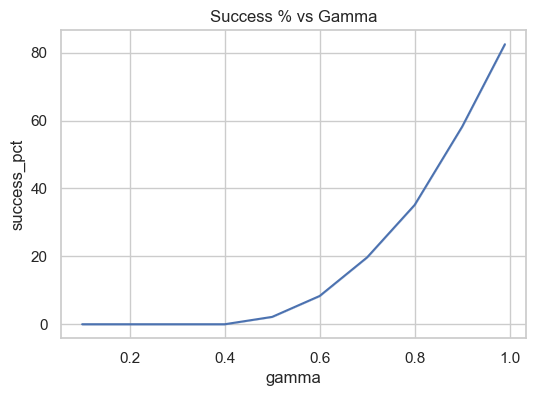

In [470]:
plot_performance(vi_data,vi_data['gamma'], 'success_pct', 'gamma', 'Success % vs Gamma')

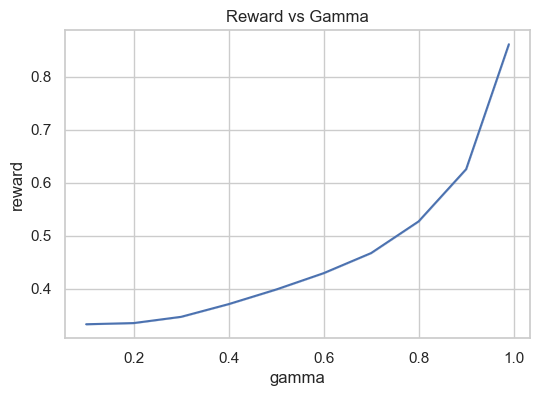

In [471]:
plot_performance(vi_data,vi_data['gamma'], 'reward', 'gamma', 'Reward vs Gamma')

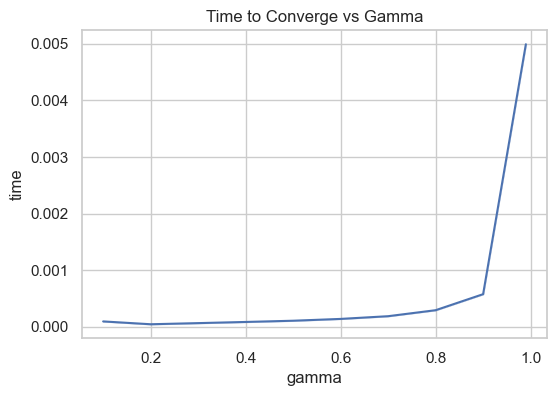

In [472]:
plot_performance(vi_data,vi_data['gamma'], 'time', 'gamma', 'Time to Converge vs Gamma')

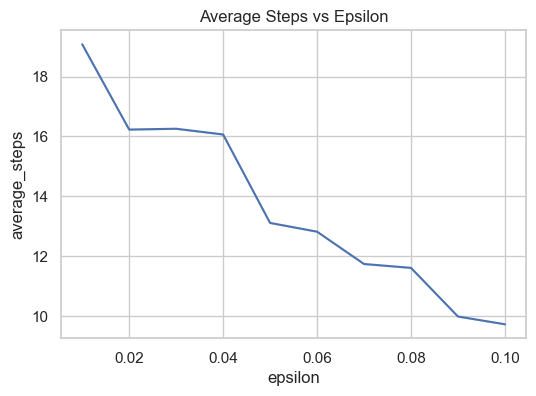

In [473]:
plot_performance(vi_data,vi_data['epsilon'], 'average_steps', 'epsilon', 'Average Steps vs Epsilon')

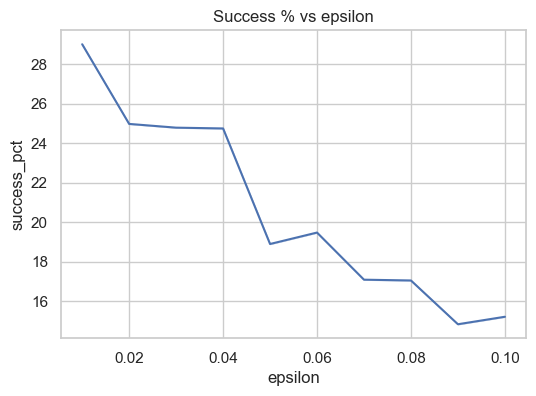

In [474]:
plot_performance(vi_data,vi_data['epsilon'], 'success_pct', 'epsilon', 'Success % vs epsilon')

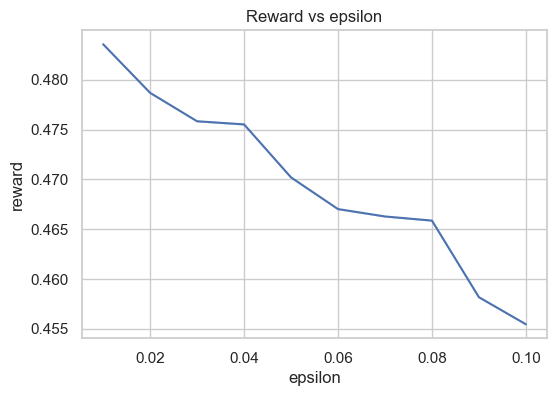

In [475]:
plot_performance(vi_data,vi_data['epsilon'], 'reward', 'epsilon', 'Reward vs epsilon')

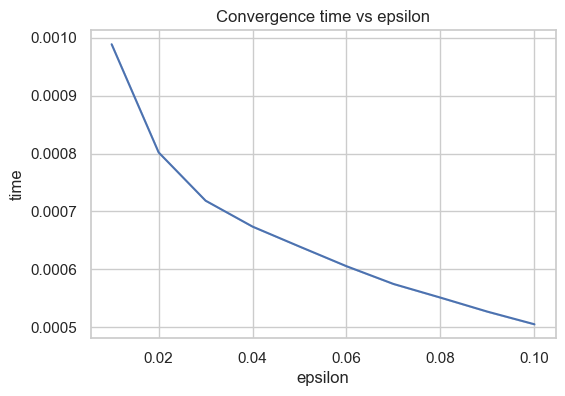

In [476]:
plot_performance(vi_data,vi_data['epsilon'], 'time', 'epsilon', 'Convergence time vs epsilon')

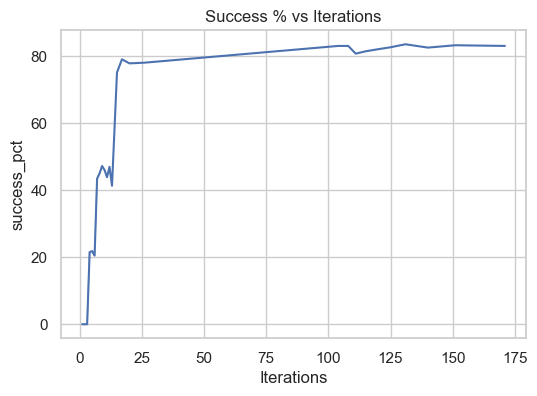

In [477]:
plot_performance(vi_data, vi_data['iterations'], 'success_pct', 'Iterations', 'Success % vs Iterations')

In [478]:
def plot_best_policy(results_df, env, rows, cols, env_name = 'Frozen Lake: ' + frozen_map_size, mdp_algo = 'VI'):
    best_run = results_df['success_pct'].idxmax()
    best_policy = np.array(list(results_df['policy'][best_run]))[0].reshape(rows, cols)
    if mdp_algo == 'VI':
        title = env_name + ' ' + mdp_algo  + ' Optimal Policy (Success = {:.2f}, Gamma = {:.2f}, Epsilon = {})'.format(results_df['success_pct'][best_run], results_df['gamma'][best_run], results_df['epsilon'][best_run])
    elif mdp_algo == 'PI':
        title = env_name + ' ' + mdp_algo + ' Optimal Policy (Success = {:.2f}, Gamma = {:.2f})'.format(results_df['success_pct'][best_run], results_df['gamma'][best_run])
    elif mdp_algo == 'QL':
        title = env_name + ' ' + mdp_algo  + ' Best Result:\n\tSuccess = %.2f\n\tGamma = %.2f,\n\tAlpha = %.2f,\n\tAlpha Decay: %.3f,\n\tEpsilon Decay: %.3f,\n\tIterations: %.1E' % (results_df['success_pct'].max(), results_df['gamma'][best_run], results_df['alpha'][best_run], results_df['alpha_decay'][best_run], results_df['epsilon_decay'][best_run], results_df['iterations'][best_run])
    
    plot_lake(env, best_policy, title)

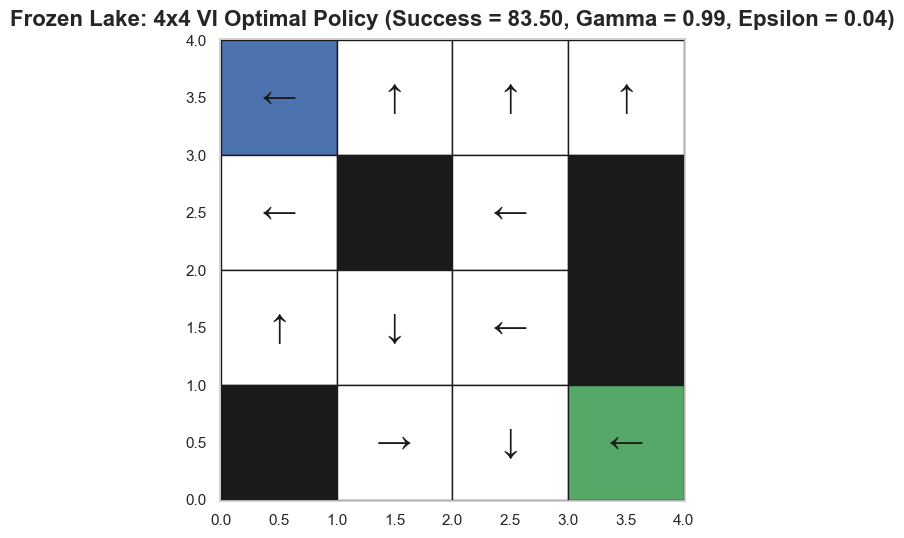

In [479]:
plot_best_policy(vi_data, env, size, size)

In [558]:
def get_policy_stats(data, policy, env, showResults=False):
    policies = data['policy']
    print(f'policies:{policies}')
    #print(f'policies:{policies}' )
    data['average_steps'], data['steps_stddev'], data['success_pct'] = 0, 0, 0
    
    for i,p in enumerate(policies):
        print(p)
        pol = list(p)[0]
        steps, steps_stddev, failures = get_score(env, pol, showResults)
        data['average_steps'][i] = steps
        data['steps_stddev'][i]  = steps_stddev
        data['success_pct'][i]   = 100-failures 
    return data



def run_policy_iteration(t, r, gamma, max_iterations = 100000, eval_type="matrix"):
    test =  PolicyIteration(t, r, gamma=gamma, max_iter=max_iterations, eval_type=eval_type)
    runs = test.run()
 #   policy = test.policy
    max_value  = runs[-1]['Max V']
#    print(r)#     print(test.iter)
#     print(runs[-1]['Iteration'])
    return runs, test.policy, test.time, test.iter, max_value



def policyIterationz(t, r, gammas, showResults=False, max_iterations=100000, eval_type="matrix", is_grid = True, tsize = 4):
    t0 = time.time()
    
    columns = ['gamma', 'time', 'iterations', 'reward', 'mean_rewards', 'max_rewards', 'error', 'policy']
    data = pd.DataFrame(0.0, index=np.arange(len(gammas)*len(epsilons)), columns=columns)
    
    testNum = 0
    for g in gammas:
        print(f'gamma:{g}')
        try:
            runs, test_policy, test_time, test_iterations, max_reward = run_policy_iteration(t, r, g, max_iterations, eval_type)
            print(f'policy:{test_policy}')
            max_rewards, mean_rewards, errors = [], [], []
            max_rewards = [run['Max V'] for run in runs]
            mean_rewards = [run['Mean V'] for run in runs]
            errors = [run['Error'] for run in runs]

            policy = np.array(test_policy)
            policy = policy.reshape(tsize,tsize)

            data.loc[testNum, columns] = g, test_time, test_iterations, max_reward, {tuple(mean_rewards)}, {tuple(max_rewards)}, {tuple(errors)}, {test_policy}         
            print('%.2f,\t%.2f,\t%d,\t%f' % (g, test_time, test_iterations, max_reward))
        except:
            print("error occured")
            pass
        testNum += 1
    #print(data)

    endTime = time.time() - t0
    print("Time taken: %.2f" %endTime)
    
    data = data[data['policy'] != 0]
    
    data = get_policy_stats(data, policy, env, showResults)
    
    # replace all NaN's
    data.fillna(0, inplace=True)
    
    return data

In [548]:
def policyIteration(t, r, gammas, showResults=False, max_iterations=100000):
    t0 = time.time()
    
    # create data structure to save off
    columns = ['gamma', 'epsilon', 'time', 'iterations', 'reward', 'average_steps', 'steps_stddev', 'success_pct', 'policy', 'mean_rewards', 'max_rewards', 'error']
    data = pd.DataFrame(0.0, index=np.arange(len(gammas)), columns=columns)
    
    print('gamma,\ttime,\titer,\treward')
    print(80*'_')
    
    testnum = 0
    for g in gammas:
        test = PolicyIteration(t, r, gamma=g, max_iter=max_iterations, eval_type="matrix") # eval_type="iterative"
        
        runs  = test.run()
        Time  = test.time
        iters = test.iter
        maxr  = runs[-1]['Max V']
                
        max_rewards, mean_rewards, errors = [], [], []
        for run in runs:
            max_rewards.append(run['Max V'])
            mean_rewards.append(run['Mean V'])
            errors.append(run['Error'])
            
        
        print(f'test policy:{test.policy}')
        policy = np.array(test.policy)
        policy = policy.reshape(4,4)
        
        data['gamma'][testnum]        = g
        data['time'][testnum]         = Time
        data['iterations'][testnum]   = iters
        data['reward'][testnum]       = maxr
        data['mean_rewards'][testnum] = {tuple(mean_rewards)}
        data['max_rewards'][testnum]  = {tuple(max_rewards)}
        data['error'][testnum]        = {tuple(errors)}
        data['policy'][testnum]       = {test.policy}
        
        print('%.2f,\t%.2f,\t%d,\t%f' % (g, Time, iters, maxr))
        
        if showResults:
            title = 'frozenlake_pi_' + str(rows) + 'x' + str(cols) + '_g' + str(g)
            plot_lake(env, policy, title)
        
        testnum = testnum + 1
            
    endTime = time.time() - t0
    print('Time taken: %.2f' % endTime)
    
    # see differences in policy
    policies = data['policy']
    print(f'policies:{policies}')
    
    for i,p in enumerate(policies):
        pol = list(p)[0]
        print(pol)
        steps, steps_stddev, failures = get_score(env, pol, showResults)
        data['average_steps'][i] = steps
        data['steps_stddev'][i]  = steps_stddev
        data['success_pct'][i]   = 100-failures      
        
    # replace all nan's
    data.fillna(0, inplace=True)
    data.head()
        
    return data

In [559]:
gammas   = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95]
pi_data  = policyIterationz(T, R, gammas, showResults=False, tsize = 4)

gamma:0.1
policy:(1, 3, 2, 3, 0, 0, 0, 0, 3, 1, 0, 0, 0, 2, 1, 0)
0.10,	0.01,	4,	0.345239
gamma:0.2
policy:(1, 3, 2, 3, 0, 0, 0, 0, 3, 1, 0, 0, 0, 2, 1, 0)
0.20,	0.00,	4,	0.358992
gamma:0.3
policy:(1, 3, 2, 3, 0, 0, 0, 0, 3, 1, 0, 0, 0, 2, 1, 0)
0.30,	0.00,	4,	0.375103
gamma:0.4
policy:(1, 3, 2, 3, 0, 0, 0, 0, 3, 1, 0, 0, 0, 2, 1, 0)
0.40,	0.00,	4,	0.394332
gamma:0.5
policy:(1, 3, 2, 3, 0, 0, 0, 0, 3, 1, 0, 0, 0, 2, 1, 0)
0.50,	0.00,	4,	0.417861
gamma:0.6
policy:(1, 3, 2, 3, 0, 0, 0, 0, 3, 1, 0, 0, 0, 2, 1, 0)
0.60,	0.00,	4,	0.447649
gamma:0.7
policy:(1, 3, 2, 3, 0, 0, 0, 0, 3, 1, 0, 0, 0, 2, 1, 0)
0.70,	0.00,	4,	0.487267
gamma:0.8
policy:(1, 3, 2, 3, 0, 0, 0, 0, 3, 1, 0, 0, 0, 2, 1, 0)
0.80,	0.00,	5,	0.544196
gamma:0.9
policy:(0, 3, 0, 3, 0, 0, 0, 0, 3, 1, 0, 0, 0, 2, 1, 0)
0.90,	0.00,	6,	0.639020
gamma:0.95
policy:(0, 3, 0, 3, 0, 0, 0, 0, 3, 1, 0, 0, 0, 2, 1, 0)
0.95,	0.00,	5,	0.723674
Time taken: 0.07
policies:0    {(1, 3, 2, 3, 0, 0, 0, 0, 3, 1, 0, 0, 0, 2, 1,...
1    {(1, 3, 2, 3,

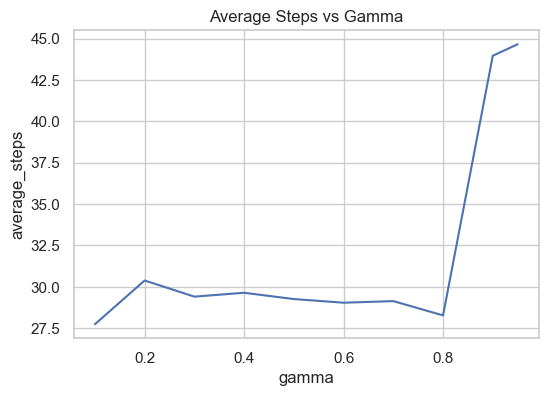

In [560]:
plot_performance(pi_data, pi_data['gamma'], 'average_steps', 'gamma', 'Average Steps vs Gamma')

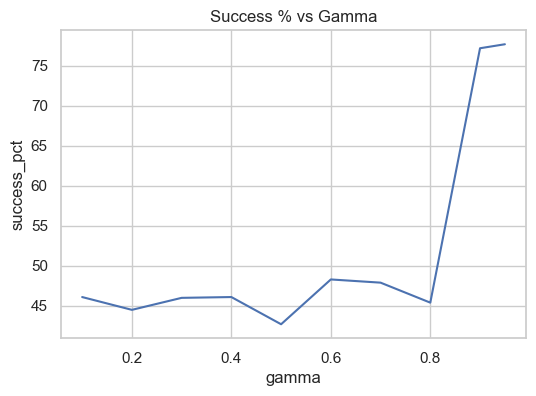

In [561]:
plot_performance(pi_data, pi_data['gamma'], 'success_pct', 'gamma', 'Success % vs Gamma')

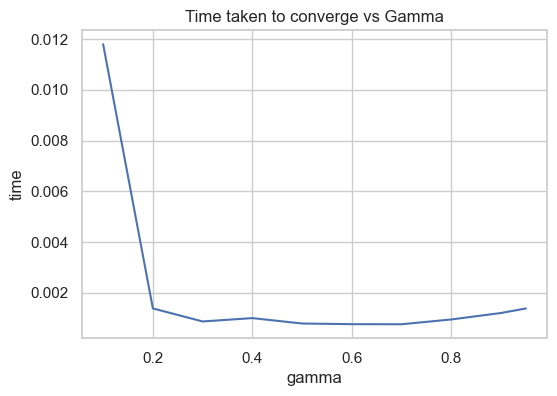

In [562]:
plot_performance(pi_data, pi_data['gamma'], 'time', 'gamma', 'Time taken to converge vs Gamma')

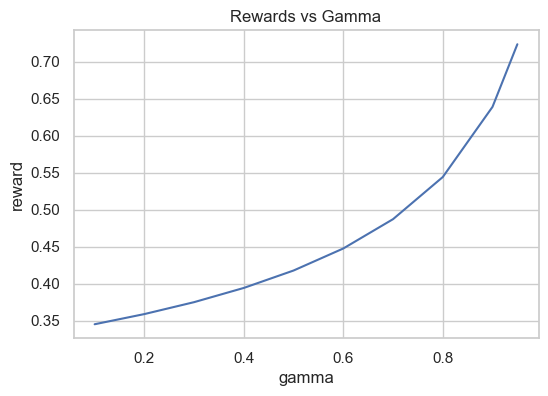

In [563]:
plot_performance(pi_data, pi_data['gamma'], 'reward', 'gamma', 'Rewards vs Gamma')

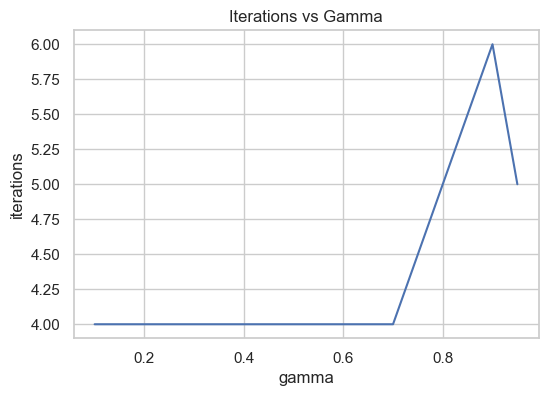

In [564]:
plot_performance(pi_data, pi_data['gamma'], 'iterations', 'gamma', 'Iterations vs Gamma')

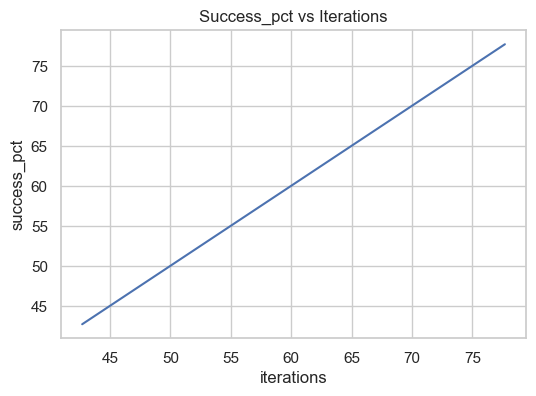

In [565]:
plot_performance(pi_data, pi_data['success_pct'], 'success_pct', 'iterations', 'Success_pct vs Iterations')

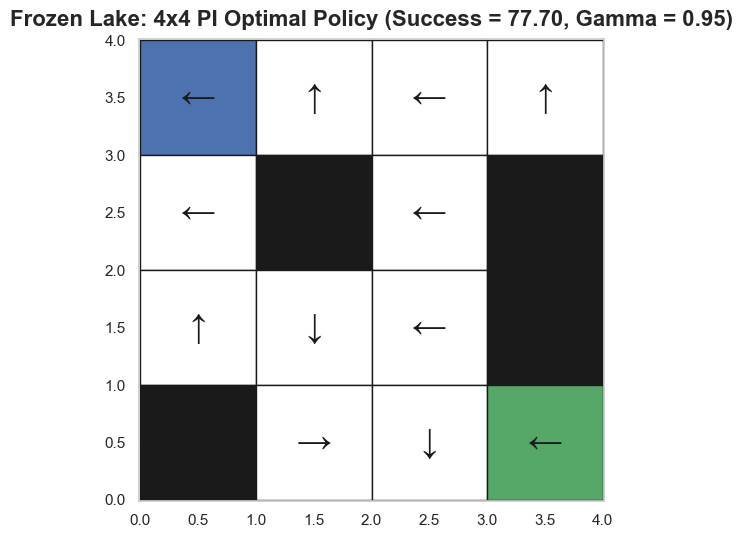

In [566]:
plot_best_policy(pi_data, env, size, size,  mdp_algo = 'PI')

In [147]:
! pip install tqdm
from tqdm import tqdm
import itertools

In [567]:

def run_q_learning(t, r, gamma, alpha, alpha_decay, epsilon_decay, n_iter):
    test =  QLearning(t, r, gamma, alpha, alpha_decay, epsilon_decay, n_iter)
    runs = test.run()
    policy = test.policy
    test_time = runs[-1]['Time']
    test_iter = runs[-1]['Iteration']
    max_value  = runs[-1]['Max V']
    return runs, policy, test_time, test_iter, max_value


def Qlearningz(t, r, gammas, alphas, alpha_decays=[0.99], epsilon_decays=[0.99], n_iterations=[10000000], showResults=False):
    t0 = time.time()
    
    columns = ['gamma', 'alpha', 'alpha_decay', 'epsilon_decay', 'time', 'iterations', 'reward', 'mean_rewards', 'max_rewards', 'error', 'policy']
    total_tests = len(gammas) * len(alphas) * len(alpha_decays) * len(epsilon_decays) * len(n_iterations)
    data = pd.DataFrame(0.0, index=np.arange(total_tests), columns=columns)
    
    testNum = 0
    for i, config in tqdm(enumerate(itertools.product(gammas, alphas, alpha_decays, epsilon_decays, n_iterations)), total=total_tests):
        g, a, a_decay, e_decay, n = config
        runs, test_policy, test_time, test_iterations, max_reward = run_q_learning(t, r, gamma=g, alpha=a, alpha_decay=a_decay, epsilon_decay=e_decay, n_iter=n)
        max_rewards, mean_rewards, errors = [], [], []
        max_rewards = [run['Max V'] for run in runs]
        mean_rewards = [run['Mean V'] for run in runs]
        errors = [run['Error'] for run in runs]

        policy = np.array(test_policy)
        policy = policy.reshape(size,size)

        data.loc[testNum, columns] = g, a, a_decay, e_decay, test_time, test_iterations, max_reward, {tuple(mean_rewards)}, {tuple(max_rewards)}, {tuple(errors)}, {test_policy}         
        print('%.2f,\t%.2f,\t%.2f,\t%d,\t%f' % (g, a, test_time, test_iterations, max_reward))

        testNum += 1

    endTime = time.time() - t0
    print("Time taken: %.2f" %endTime)
    
    data = data[data['policy'] != 0]
    print(data['policy'])
    
    data = get_policy_stats(data, policy, env, showResults)
    
    # replace all NaN's
    data.fillna(0, inplace=True)
    
    return data

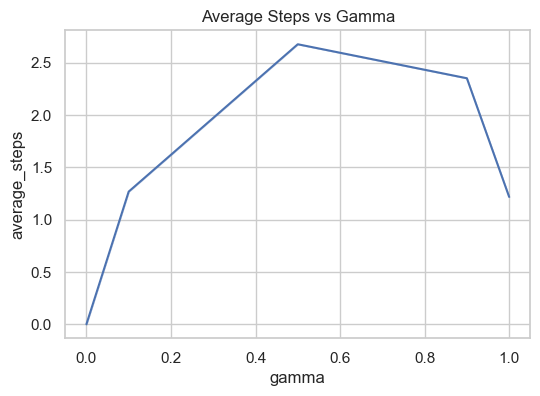

In [354]:
plot_performance(qlearning_data, qlearning_data['gamma'], 'average_steps', 'gamma', 'Average Steps vs Gamma')

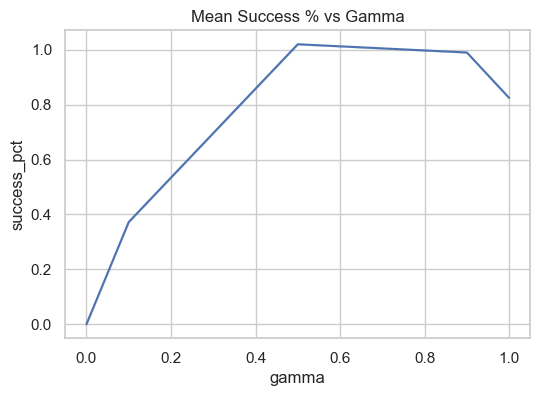

In [355]:
plot_performance(qlearning_data, qlearning_data['gamma'], 'success_pct', 'gamma', 'Mean Success % vs Gamma')

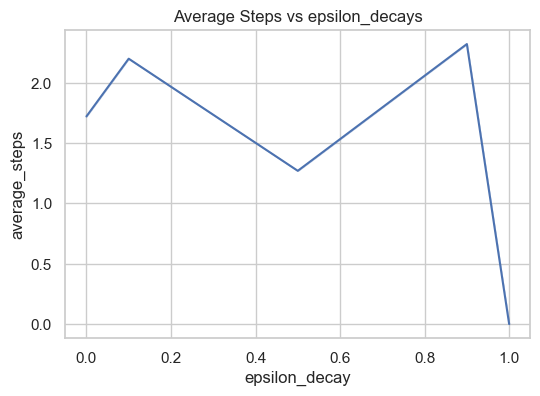

In [356]:
plot_performance(qlearning_data, qlearning_data['epsilon_decay'], 'average_steps', 'epsilon_decay', 'Average Steps vs epsilon_decays')

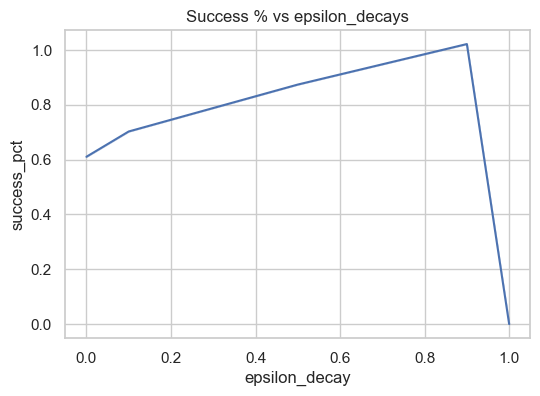

In [357]:
plot_performance(qlearning_data, qlearning_data['epsilon_decay'], 'success_pct', 'epsilon_decay', 'Success % vs epsilon_decays')

/Users/LouisReinaldo/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


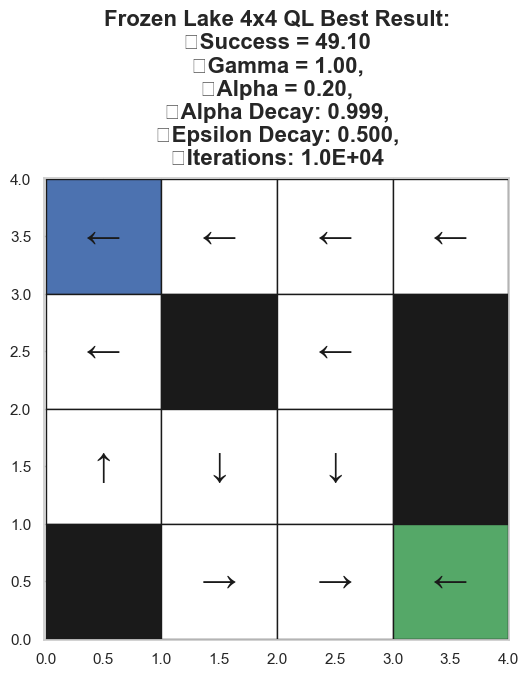

In [366]:
plot_best_policy(qlearning_data, env, size, size, 'Frozen Lake 4x4',  mdp_algo = 'QL')

# Forest

In [571]:
policy_colors = {
    0: 'g', # stands for Wait
    1: 'k'  # stands for Cut
}

policy_labels = {
    0: 'W', # stands for Wait
    1: 'C', # stands for Cut
}

def plot_forest_management_policy(policy, title='Forest Management Policy'):
    # Define the dimensions of the policy grid
    rows = 25
    cols = 25
    
    # Reshape the policy array to 2D grid
    policy = np.array(list(policy)).reshape(rows, cols)
    
    # Create a figure to plot the policy on
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, xlim=(-.01, cols+0.01), ylim=(-.01, rows+0.01))
    
    # Add a title to the plot
    plt.title(title, fontsize=16, weight='bold', y=1.01)
    
    # Loop through each cell of the policy grid
    for i in range(rows):
        for j in range(cols):
            # Calculate the coordinates of the cell
            y = rows - i - 1
            x = j
            
            # Create a rectangle to represent the cell
            rect = plt.Rectangle([x, y], 1, 1, linewidth=1, edgecolor='k')
            
            # Set the face color of the rectangle to represent the policy
            rect.set_facecolor(policy_colors[policy[i, j]])
            
            # Add the rectangle to the plot
            ax.add_patch(rect)
            
            # Add the policy label to the cell
            label = policy_labels[policy[i, j]]
            text = ax.text(x+0.5, y+0.5, label, horizontalalignment='center', size=10, verticalalignment='center', color='w')


In [572]:
import hiive.mdptoolbox.example
forest_size = 25
T,R = mdptoolbox.example.forest(S=forest_size ** 2)
size = forest_size

In [573]:
# gammas   = [0.1, 0.3, 0.6, 0.9, 0.9999999]
# epsilons = [1e-2, 1e-3, 1e-8, 1e-12]
gammas   = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
epsilons = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1]
vi_data  = valueIterationz(T, R, gammas, epsilons, showResults=False)

0.10,	1E-02,	0.00,	2,	4.360000
0.10,	2E-02,	0.00,	2,	4.360000
0.10,	3E-02,	0.00,	2,	4.360000
0.10,	4E-02,	0.00,	1,	4.000000
0.10,	5E-02,	0.00,	1,	4.000000
0.10,	6E-02,	0.00,	1,	4.000000
0.10,	7E-02,	0.00,	1,	4.000000
0.10,	8E-02,	0.00,	1,	4.000000
0.10,	9E-02,	0.00,	1,	4.000000
0.10,	1E-01,	0.00,	1,	4.000000
0.20,	1E-02,	0.00,	3,	4.853200
0.20,	2E-02,	0.00,	3,	4.853200
0.20,	3E-02,	0.00,	3,	4.853200
0.20,	4E-02,	0.00,	2,	4.720000
0.20,	5E-02,	0.00,	2,	4.720000
0.20,	6E-02,	0.00,	2,	4.720000
0.20,	7E-02,	0.00,	2,	4.720000
0.20,	8E-02,	0.00,	2,	4.720000
0.20,	9E-02,	0.00,	2,	4.720000
0.20,	1E-01,	0.00,	2,	4.720000
0.30,	1E-02,	0.00,	4,	5.460862
0.30,	2E-02,	0.00,	4,	5.460862
0.30,	3E-02,	0.00,	4,	5.460862
0.30,	4E-02,	0.00,	3,	5.379700
0.30,	5E-02,	0.00,	3,	5.379700
0.30,	6E-02,	0.00,	3,	5.379700
0.30,	7E-02,	0.00,	3,	5.379700
0.30,	8E-02,	0.00,	3,	5.379700
0.30,	9E-02,	0.00,	3,	5.379700
0.30,	1E-01,	0.00,	3,	5.379700
0.40,	1E-02,	0.00,	6,	6.262393
0.40,	2E-02,	0.00,	5,	6.236539
0.40,	3E

{(0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

{(0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

{(0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

{(0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

{(0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

{(0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

{(0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

{(0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

{(0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

{(0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

{(0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

{(0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

{(0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

{(0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

{(0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

{(0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

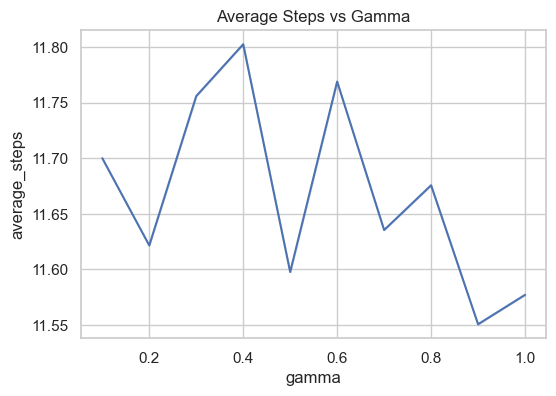

In [574]:
plot_performance(vi_data,vi_data['gamma'], 'average_steps', 'gamma', 'Average Steps vs Gamma')

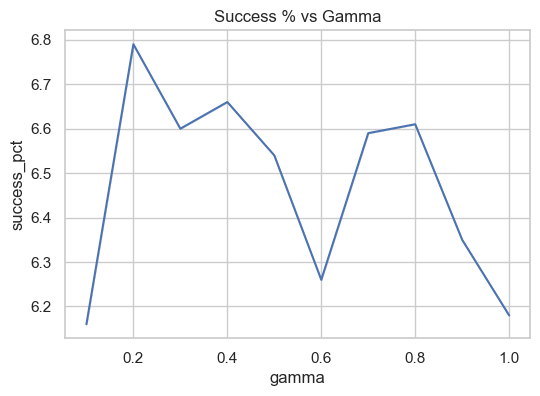

In [575]:
plot_performance(vi_data,vi_data['gamma'], 'success_pct', 'gamma', 'Success % vs Gamma')

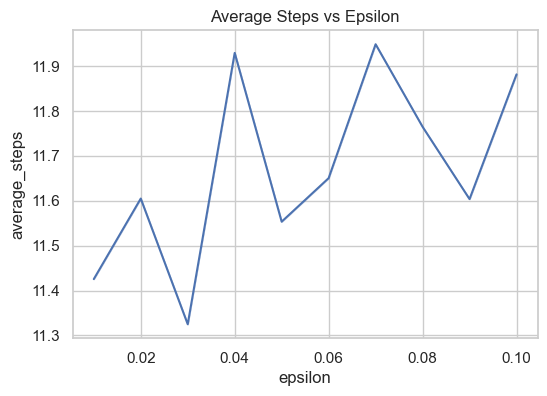

In [576]:
plot_performance(vi_data,vi_data['epsilon'], 'average_steps', 'epsilon', 'Average Steps vs Epsilon')

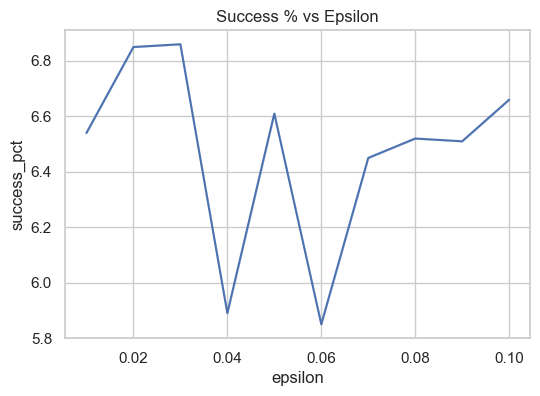

In [577]:
plot_performance(vi_data,vi_data['epsilon'], 'success_pct', 'epsilon', 'Success % vs Epsilon')

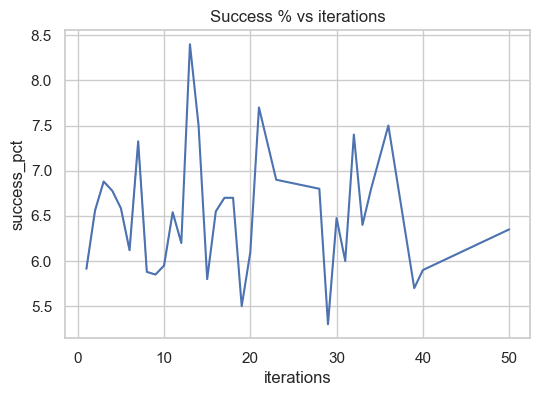

In [578]:
plot_performance(vi_data,vi_data['iterations'], 'success_pct', 'iterations', 'Success % vs iterations')

In [579]:
def plot_best_policy_forest(data, title):
    best_run_index = data['reward'].idxmax()
    best_policy = data['policy'][best_run_index]
    plot_forest_management_policy(best_policy, title)

Best Result:
	Reward = 58.52
	Gamma = 1.0000000
	Epsilon = 3E-02


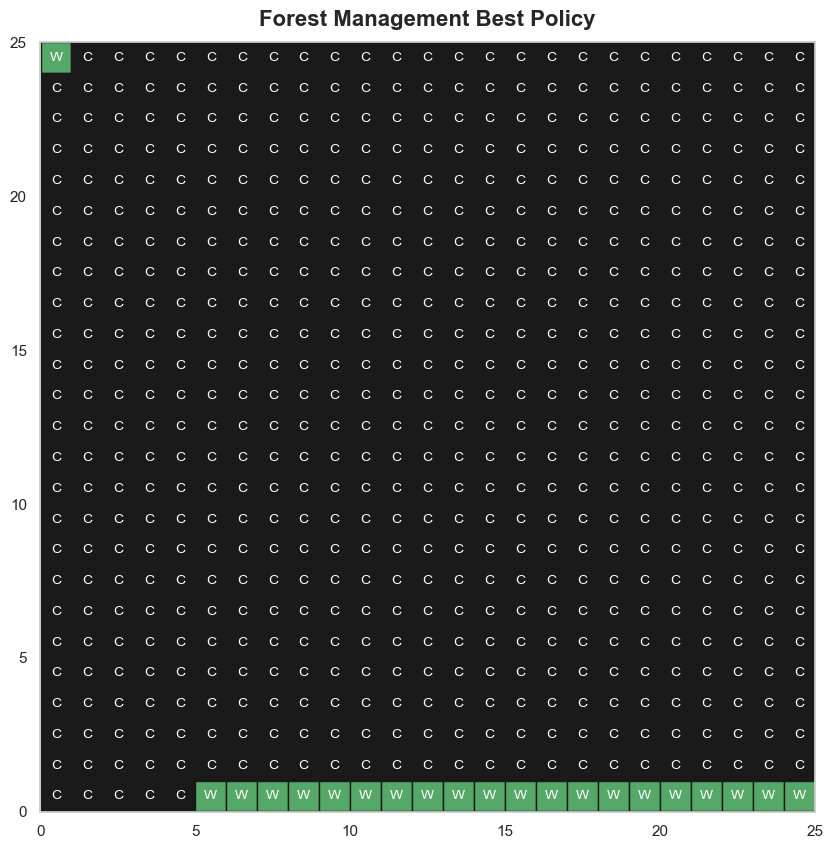

In [594]:
# find the highest score
plot_best_policy_forest(vi_data, 'Forest Management Best Policy')
print('Best Result:\n\tReward = %.2f\n\tGamma = %.7f\n\tEpsilon = %.E' % (vi_data['reward'].max(), vi_data['gamma'][vi_data['reward'].idxmax()], vi_data['epsilon'][vi_data['success_pct'].argmax()]))

In [581]:
pi_data  = policyIterationz(T, R, gammas, showResults=False, tsize = 25)
pi_data[pi_data['success_pct']>0]

gamma:0.1
policy:(0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

policy:(0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

{(0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

,gamma,time,iterations,reward,mean_rewards,max_rewards,error,policy,average_steps,steps_stddev,success_pct
0,0.1,0.061706,1.0,4.396613,"{(1.0131263232180663,)}","{(4.396612561750176,)}","{(0.0,)}","{(0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...",11.631579,4.046361,5.7
1,0.2,0.013008,1.0,4.882699,"{(1.042930963207937,)}","{(4.882699462587847,)}","{(8.881784197001252e-16,)}","{(0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...",11.090909,3.098031,6.6
2,0.3,0.017895,2.0,5.491933,"{(1.0968950798958348, 1.0975363915127048)}","{(5.491933371342282, 5.491933371342282)}","{(0.400819760543631, 8.881784197001252e-16)}","{(0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...",11.436782,3.795645,8.7
3,0.4,0.018776,2.0,6.277574,"{(1.183455882352941, 1.1852176470588234)}","{(6.277573529411765, 6.277573529411765)}","{(1.1011029411764708, 8.881784197001252e-16)}","{(0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...",12.446429,4.325669,5.6
4,0.5,0.030058,3.0,7.329154,"{(1.3188714733542317, 1.322101567398119, 1.322...","{(7.329153605015673, 7.329153605015673, 7.3291...","{(2.0188087774294665, 0.21880877742946692, 1.1...","{(0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...",11.362069,3.021180,5.8
5,0.6,0.067172,3.0,8.809994,"{(1.5365894974590628, 1.5418439299830604, 1.54...","{(8.809994353472616, 8.809994353472616, 8.8099...","{(3.2840203274985895, 1.1240203274985898, 1.77...","{(0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...",11.368421,3.739930,5.7
6,0.7,0.078918,5.0,11.054551,"{(1.9155032332946444, 1.9237475708837675, 1.92...","{(11.054551483999337, 11.054551483999337, 11.0...","{(5.152710993201791, 2.6327109932017905, 1.045...","{(0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...",11.828125,3.625236,6.4
7,0.8,0.054728,6.0,14.883721,"{(2.6930232558139555, 2.706158139534886, 2.714...","{(14.883720930232563, 14.883720930232563, 14.8...","{(8.2093023255814, 5.3293023255813985, 3.25570...","{(0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...",11.287879,3.891580,6.6
8,0.9,0.120874,10.0,23.172434,"{(5.135946741452119,)}","{(23.172433847048566,)}","{(1.7763568394002505e-15,)}","{(0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...",11.897059,4.270761,6.8


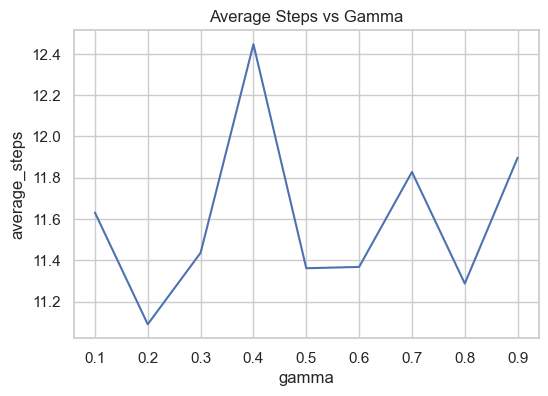

In [582]:
plot_performance(pi_data,pi_data['gamma'], 'average_steps', 'gamma', 'Average Steps vs Gamma')

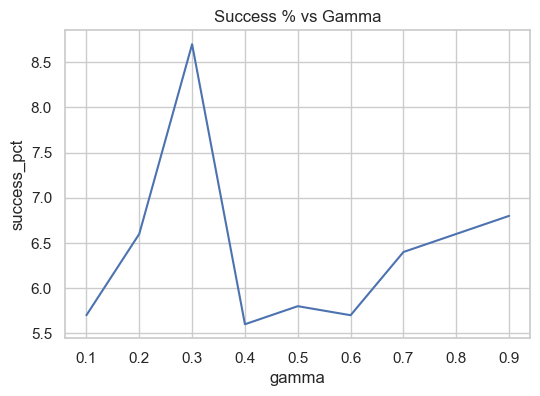

In [583]:
plot_performance(pi_data,pi_data['gamma'], 'success_pct', 'gamma', 'Success % vs Gamma')

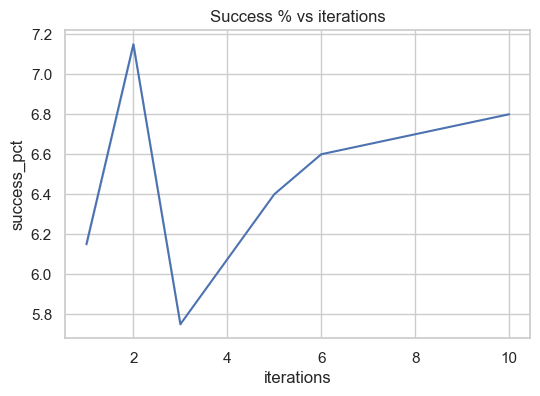

In [584]:
plot_performance(pi_data,pi_data['iterations'], 'success_pct', 'iterations', 'Success % vs iterations')

Best Result:
	Reward = 58.52
	Gamma = 0.2000000
	


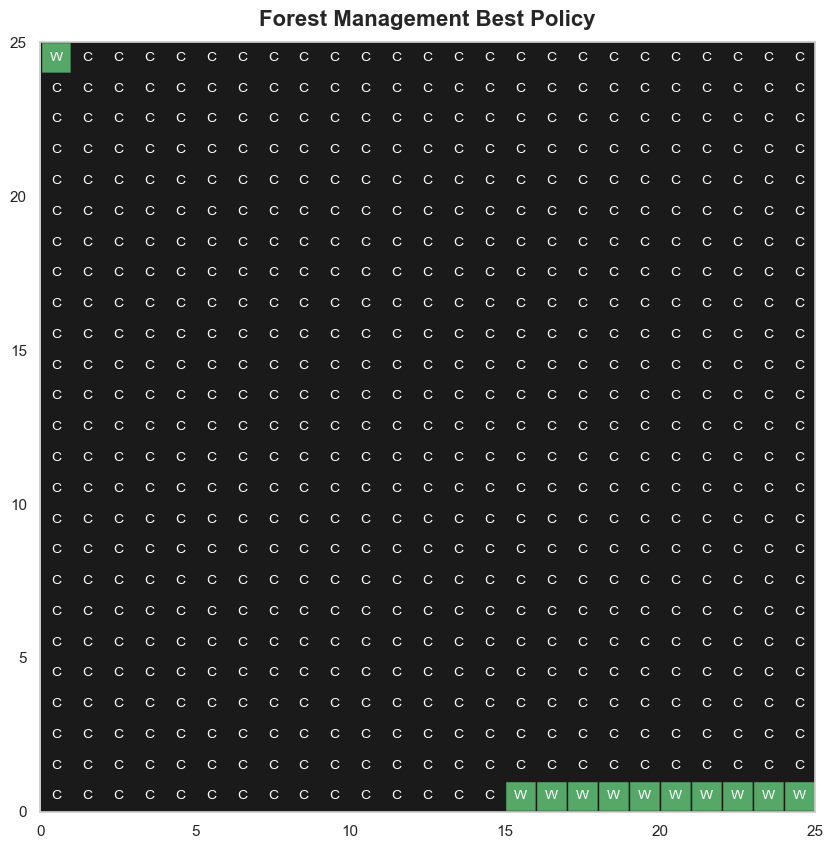

In [591]:
plot_best_policy_forest(pi_data, 'Forest Management Best Policy')
print('Best Result:\n\tReward = %.2f\n\tGamma = %.7f\n\t' % (vi_data['reward'].max(), vi_data['gamma'][vi_data['success_pct'].argmax()]))

In [586]:
gammas   = [0.1, 0.5, 0.9, 0.99]
alphas   = [0.01, 0.1, 0.2]
alpha_decays = [0.9, 0.999]
epsilon_decays = [0.9, 0.999]
iterations = [1e3, 1e4, 1e5]


qlearning_data  = Qlearningz(T, R, gammas, alphas, alpha_decays=alpha_decays, epsilon_decays=epsilon_decays, n_iterations=iterations, showResults=True)


qlearning_data[qlearning_data['success_pct'] > 0]

  0%|                                 | 1/900 [00:00<10:44,  1.39it/s]

0.10,	0.01,	0.70,	10000,	0.010000


  0%|                                 | 2/900 [00:01<10:06,  1.48it/s]

0.10,	0.01,	0.64,	10000,	0.013548


  0%|                                 | 3/900 [00:01<09:35,  1.56it/s]

0.10,	0.01,	0.59,	10000,	0.015447


  0%|▏                                | 4/900 [00:02<09:18,  1.60it/s]

0.10,	0.01,	0.59,	10000,	1.009416


  1%|▏                                | 5/900 [00:03<09:17,  1.60it/s]

0.10,	0.01,	0.61,	10000,	4.141374


  1%|▏                                | 6/900 [00:03<09:26,  1.58it/s]

0.10,	0.01,	0.64,	10000,	2.519884


  1%|▎                                | 7/900 [00:04<09:12,  1.62it/s]

0.10,	0.01,	0.58,	10000,	3.100000


  1%|▎                                | 8/900 [00:05<09:10,  1.62it/s]

0.10,	0.01,	0.60,	10000,	1.009952


  1%|▎                                | 9/900 [00:05<09:03,  1.64it/s]

0.10,	0.01,	0.58,	10000,	1.010030


  1%|▎                               | 10/900 [00:06<09:00,  1.65it/s]

0.10,	0.01,	0.59,	10000,	4.046108


  1%|▍                               | 11/900 [00:06<08:57,  1.65it/s]

0.10,	0.01,	0.59,	10000,	4.053535


  1%|▍                               | 12/900 [00:07<08:56,  1.66it/s]

0.10,	0.01,	0.59,	10000,	4.052123


  1%|▍                               | 13/900 [00:08<08:51,  1.67it/s]

0.10,	0.01,	0.58,	10000,	4.005483


  2%|▍                               | 14/900 [00:08<08:48,  1.68it/s]

0.10,	0.01,	0.58,	10000,	1.010101


  2%|▌                               | 15/900 [00:09<08:46,  1.68it/s]

0.10,	0.01,	0.58,	10000,	4.397523


  2%|▌                               | 16/900 [00:09<08:50,  1.67it/s]

0.10,	0.01,	0.60,	10000,	0.987849


  2%|▌                               | 17/900 [00:10<08:47,  1.67it/s]

0.10,	0.01,	0.58,	10000,	0.980329


  2%|▋                               | 18/900 [00:10<08:45,  1.68it/s]

0.10,	0.01,	0.58,	10000,	0.978824


  2%|▋                               | 19/900 [00:11<08:41,  1.69it/s]

0.10,	0.01,	0.58,	10000,	1.009263


  2%|▋                               | 20/900 [00:12<08:40,  1.69it/s]

0.10,	0.01,	0.58,	10000,	1.088457


  2%|▋                               | 21/900 [00:12<08:39,  1.69it/s]

0.10,	0.01,	0.58,	10000,	2.516137


  2%|▊                               | 22/900 [00:13<08:39,  1.69it/s]

0.10,	0.01,	0.58,	10000,	4.227187


  3%|▊                               | 23/900 [00:13<08:38,  1.69it/s]

0.10,	0.01,	0.58,	10000,	4.165682


  3%|▊                               | 24/900 [00:14<08:41,  1.68it/s]

0.10,	0.01,	0.59,	10000,	1.010098


  3%|▉                               | 25/900 [00:15<08:45,  1.66it/s]

0.10,	0.01,	0.60,	10000,	4.037491


  3%|▉                               | 26/900 [00:15<08:41,  1.68it/s]

0.10,	0.01,	0.58,	10000,	1.010090


  3%|▉                               | 27/900 [00:16<08:38,  1.68it/s]

0.10,	0.01,	0.58,	10000,	4.037491


  3%|▉                               | 28/900 [00:17<08:55,  1.63it/s]

0.10,	0.01,	0.65,	10000,	1.010101


  3%|█                               | 29/900 [00:17<08:56,  1.62it/s]

0.10,	0.01,	0.61,	10000,	1.990000


  3%|█                               | 30/900 [00:18<08:48,  1.65it/s]

0.10,	0.01,	0.57,	10000,	1.010101


  3%|█                               | 31/900 [00:18<08:45,  1.65it/s]

0.10,	0.10,	0.59,	10000,	0.156533


  4%|█▏                              | 32/900 [00:19<08:42,  1.66it/s]

0.10,	0.10,	0.58,	10000,	0.100000


  4%|█▏                              | 33/900 [00:20<08:56,  1.62it/s]

0.10,	0.10,	0.64,	10000,	0.153110


  4%|█▏                              | 34/900 [00:20<08:51,  1.63it/s]

0.10,	0.10,	0.59,	10000,	3.582506


  4%|█▏                              | 35/900 [00:21<08:57,  1.61it/s]

0.10,	0.10,	0.63,	10000,	1.009347


  4%|█▎                              | 36/900 [00:21<08:52,  1.62it/s]

0.10,	0.10,	0.59,	10000,	3.332840


  4%|█▎                              | 37/900 [00:22<08:46,  1.64it/s]

0.10,	0.10,	0.58,	10000,	1.010039


  4%|█▎                              | 38/900 [00:23<08:59,  1.60it/s]

0.10,	0.10,	0.65,	10000,	4.438253


  4%|█▍                              | 39/900 [00:23<08:51,  1.62it/s]

0.10,	0.10,	0.59,	10000,	1.010095


  4%|█▍                              | 40/900 [00:24<08:44,  1.64it/s]

0.10,	0.10,	0.58,	10000,	3.609091


  5%|█▍                              | 41/900 [00:24<08:46,  1.63it/s]

0.10,	0.10,	0.61,	10000,	4.053455


  5%|█▍                              | 42/900 [00:25<08:41,  1.65it/s]

0.10,	0.10,	0.58,	10000,	3.969082


  5%|█▌                              | 43/900 [00:26<09:22,  1.52it/s]

0.10,	0.10,	0.75,	10000,	4.014444


  5%|█▌                              | 44/900 [00:27<09:29,  1.50it/s]

0.10,	0.10,	0.67,	10000,	1.010101


  5%|█▌                              | 45/900 [00:27<09:35,  1.49it/s]

0.10,	0.10,	0.68,	10000,	1.010101


  5%|█▋                              | 46/900 [00:28<09:24,  1.51it/s]

0.10,	0.10,	0.62,	10000,	1.009222


  5%|█▋                              | 47/900 [00:29<09:42,  1.46it/s]

0.10,	0.10,	0.72,	10000,	1.009287


  5%|█▋                              | 48/900 [00:29<09:28,  1.50it/s]

0.10,	0.10,	0.62,	10000,	1.009187


  5%|█▋                              | 49/900 [00:30<09:17,  1.53it/s]

0.10,	0.10,	0.62,	10000,	1.009422


  6%|█▊                              | 50/900 [00:30<09:05,  1.56it/s]

0.10,	0.10,	0.60,	10000,	3.227096


  6%|█▊                              | 51/900 [00:31<09:35,  1.48it/s]

0.10,	0.10,	0.75,	10000,	1.009484


  6%|█▊                              | 52/900 [00:32<09:16,  1.52it/s]

0.10,	0.10,	0.59,	10000,	1.009611


  6%|█▉                              | 53/900 [00:32<09:06,  1.55it/s]

0.10,	0.10,	0.61,	10000,	3.554470


  6%|█▉                              | 54/900 [00:33<08:58,  1.57it/s]

0.10,	0.10,	0.60,	10000,	4.065728


  6%|█▉                              | 55/900 [00:34<08:44,  1.61it/s]

0.10,	0.10,	0.58,	10000,	1.010100


  6%|█▉                              | 56/900 [00:35<09:49,  1.43it/s]

0.10,	0.10,	0.86,	10000,	1.010101


  6%|██                              | 57/900 [00:35<09:41,  1.45it/s]

0.10,	0.10,	0.65,	10000,	4.438652


  6%|██                              | 58/900 [00:36<09:27,  1.48it/s]

0.10,	0.10,	0.62,	10000,	4.014444


  7%|██                              | 59/900 [00:36<09:23,  1.49it/s]

0.10,	0.10,	0.65,	10000,	4.444376


  7%|██▏                             | 60/900 [00:37<09:08,  1.53it/s]

0.10,	0.10,	0.60,	10000,	1.010101


  7%|██▏                             | 61/900 [00:38<09:11,  1.52it/s]

0.10,	0.20,	0.66,	10000,	0.177280


  7%|██▏                             | 62/900 [00:38<09:22,  1.49it/s]

0.10,	0.20,	0.69,	10000,	0.200000


  7%|██▏                             | 63/900 [00:39<09:11,  1.52it/s]

0.10,	0.20,	0.62,	10000,	0.284167


  7%|██▎                             | 64/900 [00:40<09:03,  1.54it/s]

0.10,	0.20,	0.61,	10000,	4.283644


  7%|██▎                             | 65/900 [00:40<08:48,  1.58it/s]

0.10,	0.20,	0.58,	10000,	2.519999


  7%|██▎                             | 66/900 [00:41<08:39,  1.61it/s]

0.10,	0.20,	0.59,	10000,	1.009448


  7%|██▍                             | 67/900 [00:42<08:37,  1.61it/s]

0.10,	0.20,	0.61,	10000,	4.444444


  8%|██▍                             | 68/900 [00:42<08:33,  1.62it/s]

0.10,	0.20,	0.59,	10000,	4.443414


  8%|██▍                             | 69/900 [00:43<08:27,  1.64it/s]

0.10,	0.20,	0.59,	10000,	4.227273


  8%|██▍                             | 70/900 [00:43<08:25,  1.64it/s]

0.10,	0.20,	0.59,	10000,	3.968355


  8%|██▌                             | 71/900 [00:44<08:21,  1.65it/s]

0.10,	0.20,	0.59,	10000,	4.037411


  8%|██▌                             | 72/900 [00:45<08:23,  1.64it/s]

0.10,	0.20,	0.60,	10000,	4.050478


  8%|██▌                             | 73/900 [00:45<08:20,  1.65it/s]

0.10,	0.20,	0.59,	10000,	4.014444


  8%|██▋                             | 74/900 [00:46<08:16,  1.66it/s]

0.10,	0.20,	0.58,	10000,	3.960000


  8%|██▋                             | 75/900 [00:46<08:12,  1.67it/s]

0.10,	0.20,	0.58,	10000,	4.444444


  8%|██▋                             | 76/900 [00:47<08:11,  1.68it/s]

0.10,	0.20,	0.58,	10000,	1.009175


  9%|██▋                             | 77/900 [00:48<08:10,  1.68it/s]

0.10,	0.20,	0.59,	10000,	1.009190


  9%|██▊                             | 78/900 [00:48<08:09,  1.68it/s]

0.10,	0.20,	0.58,	10000,	1.009198


  9%|██▊                             | 79/900 [00:49<08:07,  1.69it/s]

0.10,	0.20,	0.58,	10000,	1.650155


  9%|██▊                             | 80/900 [00:49<08:10,  1.67it/s]

0.10,	0.20,	0.60,	10000,	3.428924


  9%|██▉                             | 81/900 [00:50<08:08,  1.68it/s]

0.10,	0.20,	0.59,	10000,	2.542534


  9%|██▉                             | 82/900 [00:50<08:05,  1.69it/s]

0.10,	0.20,	0.57,	10000,	2.005042


  9%|██▉                             | 83/900 [00:51<08:06,  1.68it/s]

0.10,	0.20,	0.59,	10000,	4.221643


  9%|██▉                             | 84/900 [00:52<08:09,  1.67it/s]

0.10,	0.20,	0.60,	10000,	1.009983


  9%|███                             | 85/900 [00:52<08:07,  1.67it/s]

0.10,	0.20,	0.58,	10000,	3.969091


 10%|███                             | 86/900 [00:53<08:04,  1.68it/s]

0.10,	0.20,	0.58,	10000,	1.010101


 10%|███                             | 87/900 [00:53<08:03,  1.68it/s]

0.10,	0.20,	0.58,	10000,	4.050487


 10%|███▏                            | 88/900 [00:54<08:04,  1.68it/s]

0.10,	0.20,	0.59,	10000,	1.010101


 10%|███▏                            | 89/900 [00:55<08:01,  1.68it/s]

0.10,	0.20,	0.58,	10000,	1.010101


 10%|███▏                            | 90/900 [00:55<07:58,  1.69it/s]

0.10,	0.20,	0.58,	10000,	3.961090


 10%|███▏                            | 91/900 [00:56<08:01,  1.68it/s]

0.20,	0.01,	0.59,	10000,	0.015130


 10%|███▎                            | 92/900 [00:56<07:59,  1.69it/s]

0.20,	0.01,	0.58,	10000,	0.010211


 10%|███▎                            | 93/900 [00:57<07:58,  1.68it/s]

0.20,	0.01,	0.58,	10000,	0.014415


 10%|███▎                            | 94/900 [00:58<08:06,  1.66it/s]

0.20,	0.01,	0.61,	10000,	1.106560


 11%|███▍                            | 95/900 [00:58<08:05,  1.66it/s]

0.20,	0.01,	0.59,	10000,	1.040240


 11%|███▍                            | 96/900 [00:59<08:06,  1.65it/s]

0.20,	0.01,	0.60,	10000,	1.039620


 11%|███▍                            | 97/900 [00:59<08:02,  1.66it/s]

0.20,	0.01,	0.58,	10000,	1.041041


 11%|███▍                            | 98/900 [01:00<08:01,  1.67it/s]

0.20,	0.01,	0.59,	10000,	1.041319


 11%|███▌                            | 99/900 [01:01<07:58,  1.67it/s]

0.20,	0.01,	0.58,	10000,	1.041664


 11%|███▍                           | 100/900 [01:01<07:57,  1.68it/s]

0.20,	0.01,	0.59,	10000,	1.041667


 11%|███▍                           | 101/900 [01:02<07:54,  1.68it/s]

0.20,	0.01,	0.58,	10000,	1.041667


 11%|███▌                           | 102/900 [01:02<07:53,  1.68it/s]

0.20,	0.01,	0.58,	10000,	4.969267


 11%|███▌                           | 103/900 [01:03<07:52,  1.69it/s]

0.20,	0.01,	0.58,	10000,	4.051249


 12%|███▌                           | 104/900 [01:04<07:50,  1.69it/s]

0.20,	0.01,	0.58,	10000,	4.001250


 12%|███▌                           | 105/900 [01:04<07:53,  1.68it/s]

0.20,	0.01,	0.60,	10000,	1.041667


 12%|███▋                           | 106/900 [01:05<08:09,  1.62it/s]

0.20,	0.01,	0.65,	10000,	1.004132


 12%|███▋                           | 107/900 [01:05<08:01,  1.65it/s]

0.20,	0.01,	0.58,	10000,	1.009129


 12%|███▋                           | 108/900 [01:06<07:59,  1.65it/s]

0.20,	0.01,	0.59,	10000,	1.007659


 12%|███▊                           | 109/900 [01:07<07:53,  1.67it/s]

0.20,	0.01,	0.57,	10000,	1.038655


 12%|███▊                           | 110/900 [01:07<07:46,  1.69it/s]

0.20,	0.01,	0.56,	10000,	1.937700


 12%|███▊                           | 111/900 [01:08<07:43,  1.70it/s]

0.20,	0.01,	0.57,	10000,	1.038620


 12%|███▊                           | 112/900 [01:08<07:43,  1.70it/s]

0.20,	0.01,	0.58,	10000,	3.020137


 13%|███▉                           | 113/900 [01:09<07:45,  1.69it/s]

0.20,	0.01,	0.59,	10000,	4.513911


 13%|███▉                           | 114/900 [01:10<07:50,  1.67it/s]

0.20,	0.01,	0.61,	10000,	1.041602


 13%|███▉                           | 115/900 [01:10<07:57,  1.64it/s]

0.20,	0.01,	0.62,	10000,	4.037214


 13%|███▉                           | 116/900 [01:11<07:54,  1.65it/s]

0.20,	0.01,	0.59,	10000,	1.041667


 13%|████                           | 117/900 [01:11<07:53,  1.66it/s]

0.20,	0.01,	0.59,	10000,	4.137142


 13%|████                           | 118/900 [01:12<07:49,  1.67it/s]

0.20,	0.01,	0.58,	10000,	4.001250


 13%|████                           | 119/900 [01:13<07:49,  1.67it/s]

0.20,	0.01,	0.59,	10000,	1.041667


 13%|████▏                          | 120/900 [01:13<07:44,  1.68it/s]

0.20,	0.01,	0.57,	10000,	4.050840


 13%|████▏                          | 121/900 [01:14<07:43,  1.68it/s]

0.20,	0.10,	0.58,	10000,	0.086760


 14%|████▏                          | 122/900 [01:14<07:42,  1.68it/s]

0.20,	0.10,	0.58,	10000,	0.180526


 14%|████▏                          | 123/900 [01:15<07:42,  1.68it/s]

0.20,	0.10,	0.59,	10000,	0.098864


 14%|████▎                          | 124/900 [01:16<07:40,  1.69it/s]

0.20,	0.10,	0.58,	10000,	3.788389


 14%|████▎                          | 125/900 [01:16<07:39,  1.69it/s]

0.20,	0.10,	0.59,	10000,	1.038529


 14%|████▎                          | 126/900 [01:17<07:39,  1.68it/s]

0.20,	0.10,	0.58,	10000,	3.575673


 14%|████▎                          | 127/900 [01:17<07:40,  1.68it/s]

0.20,	0.10,	0.59,	10000,	4.572498


 14%|████▍                          | 128/900 [01:18<07:36,  1.69it/s]

0.20,	0.10,	0.57,	10000,	4.989116


 14%|████▍                          | 129/900 [01:19<07:33,  1.70it/s]

0.20,	0.10,	0.57,	10000,	1.041666


 14%|████▍                          | 130/900 [01:19<07:32,  1.70it/s]

0.20,	0.10,	0.58,	10000,	4.134427


 15%|████▌                          | 131/900 [01:20<07:34,  1.69it/s]

0.20,	0.10,	0.59,	10000,	3.600000


 15%|████▌                          | 132/900 [01:20<08:02,  1.59it/s]

0.20,	0.10,	0.70,	10000,	4.608000


 15%|████▌                          | 133/900 [01:21<07:58,  1.60it/s]

0.20,	0.10,	0.60,	10000,	5.000000


 15%|████▌                          | 134/900 [01:22<07:56,  1.61it/s]

0.20,	0.10,	0.60,	10000,	4.991012


 15%|████▋                          | 135/900 [01:22<07:48,  1.63it/s]

0.20,	0.10,	0.58,	10000,	1.041667


 15%|████▋                          | 136/900 [01:23<07:39,  1.66it/s]

0.20,	0.10,	0.57,	10000,	1.038235


 15%|████▋                          | 137/900 [01:23<07:35,  1.67it/s]

0.20,	0.10,	0.58,	10000,	1.038223


 15%|████▊                          | 138/900 [01:24<07:35,  1.67it/s]

0.20,	0.10,	0.58,	10000,	1.037936


 15%|████▊                          | 139/900 [01:25<07:34,  1.67it/s]

0.20,	0.10,	0.58,	10000,	3.718755


 16%|████▊                          | 140/900 [01:25<07:32,  1.68it/s]

0.20,	0.10,	0.58,	10000,	1.095053


 16%|████▊                          | 141/900 [01:26<07:34,  1.67it/s]

0.20,	0.10,	0.59,	10000,	1.038500


 16%|████▉                          | 142/900 [01:26<07:29,  1.69it/s]

0.20,	0.10,	0.57,	10000,	4.401375


 16%|████▉                          | 143/900 [01:27<07:27,  1.69it/s]

0.20,	0.10,	0.58,	10000,	1.041667


 16%|████▉                          | 144/900 [01:28<07:23,  1.70it/s]

0.20,	0.10,	0.57,	10000,	1.041665


 16%|████▉                          | 145/900 [01:28<07:26,  1.69it/s]

0.20,	0.10,	0.59,	10000,	4.999325


 16%|█████                          | 146/900 [01:29<07:27,  1.69it/s]

0.20,	0.10,	0.59,	10000,	4.969267


 16%|█████                          | 147/900 [01:29<07:27,  1.68it/s]

0.20,	0.10,	0.59,	10000,	1.041664


 16%|█████                          | 148/900 [01:30<07:28,  1.68it/s]

0.20,	0.10,	0.59,	10000,	4.955005


 17%|█████▏                         | 149/900 [01:31<07:26,  1.68it/s]

0.20,	0.10,	0.58,	10000,	4.051232


 17%|█████▏                         | 150/900 [01:31<07:23,  1.69it/s]

0.20,	0.10,	0.57,	10000,	4.001250


 17%|█████▏                         | 151/900 [01:32<07:25,  1.68it/s]

0.20,	0.20,	0.59,	10000,	0.278478


 17%|█████▏                         | 152/900 [01:32<07:26,  1.68it/s]

0.20,	0.20,	0.59,	10000,	0.180000


 17%|█████▎                         | 153/900 [01:33<07:22,  1.69it/s]

0.20,	0.20,	0.57,	10000,	0.208035


 17%|█████▎                         | 154/900 [01:34<07:19,  1.70it/s]

0.20,	0.20,	0.57,	10000,	1.040543


 17%|█████▎                         | 155/900 [01:34<07:19,  1.70it/s]

0.20,	0.20,	0.58,	10000,	2.175207


 17%|█████▎                         | 156/900 [01:35<07:18,  1.70it/s]

0.20,	0.20,	0.58,	10000,	1.418035


 17%|█████▍                         | 157/900 [01:35<07:15,  1.71it/s]

0.20,	0.20,	0.57,	10000,	1.041602


 18%|█████▍                         | 158/900 [01:36<07:18,  1.69it/s]

0.20,	0.20,	0.59,	10000,	4.949612


 18%|█████▍                         | 159/900 [01:36<07:15,  1.70it/s]

0.20,	0.20,	0.57,	10000,	4.916019


 18%|█████▌                         | 160/900 [01:37<07:13,  1.71it/s]

0.20,	0.20,	0.57,	10000,	4.137433


 18%|█████▌                         | 161/900 [01:38<07:15,  1.70it/s]

0.20,	0.20,	0.59,	10000,	4.126523


 18%|█████▌                         | 162/900 [01:38<07:13,  1.70it/s]

0.20,	0.20,	0.58,	10000,	1.041667


 18%|█████▌                         | 163/900 [01:39<07:13,  1.70it/s]

0.20,	0.20,	0.58,	10000,	4.802210


 18%|█████▋                         | 164/900 [01:39<07:14,  1.69it/s]

0.20,	0.20,	0.58,	10000,	4.008180


 18%|█████▋                         | 165/900 [01:40<07:16,  1.68it/s]

0.20,	0.20,	0.59,	10000,	5.000000


 18%|█████▋                         | 166/900 [01:41<07:15,  1.68it/s]

0.20,	0.20,	0.58,	10000,	1.038428


 19%|█████▊                         | 167/900 [01:41<07:11,  1.70it/s]

0.20,	0.20,	0.57,	10000,	1.037950


 19%|█████▊                         | 168/900 [01:42<07:09,  1.71it/s]

0.20,	0.20,	0.57,	10000,	1.038078


 19%|█████▊                         | 169/900 [01:42<07:09,  1.70it/s]

0.20,	0.20,	0.58,	10000,	1.040263


 19%|█████▊                         | 170/900 [01:43<07:08,  1.70it/s]

0.20,	0.20,	0.58,	10000,	3.948809


 19%|█████▉                         | 171/900 [01:44<07:07,  1.70it/s]

0.20,	0.20,	0.58,	10000,	1.038937


 19%|█████▉                         | 172/900 [01:44<07:09,  1.70it/s]

0.20,	0.20,	0.58,	10000,	1.041346


 19%|█████▉                         | 173/900 [01:45<07:11,  1.69it/s]

0.20,	0.20,	0.59,	10000,	4.495639


 19%|█████▉                         | 174/900 [01:45<07:09,  1.69it/s]

0.20,	0.20,	0.58,	10000,	4.325839


 19%|██████                         | 175/900 [01:46<07:09,  1.69it/s]

0.20,	0.20,	0.59,	10000,	1.041667


 20%|██████                         | 176/900 [01:46<07:07,  1.69it/s]

0.20,	0.20,	0.57,	10000,	1.041664


 20%|██████                         | 177/900 [01:47<07:08,  1.69it/s]

0.20,	0.20,	0.59,	10000,	1.041666


 20%|██████▏                        | 178/900 [01:48<07:08,  1.69it/s]

0.20,	0.20,	0.59,	10000,	1.041667


 20%|██████▏                        | 179/900 [01:48<07:05,  1.70it/s]

0.20,	0.20,	0.57,	10000,	1.041667


 20%|██████▏                        | 180/900 [01:49<07:02,  1.70it/s]

0.20,	0.20,	0.57,	10000,	4.051250


 20%|██████▏                        | 181/900 [01:49<07:04,  1.69it/s]

0.30,	0.01,	0.59,	10000,	0.018181


 20%|██████▎                        | 182/900 [01:50<07:04,  1.69it/s]

0.30,	0.01,	0.58,	10000,	0.023265


 20%|██████▎                        | 183/900 [01:51<07:05,  1.69it/s]

0.30,	0.01,	0.59,	10000,	0.010319


 20%|██████▎                        | 184/900 [01:51<07:02,  1.70it/s]

0.30,	0.01,	0.57,	10000,	1.089546


 21%|██████▎                        | 185/900 [01:52<06:59,  1.70it/s]

0.30,	0.01,	0.57,	10000,	1.094381


 21%|██████▍                        | 186/900 [01:52<07:00,  1.70it/s]

0.30,	0.01,	0.58,	10000,	4.431728


 21%|██████▍                        | 187/900 [01:53<06:58,  1.71it/s]

0.30,	0.01,	0.57,	10000,	3.047929


 21%|██████▍                        | 188/900 [01:54<06:57,  1.70it/s]

0.30,	0.01,	0.58,	10000,	5.712692


 21%|██████▌                        | 189/900 [01:54<06:59,  1.69it/s]

0.30,	0.01,	0.59,	10000,	4.765145


 21%|██████▌                        | 190/900 [01:55<06:58,  1.70it/s]

0.30,	0.01,	0.58,	10000,	3.689011


 21%|██████▌                        | 191/900 [01:55<06:56,  1.70it/s]

0.30,	0.01,	0.57,	10000,	1.098891


 21%|██████▌                        | 192/900 [01:56<06:55,  1.70it/s]

0.30,	0.01,	0.58,	10000,	5.607191


 21%|██████▋                        | 193/900 [01:56<06:55,  1.70it/s]

0.30,	0.01,	0.58,	10000,	4.096834


 22%|██████▋                        | 194/900 [01:57<06:57,  1.69it/s]

0.30,	0.01,	0.59,	10000,	2.010059


 22%|██████▋                        | 195/900 [01:58<06:55,  1.70it/s]

0.30,	0.01,	0.58,	10000,	1.098901


 22%|██████▊                        | 196/900 [01:58<06:54,  1.70it/s]

0.30,	0.01,	0.58,	10000,	1.040696


 22%|██████▊                        | 197/900 [01:59<06:53,  1.70it/s]

0.30,	0.01,	0.58,	10000,	1.042703


 22%|██████▊                        | 198/900 [01:59<06:54,  1.70it/s]

0.30,	0.01,	0.58,	10000,	1.043517


 22%|██████▊                        | 199/900 [02:00<06:53,  1.70it/s]

0.30,	0.01,	0.58,	10000,	2.458077


 22%|██████▉                        | 200/900 [02:01<06:53,  1.69it/s]

0.30,	0.01,	0.58,	10000,	4.653447


 22%|██████▉                        | 201/900 [02:01<06:55,  1.68it/s]

0.30,	0.01,	0.59,	10000,	1.091518


 22%|██████▉                        | 202/900 [02:02<06:59,  1.67it/s]

0.30,	0.01,	0.59,	10000,	3.699375


 23%|██████▉                        | 203/900 [02:02<06:58,  1.67it/s]

0.30,	0.01,	0.59,	10000,	2.049451


 23%|███████                        | 204/900 [02:03<06:57,  1.67it/s]

0.30,	0.01,	0.59,	10000,	5.276991


 23%|███████                        | 205/900 [02:04<06:53,  1.68it/s]

0.30,	0.01,	0.57,	10000,	4.259897


 23%|███████                        | 206/900 [02:04<06:53,  1.68it/s]

0.30,	0.01,	0.59,	10000,	1.098901


 23%|███████▏                       | 207/900 [02:05<06:53,  1.67it/s]

0.30,	0.01,	0.59,	10000,	1.098901


 23%|███████▏                       | 208/900 [02:05<06:50,  1.69it/s]

0.30,	0.01,	0.57,	10000,	1.098901


 23%|███████▏                       | 209/900 [02:06<06:47,  1.69it/s]

0.30,	0.01,	0.57,	10000,	4.110079


 23%|███████▏                       | 210/900 [02:07<06:49,  1.69it/s]

0.30,	0.01,	0.59,	10000,	1.098901


 23%|███████▎                       | 211/900 [02:07<06:46,  1.70it/s]

0.30,	0.10,	0.57,	10000,	0.141251


 24%|███████▎                       | 212/900 [02:08<06:43,  1.71it/s]

0.30,	0.10,	0.57,	10000,	0.181550


 24%|███████▎                       | 213/900 [02:08<06:42,  1.71it/s]

0.30,	0.10,	0.58,	10000,	0.100000


 24%|███████▎                       | 214/900 [02:09<06:41,  1.71it/s]

0.30,	0.10,	0.57,	10000,	1.093738


 24%|███████▍                       | 215/900 [02:10<06:41,  1.70it/s]

0.30,	0.10,	0.58,	10000,	1.704804


 24%|███████▍                       | 216/900 [02:10<06:39,  1.71it/s]

0.30,	0.10,	0.57,	10000,	1.092746


 24%|███████▍                       | 217/900 [02:11<06:37,  1.72it/s]

0.30,	0.10,	0.57,	10000,	1.098696


 24%|███████▌                       | 218/900 [02:11<06:39,  1.71it/s]

0.30,	0.10,	0.58,	10000,	5.710514


 24%|███████▌                       | 219/900 [02:12<06:39,  1.70it/s]

0.30,	0.10,	0.58,	10000,	4.898218


 24%|███████▌                       | 220/900 [02:12<06:40,  1.70it/s]

0.30,	0.10,	0.58,	10000,	1.098895


 25%|███████▌                       | 221/900 [02:13<06:41,  1.69it/s]

0.30,	0.10,	0.59,	10000,	4.260439


 25%|███████▋                       | 222/900 [02:14<06:43,  1.68it/s]

0.30,	0.10,	0.60,	10000,	1.098901


 25%|███████▋                       | 223/900 [02:14<06:52,  1.64it/s]

0.30,	0.10,	0.63,	10000,	4.115055


 25%|███████▋                       | 224/900 [02:15<06:48,  1.65it/s]

0.30,	0.10,	0.58,	10000,	4.115055


 25%|███████▊                       | 225/900 [02:15<06:46,  1.66it/s]

0.30,	0.10,	0.59,	10000,	4.109582


 25%|███████▊                       | 226/900 [02:16<06:47,  1.65it/s]

0.30,	0.10,	0.60,	10000,	1.090422


 25%|███████▊                       | 227/900 [02:17<06:44,  1.66it/s]

0.30,	0.10,	0.58,	10000,	1.091037


 25%|███████▊                       | 228/900 [02:17<06:49,  1.64it/s]

0.30,	0.10,	0.62,	10000,	1.090522


 25%|███████▉                       | 229/900 [02:18<06:52,  1.63it/s]

0.30,	0.10,	0.61,	10000,	1.092209


 26%|███████▉                       | 230/900 [02:19<06:53,  1.62it/s]

0.30,	0.10,	0.61,	10000,	1.093369


 26%|███████▉                       | 231/900 [02:19<06:51,  1.62it/s]

0.30,	0.10,	0.60,	10000,	1.095758


 26%|███████▉                       | 232/900 [02:20<06:47,  1.64it/s]

0.30,	0.10,	0.59,	10000,	4.367538


 26%|████████                       | 233/900 [02:20<06:42,  1.66it/s]

0.30,	0.10,	0.58,	10000,	2.049449


 26%|████████                       | 234/900 [02:21<06:39,  1.67it/s]

0.30,	0.10,	0.58,	10000,	1.097087


 26%|████████                       | 235/900 [02:22<06:36,  1.68it/s]

0.30,	0.10,	0.58,	10000,	1.097800


 26%|████████▏                      | 236/900 [02:22<06:37,  1.67it/s]

0.30,	0.10,	0.59,	10000,	4.257319


 26%|████████▏                      | 237/900 [02:23<06:33,  1.69it/s]

0.30,	0.10,	0.57,	10000,	1.098692


 26%|████████▏                      | 238/900 [02:23<06:32,  1.69it/s]

0.30,	0.10,	0.58,	10000,	4.115043


 27%|████████▏                      | 239/900 [02:24<06:30,  1.69it/s]

0.30,	0.10,	0.58,	10000,	1.098901


 27%|████████▎                      | 240/900 [02:25<06:32,  1.68it/s]

0.30,	0.10,	0.59,	10000,	4.115055


 27%|████████▎                      | 241/900 [02:25<06:28,  1.69it/s]

0.30,	0.20,	0.57,	10000,	0.200000


 27%|████████▎                      | 242/900 [02:26<06:26,  1.70it/s]

0.30,	0.20,	0.57,	10000,	0.200000


 27%|████████▎                      | 243/900 [02:26<06:24,  1.71it/s]

0.30,	0.20,	0.57,	10000,	0.218813


 27%|████████▍                      | 244/900 [02:27<06:23,  1.71it/s]

0.30,	0.20,	0.57,	10000,	1.091021


 27%|████████▍                      | 245/900 [02:27<06:22,  1.71it/s]

0.30,	0.20,	0.57,	10000,	1.091893


 27%|████████▍                      | 246/900 [02:28<06:21,  1.71it/s]

0.30,	0.20,	0.57,	10000,	1.705397


 27%|████████▌                      | 247/900 [02:29<06:22,  1.71it/s]

0.30,	0.20,	0.58,	10000,	5.434158


 28%|████████▌                      | 248/900 [02:29<06:25,  1.69it/s]

0.30,	0.20,	0.59,	10000,	4.694250


 28%|████████▌                      | 249/900 [02:30<06:26,  1.69it/s]

0.30,	0.20,	0.59,	10000,	1.098691


 28%|████████▌                      | 250/900 [02:30<06:27,  1.68it/s]

0.30,	0.20,	0.59,	10000,	5.511292


 28%|████████▋                      | 251/900 [02:31<06:30,  1.66it/s]

0.30,	0.20,	0.60,	10000,	4.231495


 28%|████████▋                      | 252/900 [02:32<06:27,  1.67it/s]

0.30,	0.20,	0.58,	10000,	4.258973


 28%|████████▋                      | 253/900 [02:32<06:26,  1.67it/s]

0.30,	0.20,	0.58,	10000,	4.115007


 28%|████████▋                      | 254/900 [02:33<06:24,  1.68it/s]

0.30,	0.20,	0.58,	10000,	4.029659


 28%|████████▊                      | 255/900 [02:33<06:23,  1.68it/s]

0.30,	0.20,	0.58,	10000,	1.098901


 28%|████████▊                      | 256/900 [02:34<06:21,  1.69it/s]

0.30,	0.20,	0.58,	10000,	1.091537


 29%|████████▊                      | 257/900 [02:35<06:26,  1.66it/s]

0.30,	0.20,	0.61,	10000,	1.091020


 29%|████████▉                      | 258/900 [02:35<06:23,  1.68it/s]

0.30,	0.20,	0.58,	10000,	1.092117


 29%|████████▉                      | 259/900 [02:36<06:23,  1.67it/s]

0.30,	0.20,	0.59,	10000,	4.078385


 29%|████████▉                      | 260/900 [02:36<06:19,  1.69it/s]

0.30,	0.20,	0.57,	10000,	1.094336


 29%|████████▉                      | 261/900 [02:37<06:17,  1.69it/s]

0.30,	0.20,	0.58,	10000,	1.098109


 29%|█████████                      | 262/900 [02:38<06:16,  1.69it/s]

0.30,	0.20,	0.58,	10000,	4.825786


 29%|█████████                      | 263/900 [02:38<06:14,  1.70it/s]

0.30,	0.20,	0.57,	10000,	1.098901


 29%|█████████                      | 264/900 [02:39<06:12,  1.71it/s]

0.30,	0.20,	0.57,	10000,	1.098771


 29%|█████████▏                     | 265/900 [02:39<06:15,  1.69it/s]

0.30,	0.20,	0.59,	10000,	1.098901


 30%|█████████▏                     | 266/900 [02:40<06:11,  1.71it/s]

0.30,	0.20,	0.56,	10000,	1.098901


 30%|█████████▏                     | 267/900 [02:40<06:11,  1.70it/s]

0.30,	0.20,	0.58,	10000,	1.098846


 30%|█████████▏                     | 268/900 [02:41<06:09,  1.71it/s]

0.30,	0.20,	0.57,	10000,	1.098901


 30%|█████████▎                     | 269/900 [02:42<06:08,  1.71it/s]

0.30,	0.20,	0.57,	10000,	1.098901


 30%|█████████▎                     | 270/900 [02:42<06:09,  1.70it/s]

0.30,	0.20,	0.58,	10000,	4.109413


 30%|█████████▎                     | 271/900 [02:43<06:14,  1.68it/s]

0.40,	0.01,	0.61,	10000,	0.010000


 30%|█████████▎                     | 272/900 [02:43<06:15,  1.67it/s]

0.40,	0.01,	0.59,	10000,	0.012015


 30%|█████████▍                     | 273/900 [02:44<06:17,  1.66it/s]

0.40,	0.01,	0.60,	10000,	0.009000


 30%|█████████▍                     | 274/900 [02:45<06:14,  1.67it/s]

0.40,	0.01,	0.58,	10000,	1.733311


 31%|█████████▍                     | 275/900 [02:45<06:13,  1.67it/s]

0.40,	0.01,	0.59,	10000,	5.447761


 31%|█████████▌                     | 276/900 [02:46<06:19,  1.64it/s]

0.40,	0.01,	0.62,	10000,	4.934723


 31%|█████████▌                     | 277/900 [02:46<06:17,  1.65it/s]

0.40,	0.01,	0.59,	10000,	5.420462


 31%|█████████▌                     | 278/900 [02:47<06:14,  1.66it/s]

0.40,	0.01,	0.58,	10000,	1.189581


 31%|█████████▌                     | 279/900 [02:48<06:28,  1.60it/s]

0.40,	0.01,	0.66,	10000,	6.666516


 31%|█████████▋                     | 280/900 [02:48<06:21,  1.62it/s]

0.40,	0.01,	0.58,	10000,	4.427501


 31%|█████████▋                     | 281/900 [02:49<06:34,  1.57it/s]

0.40,	0.01,	0.67,	10000,	1.190453


 31%|█████████▋                     | 282/900 [02:50<06:29,  1.59it/s]

0.40,	0.01,	0.60,	10000,	6.653302


 31%|█████████▋                     | 283/900 [02:50<06:23,  1.61it/s]

0.40,	0.01,	0.59,	10000,	4.215218


 32%|█████████▊                     | 284/900 [02:51<06:15,  1.64it/s]

0.40,	0.01,	0.57,	10000,	1.190476


 32%|█████████▊                     | 285/900 [02:51<06:12,  1.65it/s]

0.40,	0.01,	0.59,	10000,	4.205244


 32%|█████████▊                     | 286/900 [02:52<06:09,  1.66it/s]

0.40,	0.01,	0.58,	10000,	1.098807


 32%|█████████▉                     | 287/900 [02:53<06:04,  1.68it/s]

0.40,	0.01,	0.57,	10000,	1.102872


 32%|█████████▉                     | 288/900 [02:53<06:02,  1.69it/s]

0.40,	0.01,	0.58,	10000,	1.104051


 32%|█████████▉                     | 289/900 [02:54<06:01,  1.69it/s]

0.40,	0.01,	0.58,	10000,	1.189033


 32%|█████████▉                     | 290/900 [02:54<05:58,  1.70it/s]

0.40,	0.01,	0.57,	10000,	1.175724


 32%|██████████                     | 291/900 [02:55<05:57,  1.70it/s]

0.40,	0.01,	0.58,	10000,	1.181845


 32%|██████████                     | 292/900 [02:55<05:56,  1.70it/s]

0.40,	0.01,	0.57,	10000,	2.000000


 33%|██████████                     | 293/900 [02:56<05:57,  1.70it/s]

0.40,	0.01,	0.58,	10000,	1.189182


 33%|██████████▏                    | 294/900 [02:57<05:55,  1.71it/s]

0.40,	0.01,	0.57,	10000,	4.284866


 33%|██████████▏                    | 295/900 [02:57<05:54,  1.70it/s]

0.40,	0.01,	0.58,	10000,	4.424363


 33%|██████████▏                    | 296/900 [02:58<05:52,  1.71it/s]

0.40,	0.01,	0.57,	10000,	1.189720


 33%|██████████▏                    | 297/900 [02:58<05:56,  1.69it/s]

0.40,	0.01,	0.60,	10000,	4.435838


 33%|██████████▎                    | 298/900 [02:59<05:56,  1.69it/s]

0.40,	0.01,	0.58,	10000,	4.214926


 33%|██████████▎                    | 299/900 [03:00<05:56,  1.69it/s]

0.40,	0.01,	0.58,	10000,	1.190476


 33%|██████████▎                    | 300/900 [03:00<05:54,  1.69it/s]

0.40,	0.01,	0.57,	10000,	4.213427


 33%|██████████▎                    | 301/900 [03:01<05:53,  1.70it/s]

0.40,	0.10,	0.58,	10000,	0.124978


 34%|██████████▍                    | 302/900 [03:01<05:51,  1.70it/s]

0.40,	0.10,	0.57,	10000,	0.090000


 34%|██████████▍                    | 303/900 [03:02<06:01,  1.65it/s]

0.40,	0.10,	0.64,	10000,	0.100000


 34%|██████████▍                    | 304/900 [03:03<05:57,  1.67it/s]

0.40,	0.10,	0.58,	10000,	1.178534


 34%|██████████▌                    | 305/900 [03:03<05:53,  1.68it/s]

0.40,	0.10,	0.57,	10000,	1.178061


 34%|██████████▌                    | 306/900 [03:04<05:53,  1.68it/s]

0.40,	0.10,	0.59,	10000,	1.178215


 34%|██████████▌                    | 307/900 [03:04<05:54,  1.67it/s]

0.40,	0.10,	0.59,	10000,	1.190441


 34%|██████████▌                    | 308/900 [03:05<05:53,  1.67it/s]

0.40,	0.10,	0.59,	10000,	4.989450


 34%|██████████▋                    | 309/900 [03:06<05:52,  1.67it/s]

0.40,	0.10,	0.59,	10000,	1.185986


 34%|██████████▋                    | 310/900 [03:06<05:50,  1.68it/s]

0.40,	0.10,	0.58,	10000,	5.256000


 35%|██████████▋                    | 311/900 [03:07<05:47,  1.69it/s]

0.40,	0.10,	0.57,	10000,	3.600000


 35%|██████████▋                    | 312/900 [03:07<05:46,  1.70it/s]

0.40,	0.10,	0.58,	10000,	6.653302


 35%|██████████▊                    | 313/900 [03:08<05:44,  1.70it/s]

0.40,	0.10,	0.57,	10000,	6.654544


 35%|██████████▊                    | 314/900 [03:09<05:42,  1.71it/s]

0.40,	0.10,	0.57,	10000,	1.190476


 35%|██████████▊                    | 315/900 [03:09<05:43,  1.70it/s]

0.40,	0.10,	0.58,	10000,	6.666665


 35%|██████████▉                    | 316/900 [03:10<05:42,  1.71it/s]

0.40,	0.10,	0.57,	10000,	1.176938


 35%|██████████▉                    | 317/900 [03:10<05:39,  1.72it/s]

0.40,	0.10,	0.57,	10000,	1.176543


 35%|██████████▉                    | 318/900 [03:11<05:38,  1.72it/s]

0.40,	0.10,	0.57,	10000,	1.174628


 35%|██████████▉                    | 319/900 [03:11<05:40,  1.71it/s]

0.40,	0.10,	0.59,	10000,	5.684563


 36%|███████████                    | 320/900 [03:12<05:40,  1.70it/s]

0.40,	0.10,	0.58,	10000,	1.179216


 36%|███████████                    | 321/900 [03:13<05:39,  1.70it/s]

0.40,	0.10,	0.58,	10000,	5.903207


 36%|███████████                    | 322/900 [03:13<05:40,  1.70it/s]

0.40,	0.10,	0.58,	10000,	5.417039


 36%|███████████▏                   | 323/900 [03:14<05:37,  1.71it/s]

0.40,	0.10,	0.57,	10000,	5.750736


 36%|███████████▏                   | 324/900 [03:14<05:39,  1.70it/s]

0.40,	0.10,	0.59,	10000,	1.186427


 36%|███████████▏                   | 325/900 [03:15<05:39,  1.69it/s]

0.40,	0.10,	0.58,	10000,	1.190476


 36%|███████████▏                   | 326/900 [03:16<05:41,  1.68it/s]

0.40,	0.10,	0.60,	10000,	3.771429


 36%|███████████▎                   | 327/900 [03:16<05:40,  1.68it/s]

0.40,	0.10,	0.58,	10000,	6.661993


 36%|███████████▎                   | 328/900 [03:17<05:39,  1.69it/s]

0.40,	0.10,	0.58,	10000,	1.190476


 37%|███████████▎                   | 329/900 [03:17<05:37,  1.69it/s]

0.40,	0.10,	0.58,	10000,	4.204249


 37%|███████████▎                   | 330/900 [03:18<05:33,  1.71it/s]

0.40,	0.10,	0.56,	10000,	1.190476


 37%|███████████▍                   | 331/900 [03:19<05:34,  1.70it/s]

0.40,	0.20,	0.58,	10000,	0.242957


 37%|███████████▍                   | 332/900 [03:19<05:33,  1.70it/s]

0.40,	0.20,	0.57,	10000,	0.272460


 37%|███████████▍                   | 333/900 [03:20<05:33,  1.70it/s]

0.40,	0.20,	0.58,	10000,	0.342655


 37%|███████████▌                   | 334/900 [03:20<05:33,  1.70it/s]

0.40,	0.20,	0.58,	10000,	1.179648


 37%|███████████▌                   | 335/900 [03:21<05:33,  1.69it/s]

0.40,	0.20,	0.58,	10000,	3.803437


 37%|███████████▌                   | 336/900 [03:21<05:33,  1.69it/s]

0.40,	0.20,	0.58,	10000,	1.182799


 37%|███████████▌                   | 337/900 [03:22<05:31,  1.70it/s]

0.40,	0.20,	0.57,	10000,	1.189658


 38%|███████████▋                   | 338/900 [03:23<05:29,  1.71it/s]

0.40,	0.20,	0.57,	10000,	1.189733


 38%|███████████▋                   | 339/900 [03:23<05:30,  1.70it/s]

0.40,	0.20,	0.59,	10000,	4.625523


 38%|███████████▋                   | 340/900 [03:24<05:30,  1.69it/s]

0.40,	0.20,	0.58,	10000,	4.131429


 38%|███████████▋                   | 341/900 [03:24<05:29,  1.70it/s]

0.40,	0.20,	0.58,	10000,	1.190476


 38%|███████████▊                   | 342/900 [03:25<05:29,  1.70it/s]

0.40,	0.20,	0.58,	10000,	1.190290


 38%|███████████▊                   | 343/900 [03:26<05:29,  1.69it/s]

0.40,	0.20,	0.58,	10000,	5.567760


 38%|███████████▊                   | 344/900 [03:26<05:30,  1.68it/s]

0.40,	0.20,	0.59,	10000,	6.666658


 38%|███████████▉                   | 345/900 [03:27<05:27,  1.69it/s]

0.40,	0.20,	0.57,	10000,	3.960000


 38%|███████████▉                   | 346/900 [03:27<05:26,  1.70it/s]

0.40,	0.20,	0.58,	10000,	1.174501


 39%|███████████▉                   | 347/900 [03:28<05:26,  1.69it/s]

0.40,	0.20,	0.58,	10000,	1.175915


 39%|███████████▉                   | 348/900 [03:29<05:24,  1.70it/s]

0.40,	0.20,	0.57,	10000,	1.176050


 39%|████████████                   | 349/900 [03:29<05:33,  1.65it/s]

0.40,	0.20,	0.63,	10000,	3.562304


 39%|████████████                   | 350/900 [03:30<05:30,  1.66it/s]

0.40,	0.20,	0.58,	10000,	4.872402


 39%|████████████                   | 351/900 [03:30<05:27,  1.68it/s]

0.40,	0.20,	0.58,	10000,	1.733398


 39%|████████████                   | 352/900 [03:31<05:24,  1.69it/s]

0.40,	0.20,	0.57,	10000,	1.189050


 39%|████████████▏                  | 353/900 [03:32<05:23,  1.69it/s]

0.40,	0.20,	0.58,	10000,	4.628237


 39%|████████████▏                  | 354/900 [03:32<05:24,  1.68it/s]

0.40,	0.20,	0.59,	10000,	5.426144


 39%|████████████▏                  | 355/900 [03:33<05:22,  1.69it/s]

0.40,	0.20,	0.57,	10000,	1.190476


 40%|████████████▎                  | 356/900 [03:33<05:24,  1.68it/s]

0.40,	0.20,	0.60,	10000,	1.190458


 40%|████████████▎                  | 357/900 [03:34<05:23,  1.68it/s]

0.40,	0.20,	0.58,	10000,	6.637612


 40%|████████████▎                  | 358/900 [03:35<05:23,  1.68it/s]

0.40,	0.20,	0.59,	10000,	4.215231


 40%|████████████▎                  | 359/900 [03:35<05:22,  1.68it/s]

0.40,	0.20,	0.58,	10000,	1.190476


 40%|████████████▍                  | 360/900 [03:36<05:20,  1.68it/s]

0.40,	0.20,	0.58,	10000,	2.168571


 40%|████████████▍                  | 361/900 [03:36<05:21,  1.68it/s]

0.50,	0.01,	0.59,	10000,	0.010025


 40%|████████████▍                  | 362/900 [03:37<05:19,  1.68it/s]

0.50,	0.01,	0.58,	10000,	0.010067


 40%|████████████▌                  | 363/900 [03:38<05:20,  1.67it/s]

0.50,	0.01,	0.59,	10000,	0.019152


 40%|████████████▌                  | 364/900 [03:38<05:17,  1.69it/s]

0.50,	0.01,	0.57,	10000,	5.656991


 41%|████████████▌                  | 365/900 [03:39<05:15,  1.70it/s]

0.50,	0.01,	0.57,	10000,	2.604515


 41%|████████████▌                  | 366/900 [03:39<05:14,  1.70it/s]

0.50,	0.01,	0.58,	10000,	1.310713


 41%|████████████▋                  | 367/900 [03:40<05:14,  1.69it/s]

0.50,	0.01,	0.58,	10000,	7.549492


 41%|████████████▋                  | 368/900 [03:40<05:13,  1.69it/s]

0.50,	0.01,	0.58,	10000,	1.333313


 41%|████████████▋                  | 369/900 [03:41<05:11,  1.71it/s]

0.50,	0.01,	0.57,	10000,	5.175523


 41%|████████████▋                  | 370/900 [03:42<05:11,  1.70it/s]

0.50,	0.01,	0.58,	10000,	1.333330


 41%|████████████▊                  | 371/900 [03:42<05:11,  1.70it/s]

0.50,	0.01,	0.58,	10000,	7.696508


 41%|████████████▊                  | 372/900 [03:43<05:08,  1.71it/s]

0.50,	0.01,	0.57,	10000,	1.333333


 41%|████████████▊                  | 373/900 [03:43<05:08,  1.71it/s]

0.50,	0.01,	0.58,	10000,	4.369365


 42%|████████████▉                  | 374/900 [03:44<05:06,  1.72it/s]

0.50,	0.01,	0.57,	10000,	1.333333


 42%|████████████▉                  | 375/900 [03:45<05:08,  1.70it/s]

0.50,	0.01,	0.59,	10000,	5.959800


 42%|████████████▉                  | 376/900 [03:45<05:08,  1.70it/s]

0.50,	0.01,	0.58,	10000,	1.171293


 42%|████████████▉                  | 377/900 [03:46<05:08,  1.69it/s]

0.50,	0.01,	0.58,	10000,	1.163746


 42%|█████████████                  | 378/900 [03:46<05:08,  1.69it/s]

0.50,	0.01,	0.58,	10000,	1.185721


 42%|█████████████                  | 379/900 [03:47<05:08,  1.69it/s]

0.50,	0.01,	0.58,	10000,	1.314888


 42%|█████████████                  | 380/900 [03:48<05:07,  1.69it/s]

0.50,	0.01,	0.58,	10000,	1.315147


 42%|█████████████                  | 381/900 [03:48<05:06,  1.69it/s]

0.50,	0.01,	0.58,	10000,	1.310672


 42%|█████████████▏                 | 382/900 [03:49<05:04,  1.70it/s]

0.50,	0.01,	0.57,	10000,	1.325871


 43%|█████████████▏                 | 383/900 [03:49<05:05,  1.69it/s]

0.50,	0.01,	0.58,	10000,	3.500000


 43%|█████████████▏                 | 384/900 [03:50<05:02,  1.70it/s]

0.50,	0.01,	0.57,	10000,	6.093076


 43%|█████████████▎                 | 385/900 [03:50<05:03,  1.70it/s]

0.50,	0.01,	0.59,	10000,	7.963157


 43%|█████████████▎                 | 386/900 [03:51<05:02,  1.70it/s]

0.50,	0.01,	0.57,	10000,	3.899970


 43%|█████████████▎                 | 387/900 [03:52<05:00,  1.71it/s]

0.50,	0.01,	0.57,	10000,	6.669000


 43%|█████████████▎                 | 388/900 [03:52<05:00,  1.71it/s]

0.50,	0.01,	0.58,	10000,	4.369540


 43%|█████████████▍                 | 389/900 [03:53<05:01,  1.70it/s]

0.50,	0.01,	0.59,	10000,	4.329183


 43%|█████████████▍                 | 390/900 [03:53<04:59,  1.70it/s]

0.50,	0.01,	0.57,	10000,	1.333333


 43%|█████████████▍                 | 391/900 [03:54<04:58,  1.71it/s]

0.50,	0.10,	0.58,	10000,	0.109562


 44%|█████████████▌                 | 392/900 [03:55<04:58,  1.70it/s]

0.50,	0.10,	0.58,	10000,	0.072900


 44%|█████████████▌                 | 393/900 [03:55<04:56,  1.71it/s]

0.50,	0.10,	0.57,	10000,	0.099179


 44%|█████████████▌                 | 394/900 [03:56<04:56,  1.70it/s]

0.50,	0.10,	0.58,	10000,	1.459489


 44%|█████████████▌                 | 395/900 [03:56<04:55,  1.71it/s]

0.50,	0.10,	0.57,	10000,	1.315394


 44%|█████████████▋                 | 396/900 [03:57<04:53,  1.72it/s]

0.50,	0.10,	0.56,	10000,	1.329103


 44%|█████████████▋                 | 397/900 [03:57<04:52,  1.72it/s]

0.50,	0.10,	0.57,	10000,	1.321511


 44%|█████████████▋                 | 398/900 [03:58<04:56,  1.69it/s]

0.50,	0.10,	0.60,	10000,	1.331803


 44%|█████████████▋                 | 399/900 [03:59<04:57,  1.68it/s]

0.50,	0.10,	0.59,	10000,	5.765648


 44%|█████████████▊                 | 400/900 [03:59<04:58,  1.68it/s]

0.50,	0.10,	0.60,	10000,	4.690457


 45%|█████████████▊                 | 401/900 [04:00<04:57,  1.68it/s]

0.50,	0.10,	0.58,	10000,	7.434234


 45%|█████████████▊                 | 402/900 [04:00<04:55,  1.69it/s]

0.50,	0.10,	0.57,	10000,	1.333235


 45%|█████████████▉                 | 403/900 [04:01<04:53,  1.69it/s]

0.50,	0.10,	0.58,	10000,	7.999998


 45%|█████████████▉                 | 404/900 [04:02<04:52,  1.69it/s]

0.50,	0.10,	0.58,	10000,	4.369662


 45%|█████████████▉                 | 405/900 [04:02<04:53,  1.69it/s]

0.50,	0.10,	0.59,	10000,	5.959800


 45%|█████████████▉                 | 406/900 [04:03<04:52,  1.69it/s]

0.50,	0.10,	0.58,	10000,	1.311663


 45%|██████████████                 | 407/900 [04:03<04:50,  1.70it/s]

0.50,	0.10,	0.57,	10000,	1.307619


 45%|██████████████                 | 408/900 [04:04<04:51,  1.69it/s]

0.50,	0.10,	0.58,	10000,	1.308684


 45%|██████████████                 | 409/900 [04:05<04:50,  1.69it/s]

0.50,	0.10,	0.58,	10000,	1.325062


 46%|██████████████                 | 410/900 [04:05<04:49,  1.69it/s]

0.50,	0.10,	0.58,	10000,	2.602461


 46%|██████████████▏                | 411/900 [04:06<04:49,  1.69it/s]

0.50,	0.10,	0.59,	10000,	1.314916


 46%|██████████████▏                | 412/900 [04:06<04:48,  1.69it/s]

0.50,	0.10,	0.58,	10000,	1.326799


 46%|██████████████▏                | 413/900 [04:07<04:47,  1.69it/s]

0.50,	0.10,	0.58,	10000,	6.039953


 46%|██████████████▎                | 414/900 [04:08<04:46,  1.69it/s]

0.50,	0.10,	0.58,	10000,	6.132986


 46%|██████████████▎                | 415/900 [04:08<04:46,  1.69it/s]

0.50,	0.10,	0.58,	10000,	1.333150


 46%|██████████████▎                | 416/900 [04:09<04:45,  1.70it/s]

0.50,	0.10,	0.57,	10000,	7.971999


 46%|██████████████▎                | 417/900 [04:09<04:43,  1.70it/s]

0.50,	0.10,	0.57,	10000,	7.267950


 46%|██████████████▍                | 418/900 [04:10<04:44,  1.69it/s]

0.50,	0.10,	0.59,	10000,	4.368339


 47%|██████████████▍                | 419/900 [04:10<04:44,  1.69it/s]

0.50,	0.10,	0.58,	10000,	1.333333


 47%|██████████████▍                | 420/900 [04:11<04:43,  1.70it/s]

0.50,	0.10,	0.58,	10000,	4.290000


 47%|██████████████▌                | 421/900 [04:12<04:41,  1.70it/s]

0.50,	0.20,	0.57,	10000,	0.304489


 47%|██████████████▌                | 422/900 [04:12<04:41,  1.70it/s]

0.50,	0.20,	0.58,	10000,	0.131220


 47%|██████████████▌                | 423/900 [04:13<04:40,  1.70it/s]

0.50,	0.20,	0.58,	10000,	0.200000


 47%|██████████████▌                | 424/900 [04:13<04:40,  1.70it/s]

0.50,	0.20,	0.58,	10000,	2.413302


 47%|██████████████▋                | 425/900 [04:14<04:41,  1.69it/s]

0.50,	0.20,	0.59,	10000,	1.313806


 47%|██████████████▋                | 426/900 [04:15<04:39,  1.69it/s]

0.50,	0.20,	0.57,	10000,	3.907765


 47%|██████████████▋                | 427/900 [04:15<04:40,  1.69it/s]

0.50,	0.20,	0.59,	10000,	3.748208


 48%|██████████████▋                | 428/900 [04:16<04:38,  1.69it/s]

0.50,	0.20,	0.57,	10000,	1.326882


 48%|██████████████▊                | 429/900 [04:16<04:37,  1.70it/s]

0.50,	0.20,	0.57,	10000,	2.166179


 48%|██████████████▊                | 430/900 [04:17<04:35,  1.70it/s]

0.50,	0.20,	0.57,	10000,	1.333333


 48%|██████████████▊                | 431/900 [04:18<04:37,  1.69it/s]

0.50,	0.20,	0.59,	10000,	4.259982


 48%|██████████████▉                | 432/900 [04:18<04:35,  1.70it/s]

0.50,	0.20,	0.57,	10000,	6.669000


 48%|██████████████▉                | 433/900 [04:19<04:34,  1.70it/s]

0.50,	0.20,	0.58,	10000,	4.370000


 48%|██████████████▉                | 434/900 [04:19<04:35,  1.69it/s]

0.50,	0.20,	0.58,	10000,	4.367372


 48%|██████████████▉                | 435/900 [04:20<04:33,  1.70it/s]

0.50,	0.20,	0.58,	10000,	7.966161


 48%|███████████████                | 436/900 [04:21<04:32,  1.70it/s]

0.50,	0.20,	0.57,	10000,	1.310855


 49%|███████████████                | 437/900 [04:21<04:31,  1.71it/s]

0.50,	0.20,	0.57,	10000,	1.310121


 49%|███████████████                | 438/900 [04:22<04:30,  1.71it/s]

0.50,	0.20,	0.57,	10000,	1.312883


 49%|███████████████                | 439/900 [04:22<04:29,  1.71it/s]

0.50,	0.20,	0.57,	10000,	1.314689


 49%|███████████████▏               | 440/900 [04:23<04:28,  1.71it/s]

0.50,	0.20,	0.57,	10000,	1.309781


 49%|███████████████▏               | 441/900 [04:23<04:29,  1.70it/s]

0.50,	0.20,	0.58,	10000,	2.338901


 49%|███████████████▏               | 442/900 [04:24<04:31,  1.69it/s]

0.50,	0.20,	0.59,	10000,	7.399323


 49%|███████████████▎               | 443/900 [04:25<04:30,  1.69it/s]

0.50,	0.20,	0.58,	10000,	7.164465


 49%|███████████████▎               | 444/900 [04:25<04:28,  1.70it/s]

0.50,	0.20,	0.57,	10000,	5.940846


 49%|███████████████▎               | 445/900 [04:26<04:29,  1.69it/s]

0.50,	0.20,	0.59,	10000,	1.333333


 50%|███████████████▎               | 446/900 [04:26<04:27,  1.70it/s]

0.50,	0.20,	0.57,	10000,	1.333318


 50%|███████████████▍               | 447/900 [04:27<04:25,  1.70it/s]

0.50,	0.20,	0.57,	10000,	1.333322


 50%|███████████████▍               | 448/900 [04:28<04:25,  1.70it/s]

0.50,	0.20,	0.58,	10000,	1.333333


 50%|███████████████▍               | 449/900 [04:28<04:24,  1.70it/s]

0.50,	0.20,	0.58,	10000,	4.369846


 50%|███████████████▌               | 450/900 [04:29<04:23,  1.71it/s]

0.50,	0.20,	0.57,	10000,	1.333333


 50%|███████████████▌               | 451/900 [04:29<04:26,  1.68it/s]

0.60,	0.01,	0.60,	10000,	0.010039


 50%|███████████████▌               | 452/900 [04:30<04:31,  1.65it/s]

0.60,	0.01,	0.63,	10000,	0.008515


 50%|███████████████▌               | 453/900 [04:31<04:30,  1.65it/s]

0.60,	0.01,	0.59,	10000,	0.010000


 50%|███████████████▋               | 454/900 [04:31<04:28,  1.66it/s]

0.60,	0.01,	0.58,	10000,	5.492630


 51%|███████████████▋               | 455/900 [04:32<04:25,  1.68it/s]

0.60,	0.01,	0.58,	10000,	3.705540


 51%|███████████████▋               | 456/900 [04:32<04:24,  1.68it/s]

0.60,	0.01,	0.59,	10000,	6.540192


 51%|███████████████▋               | 457/900 [04:33<04:22,  1.69it/s]

0.60,	0.01,	0.57,	10000,	1.562479


 51%|███████████████▊               | 458/900 [04:34<04:21,  1.69it/s]

0.60,	0.01,	0.58,	10000,	8.657823


 51%|███████████████▊               | 459/900 [04:34<04:24,  1.66it/s]

0.60,	0.01,	0.59,	10000,	1.554585


 51%|███████████████▊               | 460/900 [04:35<04:25,  1.66it/s]

0.60,	0.01,	0.60,	10000,	5.621288


 51%|███████████████▉               | 461/900 [04:35<04:21,  1.68it/s]

0.60,	0.01,	0.57,	10000,	5.904000


 51%|███████████████▉               | 462/900 [04:36<04:19,  1.69it/s]

0.60,	0.01,	0.57,	10000,	1.562500


 51%|███████████████▉               | 463/900 [04:37<04:18,  1.69it/s]

0.60,	0.01,	0.58,	10000,	4.515609


 52%|███████████████▉               | 464/900 [04:37<04:17,  1.69it/s]

0.60,	0.01,	0.58,	10000,	4.615104


 52%|████████████████               | 465/900 [04:38<04:17,  1.69it/s]

0.60,	0.01,	0.58,	10000,	4.603559


 52%|████████████████               | 466/900 [04:38<04:16,  1.69it/s]

0.60,	0.01,	0.58,	10000,	1.276988


 52%|████████████████               | 467/900 [04:39<04:15,  1.69it/s]

0.60,	0.01,	0.58,	10000,	1.282808


 52%|████████████████               | 468/900 [04:39<04:14,  1.70it/s]

0.60,	0.01,	0.58,	10000,	1.278222


 52%|████████████████▏              | 469/900 [04:40<04:12,  1.71it/s]

0.60,	0.01,	0.57,	10000,	1.523632


 52%|████████████████▏              | 470/900 [04:41<04:12,  1.70it/s]

0.60,	0.01,	0.58,	10000,	1.536592


 52%|████████████████▏              | 471/900 [04:41<04:11,  1.70it/s]

0.60,	0.01,	0.58,	10000,	1.540711


 52%|████████████████▎              | 472/900 [04:42<04:11,  1.70it/s]

0.60,	0.01,	0.58,	10000,	2.280886


 53%|████████████████▎              | 473/900 [04:42<04:11,  1.70it/s]

0.60,	0.01,	0.58,	10000,	2.000000


 53%|████████████████▎              | 474/900 [04:43<04:11,  1.70it/s]

0.60,	0.01,	0.58,	10000,	1.899334


 53%|████████████████▎              | 475/900 [04:44<04:09,  1.70it/s]

0.60,	0.01,	0.57,	10000,	1.562500


 53%|████████████████▍              | 476/900 [04:44<04:07,  1.71it/s]

0.60,	0.01,	0.57,	10000,	1.562349


 53%|████████████████▍              | 477/900 [04:45<04:08,  1.70it/s]

0.60,	0.01,	0.58,	10000,	1.562500


 53%|████████████████▍              | 478/900 [04:45<04:06,  1.71it/s]

0.60,	0.01,	0.57,	10000,	4.616665


 53%|████████████████▍              | 479/900 [04:46<04:05,  1.71it/s]

0.60,	0.01,	0.57,	10000,	1.562500


 53%|████████████████▌              | 480/900 [04:47<04:06,  1.70it/s]

0.60,	0.01,	0.58,	10000,	4.608835


 53%|████████████████▌              | 481/900 [04:47<04:05,  1.71it/s]

0.60,	0.10,	0.57,	10000,	0.090000


 54%|████████████████▌              | 482/900 [04:48<04:05,  1.70it/s]

0.60,	0.10,	0.58,	10000,	0.204929


 54%|████████████████▋              | 483/900 [04:48<04:04,  1.70it/s]

0.60,	0.10,	0.58,	10000,	0.100000


 54%|████████████████▋              | 484/900 [04:49<04:05,  1.70it/s]

0.60,	0.10,	0.58,	10000,	1.527037


 54%|████████████████▋              | 485/900 [04:49<04:03,  1.71it/s]

0.60,	0.10,	0.57,	10000,	1.539487


 54%|████████████████▋              | 486/900 [04:50<04:02,  1.71it/s]

0.60,	0.10,	0.58,	10000,	4.609870


 54%|████████████████▊              | 487/900 [04:51<04:02,  1.70it/s]

0.60,	0.10,	0.58,	10000,	2.280874


 54%|████████████████▊              | 488/900 [04:51<04:01,  1.71it/s]

0.60,	0.10,	0.57,	10000,	1.546885


 54%|████████████████▊              | 489/900 [04:52<04:00,  1.71it/s]

0.60,	0.10,	0.57,	10000,	1.559261


 54%|████████████████▉              | 490/900 [04:52<04:00,  1.71it/s]

0.60,	0.10,	0.58,	10000,	1.561899


 55%|████████████████▉              | 491/900 [04:53<04:01,  1.70it/s]

0.60,	0.10,	0.59,	10000,	4.786920


 55%|████████████████▉              | 492/900 [04:54<04:02,  1.68it/s]

0.60,	0.10,	0.59,	10000,	1.562500


 55%|████████████████▉              | 493/900 [04:54<04:02,  1.68it/s]

0.60,	0.10,	0.59,	10000,	2.536875


 55%|█████████████████              | 494/900 [04:55<04:01,  1.68it/s]

0.60,	0.10,	0.58,	10000,	4.584351


 55%|█████████████████              | 495/900 [04:55<04:01,  1.68it/s]

0.60,	0.10,	0.58,	10000,	1.562500


 55%|█████████████████              | 496/900 [04:56<03:58,  1.69it/s]

0.60,	0.10,	0.57,	10000,	1.524128


 55%|█████████████████              | 497/900 [04:57<03:58,  1.69it/s]

0.60,	0.10,	0.59,	10000,	1.524277


 55%|█████████████████▏             | 498/900 [04:57<03:58,  1.68it/s]

0.60,	0.10,	0.59,	10000,	1.528005


 55%|█████████████████▏             | 499/900 [04:58<03:59,  1.68it/s]

0.60,	0.10,	0.59,	10000,	4.849498


 56%|█████████████████▏             | 500/900 [04:58<03:57,  1.68it/s]

0.60,	0.10,	0.58,	10000,	2.407505


 56%|█████████████████▎             | 501/900 [04:59<03:56,  1.69it/s]

0.60,	0.10,	0.58,	10000,	2.451038


 56%|█████████████████▎             | 502/900 [05:00<03:55,  1.69it/s]

0.60,	0.10,	0.58,	10000,	5.961786


 56%|█████████████████▎             | 503/900 [05:00<03:54,  1.69it/s]

0.60,	0.10,	0.58,	10000,	1.558544


 56%|█████████████████▎             | 504/900 [05:01<03:53,  1.69it/s]

0.60,	0.10,	0.58,	10000,	1.557335


 56%|█████████████████▍             | 505/900 [05:01<03:52,  1.70it/s]

0.60,	0.10,	0.57,	10000,	1.562379


 56%|█████████████████▍             | 506/900 [05:02<03:50,  1.71it/s]

0.60,	0.10,	0.57,	10000,	2.304362


 56%|█████████████████▍             | 507/900 [05:02<03:50,  1.70it/s]

0.60,	0.10,	0.58,	10000,	4.106249


 56%|█████████████████▍             | 508/900 [05:03<03:51,  1.70it/s]

0.60,	0.10,	0.58,	10000,	4.396352


 57%|█████████████████▌             | 509/900 [05:04<03:49,  1.70it/s]

0.60,	0.10,	0.57,	10000,	1.562500


 57%|█████████████████▌             | 510/900 [05:04<03:51,  1.69it/s]

0.60,	0.10,	0.59,	10000,	4.563003


 57%|█████████████████▌             | 511/900 [05:05<03:50,  1.69it/s]

0.60,	0.20,	0.58,	10000,	0.200000


 57%|█████████████████▋             | 512/900 [05:05<03:51,  1.68it/s]

0.60,	0.20,	0.59,	10000,	0.237825


 57%|█████████████████▋             | 513/900 [05:06<03:51,  1.67it/s]

0.60,	0.20,	0.59,	10000,	0.147285


 57%|█████████████████▋             | 514/900 [05:07<03:49,  1.68it/s]

0.60,	0.20,	0.58,	10000,	1.539408


 57%|█████████████████▋             | 515/900 [05:07<03:49,  1.67it/s]

0.60,	0.20,	0.59,	10000,	7.578093


 57%|█████████████████▊             | 516/900 [05:08<03:48,  1.68it/s]

0.60,	0.20,	0.58,	10000,	1.552152


 57%|█████████████████▊             | 517/900 [05:08<03:46,  1.69it/s]

0.60,	0.20,	0.57,	10000,	1.560021


 58%|█████████████████▊             | 518/900 [05:09<03:45,  1.70it/s]

0.60,	0.20,	0.57,	10000,	1.526637


 58%|█████████████████▉             | 519/900 [05:10<03:43,  1.70it/s]

0.60,	0.20,	0.57,	10000,	1.549885


 58%|█████████████████▉             | 520/900 [05:10<03:47,  1.67it/s]

0.60,	0.20,	0.61,	10000,	1.562498


 58%|█████████████████▉             | 521/900 [05:11<03:45,  1.68it/s]

0.60,	0.20,	0.58,	10000,	4.844105


 58%|█████████████████▉             | 522/900 [05:11<03:45,  1.68it/s]

0.60,	0.20,	0.59,	10000,	1.562434


 58%|██████████████████             | 523/900 [05:12<03:42,  1.70it/s]

0.60,	0.20,	0.56,	10000,	4.516875


 58%|██████████████████             | 524/900 [05:13<03:43,  1.68it/s]

0.60,	0.20,	0.59,	10000,	5.257850


 58%|██████████████████             | 525/900 [05:13<03:42,  1.69it/s]

0.60,	0.20,	0.58,	10000,	4.603524


 58%|██████████████████             | 526/900 [05:14<03:41,  1.69it/s]

0.60,	0.20,	0.58,	10000,	1.524758


 59%|██████████████████▏            | 527/900 [05:14<03:40,  1.69it/s]

0.60,	0.20,	0.58,	10000,	1.527535


 59%|██████████████████▏            | 528/900 [05:15<03:39,  1.70it/s]

0.60,	0.20,	0.57,	10000,	1.528571


 59%|██████████████████▏            | 529/900 [05:15<03:36,  1.71it/s]

0.60,	0.20,	0.56,	10000,	1.533155


 59%|██████████████████▎            | 530/900 [05:16<03:36,  1.71it/s]

0.60,	0.20,	0.58,	10000,	1.543294


 59%|██████████████████▎            | 531/900 [05:17<03:36,  1.70it/s]

0.60,	0.20,	0.58,	10000,	1.538420


 59%|██████████████████▎            | 532/900 [05:17<03:40,  1.67it/s]

0.60,	0.20,	0.62,	10000,	6.375224


 59%|██████████████████▎            | 533/900 [05:18<03:39,  1.67it/s]

0.60,	0.20,	0.58,	10000,	2.270418


 59%|██████████████████▍            | 534/900 [05:18<03:38,  1.67it/s]

0.60,	0.20,	0.59,	10000,	1.541272


 59%|██████████████████▍            | 535/900 [05:19<03:38,  1.67it/s]

0.60,	0.20,	0.59,	10000,	3.600000


 60%|██████████████████▍            | 536/900 [05:20<03:35,  1.69it/s]

0.60,	0.20,	0.57,	10000,	1.562500


 60%|██████████████████▍            | 537/900 [05:20<03:33,  1.70it/s]

0.60,	0.20,	0.57,	10000,	4.106250


 60%|██████████████████▌            | 538/900 [05:21<03:33,  1.69it/s]

0.60,	0.20,	0.58,	10000,	4.616833


 60%|██████████████████▌            | 539/900 [05:21<03:32,  1.70it/s]

0.60,	0.20,	0.57,	10000,	6.351840


 60%|██████████████████▌            | 540/900 [05:22<03:31,  1.70it/s]

0.60,	0.20,	0.58,	10000,	9.281770


 60%|██████████████████▋            | 541/900 [05:23<03:31,  1.69it/s]

0.70,	0.01,	0.58,	10000,	0.018295


 60%|██████████████████▋            | 542/900 [05:23<03:30,  1.70it/s]

0.70,	0.01,	0.57,	10000,	0.010000


 60%|██████████████████▋            | 543/900 [05:24<03:29,  1.70it/s]

0.70,	0.01,	0.57,	10000,	0.010428


 60%|██████████████████▋            | 544/900 [05:24<03:30,  1.69it/s]

0.70,	0.01,	0.59,	10000,	1.924016


 61%|██████████████████▊            | 545/900 [05:25<03:30,  1.69it/s]

0.70,	0.01,	0.58,	10000,	1.893708


 61%|██████████████████▊            | 546/900 [05:26<03:29,  1.69it/s]

0.70,	0.01,	0.58,	10000,	1.891392


 61%|██████████████████▊            | 547/900 [05:26<03:27,  1.70it/s]

0.70,	0.01,	0.57,	10000,	3.462484


 61%|██████████████████▉            | 548/900 [05:27<03:27,  1.70it/s]

0.70,	0.01,	0.58,	10000,	8.442300


 61%|██████████████████▉            | 549/900 [05:27<03:27,  1.69it/s]

0.70,	0.01,	0.59,	10000,	1.957225


 61%|██████████████████▉            | 550/900 [05:28<03:26,  1.70it/s]

0.70,	0.01,	0.57,	10000,	1.960758


 61%|██████████████████▉            | 551/900 [05:29<03:31,  1.65it/s]

0.70,	0.01,	0.63,	10000,	5.793824


 61%|███████████████████            | 552/900 [05:29<03:29,  1.66it/s]

0.70,	0.01,	0.58,	10000,	1.960777


 61%|███████████████████            | 553/900 [05:30<03:27,  1.67it/s]

0.70,	0.01,	0.58,	10000,	8.688793


 62%|███████████████████            | 554/900 [05:30<03:29,  1.65it/s]

0.70,	0.01,	0.60,	10000,	5.043645


 62%|███████████████████            | 555/900 [05:31<03:31,  1.63it/s]

0.70,	0.01,	0.62,	10000,	1.960776


 62%|███████████████████▏           | 556/900 [05:32<03:41,  1.55it/s]

0.70,	0.01,	0.70,	10000,	1.443137


 62%|███████████████████▏           | 557/900 [05:32<03:37,  1.58it/s]

0.70,	0.01,	0.59,	10000,	1.433063


 62%|███████████████████▏           | 558/900 [05:33<03:35,  1.58it/s]

0.70,	0.01,	0.61,	10000,	1.432233


 62%|███████████████████▎           | 559/900 [05:34<03:34,  1.59it/s]

0.70,	0.01,	0.61,	10000,	1.900523


 62%|███████████████████▎           | 560/900 [05:34<03:32,  1.60it/s]

0.70,	0.01,	0.60,	10000,	3.227790


 62%|███████████████████▎           | 561/900 [05:35<03:27,  1.63it/s]

0.70,	0.01,	0.57,	10000,	1.926005


 62%|███████████████████▎           | 562/900 [05:35<03:38,  1.55it/s]

0.70,	0.01,	0.71,	10000,	2.000000


 63%|███████████████████▍           | 563/900 [05:36<03:43,  1.51it/s]

0.70,	0.01,	0.69,	10000,	7.826341


 63%|███████████████████▍           | 564/900 [05:37<03:55,  1.43it/s]

0.70,	0.01,	0.77,	10000,	1.944775


 63%|███████████████████▍           | 565/900 [05:38<03:46,  1.48it/s]

0.70,	0.01,	0.61,	10000,	5.590060


 63%|███████████████████▍           | 566/900 [05:38<03:38,  1.53it/s]

0.70,	0.01,	0.59,	10000,	1.960765


 63%|███████████████████▌           | 567/900 [05:39<03:32,  1.56it/s]

0.70,	0.01,	0.59,	10000,	5.740732


 63%|███████████████████▌           | 568/900 [05:39<03:32,  1.56it/s]

0.70,	0.01,	0.63,	10000,	1.960778


 63%|███████████████████▌           | 569/900 [05:40<03:33,  1.55it/s]

0.70,	0.01,	0.64,	10000,	5.040351


 63%|███████████████████▋           | 570/900 [05:41<03:28,  1.58it/s]

0.70,	0.01,	0.59,	10000,	1.960782


 63%|███████████████████▋           | 571/900 [05:41<03:25,  1.60it/s]

0.70,	0.10,	0.59,	10000,	0.113052


 64%|███████████████████▋           | 572/900 [05:42<03:21,  1.63it/s]

0.70,	0.10,	0.59,	10000,	0.100000


 64%|███████████████████▋           | 573/900 [05:42<03:18,  1.64it/s]

0.70,	0.10,	0.58,	10000,	0.114542


 64%|███████████████████▊           | 574/900 [05:43<03:16,  1.66it/s]

0.70,	0.10,	0.58,	10000,	1.939045


 64%|███████████████████▊           | 575/900 [05:44<03:14,  1.67it/s]

0.70,	0.10,	0.58,	10000,	3.795981


 64%|███████████████████▊           | 576/900 [05:44<03:18,  1.63it/s]

0.70,	0.10,	0.62,	10000,	3.648776


 64%|███████████████████▊           | 577/900 [05:45<03:18,  1.63it/s]

0.70,	0.10,	0.60,	10000,	7.606196


 64%|███████████████████▉           | 578/900 [05:46<03:15,  1.65it/s]

0.70,	0.10,	0.58,	10000,	2.000000


 64%|███████████████████▉           | 579/900 [05:46<03:13,  1.66it/s]

0.70,	0.10,	0.58,	10000,	6.595937


 64%|███████████████████▉           | 580/900 [05:47<03:11,  1.67it/s]

0.70,	0.10,	0.58,	10000,	1.960402


 65%|████████████████████           | 581/900 [05:47<03:09,  1.69it/s]

0.70,	0.10,	0.57,	10000,	3.600000


 65%|████████████████████           | 582/900 [05:48<03:07,  1.69it/s]

0.70,	0.10,	0.57,	10000,	1.960784


 65%|████████████████████           | 583/900 [05:48<03:07,  1.69it/s]

0.70,	0.10,	0.58,	10000,	5.044203


 65%|████████████████████           | 584/900 [05:49<03:06,  1.70it/s]

0.70,	0.10,	0.58,	10000,	1.960782


 65%|████████████████████▏          | 585/900 [05:50<03:05,  1.70it/s]

0.70,	0.10,	0.58,	10000,	5.041746


 65%|████████████████████▏          | 586/900 [05:50<03:04,  1.70it/s]

0.70,	0.10,	0.58,	10000,	1.911189


 65%|████████████████████▏          | 587/900 [05:51<03:04,  1.70it/s]

0.70,	0.10,	0.58,	10000,	1.902064


 65%|████████████████████▎          | 588/900 [05:51<03:04,  1.69it/s]

0.70,	0.10,	0.58,	10000,	2.682016


 65%|████████████████████▎          | 589/900 [05:52<03:02,  1.70it/s]

0.70,	0.10,	0.57,	10000,	1.929919


 66%|████████████████████▎          | 590/900 [05:53<03:02,  1.70it/s]

0.70,	0.10,	0.58,	10000,	1.909279


 66%|████████████████████▎          | 591/900 [05:53<03:01,  1.71it/s]

0.70,	0.10,	0.57,	10000,	1.921702


 66%|████████████████████▍          | 592/900 [05:54<03:00,  1.71it/s]

0.70,	0.10,	0.57,	10000,	1.926979


 66%|████████████████████▍          | 593/900 [05:54<03:00,  1.70it/s]

0.70,	0.10,	0.59,	10000,	8.973134


 66%|████████████████████▍          | 594/900 [05:55<03:02,  1.68it/s]

0.70,	0.10,	0.60,	10000,	12.168610


 66%|████████████████████▍          | 595/900 [05:56<03:00,  1.69it/s]

0.70,	0.10,	0.57,	10000,	4.824704


 66%|████████████████████▌          | 596/900 [05:56<02:59,  1.69it/s]

0.70,	0.10,	0.58,	10000,	5.321042


 66%|████████████████████▌          | 597/900 [05:57<02:58,  1.70it/s]

0.70,	0.10,	0.57,	10000,	5.596175


 66%|████████████████████▌          | 598/900 [05:57<02:57,  1.70it/s]

0.70,	0.10,	0.58,	10000,	8.779103


 67%|████████████████████▋          | 599/900 [05:58<02:56,  1.71it/s]

0.70,	0.10,	0.57,	10000,	1.960782


 67%|████████████████████▋          | 600/900 [05:58<02:55,  1.71it/s]

0.70,	0.10,	0.57,	10000,	13.247037


 67%|████████████████████▋          | 601/900 [05:59<02:55,  1.70it/s]

0.70,	0.20,	0.58,	10000,	0.340100


 67%|████████████████████▋          | 602/900 [06:00<02:54,  1.70it/s]

0.70,	0.20,	0.58,	10000,	0.271771


 67%|████████████████████▊          | 603/900 [06:00<02:54,  1.70it/s]

0.70,	0.20,	0.58,	10000,	0.263400


 67%|████████████████████▊          | 604/900 [06:01<02:54,  1.70it/s]

0.70,	0.20,	0.59,	10000,	4.916528


 67%|████████████████████▊          | 605/900 [06:01<02:54,  1.69it/s]

0.70,	0.20,	0.58,	10000,	6.538089


 67%|████████████████████▊          | 606/900 [06:02<02:52,  1.70it/s]

0.70,	0.20,	0.57,	10000,	1.932393


 67%|████████████████████▉          | 607/900 [06:03<02:54,  1.68it/s]

0.70,	0.20,	0.61,	10000,	7.105621


 68%|████████████████████▉          | 608/900 [06:03<02:53,  1.68it/s]

0.70,	0.20,	0.58,	10000,	1.946099


 68%|████████████████████▉          | 609/900 [06:04<02:52,  1.69it/s]

0.70,	0.20,	0.58,	10000,	1.960773


 68%|█████████████████████          | 610/900 [06:04<02:52,  1.69it/s]

0.70,	0.20,	0.58,	10000,	1.960760


 68%|█████████████████████          | 611/900 [06:05<02:51,  1.68it/s]

0.70,	0.20,	0.58,	10000,	13.110420


 68%|█████████████████████          | 612/900 [06:06<02:49,  1.70it/s]

0.70,	0.20,	0.57,	10000,	1.960783


 68%|█████████████████████          | 613/900 [06:06<02:49,  1.69it/s]

0.70,	0.20,	0.58,	10000,	8.325324


 68%|█████████████████████▏         | 614/900 [06:07<02:49,  1.68it/s]

0.70,	0.20,	0.59,	10000,	10.430659


 68%|█████████████████████▏         | 615/900 [06:07<02:47,  1.70it/s]

0.70,	0.20,	0.57,	10000,	1.960784


 68%|█████████████████████▏         | 616/900 [06:08<02:47,  1.70it/s]

0.70,	0.20,	0.58,	10000,	1.900992


 69%|█████████████████████▎         | 617/900 [06:09<02:46,  1.70it/s]

0.70,	0.20,	0.58,	10000,	1.904276


 69%|█████████████████████▎         | 618/900 [06:09<02:45,  1.71it/s]

0.70,	0.20,	0.57,	10000,	1.905712


 69%|█████████████████████▎         | 619/900 [06:10<02:45,  1.70it/s]

0.70,	0.20,	0.58,	10000,	1.896198


 69%|█████████████████████▎         | 620/900 [06:10<02:44,  1.70it/s]

0.70,	0.20,	0.58,	10000,	1.907414


 69%|█████████████████████▍         | 621/900 [06:11<02:44,  1.70it/s]

0.70,	0.20,	0.58,	10000,	1.896863


 69%|█████████████████████▍         | 622/900 [06:11<02:43,  1.70it/s]

0.70,	0.20,	0.58,	10000,	2.480240


 69%|█████████████████████▍         | 623/900 [06:12<02:44,  1.69it/s]

0.70,	0.20,	0.59,	10000,	10.708341


 69%|█████████████████████▍         | 624/900 [06:13<02:45,  1.66it/s]

0.70,	0.20,	0.61,	10000,	3.480351


 69%|█████████████████████▌         | 625/900 [06:13<02:43,  1.68it/s]

0.70,	0.20,	0.57,	10000,	5.735110


 70%|█████████████████████▌         | 626/900 [06:14<02:43,  1.67it/s]

0.70,	0.20,	0.60,	10000,	13.283216


 70%|█████████████████████▌         | 627/900 [06:15<02:48,  1.62it/s]

0.70,	0.20,	0.65,	10000,	12.889015


 70%|█████████████████████▋         | 628/900 [06:15<02:45,  1.64it/s]

0.70,	0.20,	0.58,	10000,	4.960441


 70%|█████████████████████▋         | 629/900 [06:16<02:43,  1.66it/s]

0.70,	0.20,	0.58,	10000,	8.700948


 70%|█████████████████████▋         | 630/900 [06:16<02:42,  1.67it/s]

0.70,	0.20,	0.58,	10000,	5.010559


 70%|█████████████████████▋         | 631/900 [06:17<02:39,  1.69it/s]

0.80,	0.01,	0.57,	10000,	0.010000


 70%|█████████████████████▊         | 632/900 [06:17<02:39,  1.68it/s]

0.80,	0.01,	0.59,	10000,	0.009792


 70%|█████████████████████▊         | 633/900 [06:18<02:38,  1.68it/s]

0.80,	0.01,	0.58,	10000,	0.007831


 70%|█████████████████████▊         | 634/900 [06:19<02:36,  1.69it/s]

0.80,	0.01,	0.57,	10000,	2.674304


 71%|█████████████████████▊         | 635/900 [06:19<02:35,  1.70it/s]

0.80,	0.01,	0.57,	10000,	2.689401


 71%|█████████████████████▉         | 636/900 [06:20<02:35,  1.70it/s]

0.80,	0.01,	0.58,	10000,	2.720791


 71%|█████████████████████▉         | 637/900 [06:20<02:35,  1.69it/s]

0.80,	0.01,	0.58,	10000,	2.856646


 71%|█████████████████████▉         | 638/900 [06:21<02:34,  1.69it/s]

0.80,	0.01,	0.58,	10000,	9.371180


 71%|██████████████████████         | 639/900 [06:22<02:35,  1.68it/s]

0.80,	0.01,	0.59,	10000,	8.030390


 71%|██████████████████████         | 640/900 [06:22<02:33,  1.69it/s]

0.80,	0.01,	0.58,	10000,	8.972640


 71%|██████████████████████         | 641/900 [06:23<02:33,  1.69it/s]

0.80,	0.01,	0.58,	10000,	5.848548


 71%|██████████████████████         | 642/900 [06:23<02:31,  1.70it/s]

0.80,	0.01,	0.57,	10000,	3.390410


 71%|██████████████████████▏        | 643/900 [06:24<02:31,  1.70it/s]

0.80,	0.01,	0.58,	10000,	15.731743


 72%|██████████████████████▏        | 644/900 [06:25<02:31,  1.69it/s]

0.80,	0.01,	0.59,	10000,	2.777777


 72%|██████████████████████▏        | 645/900 [06:25<02:29,  1.70it/s]

0.80,	0.01,	0.57,	10000,	5.913587


 72%|██████████████████████▎        | 646/900 [06:26<02:29,  1.70it/s]

0.80,	0.01,	0.58,	10000,	1.601210


 72%|██████████████████████▎        | 647/900 [06:26<02:29,  1.70it/s]

0.80,	0.01,	0.58,	10000,	1.589416


 72%|██████████████████████▎        | 648/900 [06:27<02:28,  1.70it/s]

0.80,	0.01,	0.57,	10000,	1.608907


 72%|██████████████████████▎        | 649/900 [06:27<02:28,  1.69it/s]

0.80,	0.01,	0.59,	10000,	2.709333


 72%|██████████████████████▍        | 650/900 [06:28<02:27,  1.69it/s]

0.80,	0.01,	0.58,	10000,	7.840820


 72%|██████████████████████▍        | 651/900 [06:29<02:27,  1.69it/s]

0.80,	0.01,	0.58,	10000,	2.697312


 72%|██████████████████████▍        | 652/900 [06:29<02:27,  1.68it/s]

0.80,	0.01,	0.59,	10000,	7.562546


 73%|██████████████████████▍        | 653/900 [06:30<02:26,  1.68it/s]

0.80,	0.01,	0.58,	10000,	2.701976


 73%|██████████████████████▌        | 654/900 [06:31<02:29,  1.64it/s]

0.80,	0.01,	0.61,	10000,	11.011172


 73%|██████████████████████▌        | 655/900 [06:31<02:29,  1.64it/s]

0.80,	0.01,	0.59,	10000,	14.642299


 73%|██████████████████████▌        | 656/900 [06:32<02:27,  1.65it/s]

0.80,	0.01,	0.59,	10000,	18.151599


 73%|██████████████████████▋        | 657/900 [06:32<02:27,  1.65it/s]

0.80,	0.01,	0.60,	10000,	6.473979


 73%|██████████████████████▋        | 658/900 [06:33<02:25,  1.66it/s]

0.80,	0.01,	0.58,	10000,	2.777499


 73%|██████████████████████▋        | 659/900 [06:33<02:23,  1.68it/s]

0.80,	0.01,	0.57,	10000,	2.777776


 73%|██████████████████████▋        | 660/900 [06:34<02:23,  1.67it/s]

0.80,	0.01,	0.59,	10000,	2.777777


 73%|██████████████████████▊        | 661/900 [06:35<02:22,  1.68it/s]

0.80,	0.10,	0.58,	10000,	0.111817


 74%|██████████████████████▊        | 662/900 [06:35<02:21,  1.68it/s]

0.80,	0.10,	0.58,	10000,	0.214466


 74%|██████████████████████▊        | 663/900 [06:36<02:21,  1.68it/s]

0.80,	0.10,	0.58,	10000,	0.144497


 74%|██████████████████████▊        | 664/900 [06:36<02:20,  1.68it/s]

0.80,	0.10,	0.58,	10000,	2.707787


 74%|██████████████████████▉        | 665/900 [06:37<02:18,  1.70it/s]

0.80,	0.10,	0.57,	10000,	2.687627


 74%|██████████████████████▉        | 666/900 [06:38<02:18,  1.69it/s]

0.80,	0.10,	0.58,	10000,	5.264721


 74%|██████████████████████▉        | 667/900 [06:38<02:17,  1.69it/s]

0.80,	0.10,	0.58,	10000,	8.995054


 74%|███████████████████████        | 668/900 [06:39<02:17,  1.69it/s]

0.80,	0.10,	0.58,	10000,	2.745122


 74%|███████████████████████        | 669/900 [06:39<02:16,  1.69it/s]

0.80,	0.10,	0.59,	10000,	8.580934


 74%|███████████████████████        | 670/900 [06:40<02:15,  1.70it/s]

0.80,	0.10,	0.57,	10000,	2.776885


 75%|███████████████████████        | 671/900 [06:41<02:14,  1.70it/s]

0.80,	0.10,	0.58,	10000,	12.777014


 75%|███████████████████████▏       | 672/900 [06:41<02:13,  1.71it/s]

0.80,	0.10,	0.57,	10000,	5.238703


 75%|███████████████████████▏       | 673/900 [06:42<02:13,  1.70it/s]

0.80,	0.10,	0.58,	10000,	5.777187


 75%|███████████████████████▏       | 674/900 [06:42<02:12,  1.70it/s]

0.80,	0.10,	0.57,	10000,	5.791359


 75%|███████████████████████▎       | 675/900 [06:43<02:11,  1.71it/s]

0.80,	0.10,	0.57,	10000,	2.777697


 75%|███████████████████████▎       | 676/900 [06:44<02:11,  1.71it/s]

0.80,	0.10,	0.58,	10000,	2.673714


 75%|███████████████████████▎       | 677/900 [06:44<02:10,  1.70it/s]

0.80,	0.10,	0.58,	10000,	2.669752


 75%|███████████████████████▎       | 678/900 [06:45<02:10,  1.70it/s]

0.80,	0.10,	0.58,	10000,	2.674545


 75%|███████████████████████▍       | 679/900 [06:45<02:09,  1.71it/s]

0.80,	0.10,	0.57,	10000,	2.661681


 76%|███████████████████████▍       | 680/900 [06:46<02:08,  1.71it/s]

0.80,	0.10,	0.57,	10000,	3.362102


 76%|███████████████████████▍       | 681/900 [06:46<02:07,  1.72it/s]

0.80,	0.10,	0.57,	10000,	2.685689


 76%|███████████████████████▍       | 682/900 [06:47<02:07,  1.70it/s]

0.80,	0.10,	0.59,	10000,	12.601926


 76%|███████████████████████▌       | 683/900 [06:48<02:07,  1.70it/s]

0.80,	0.10,	0.58,	10000,	3.800000


 76%|███████████████████████▌       | 684/900 [06:48<02:05,  1.71it/s]

0.80,	0.10,	0.56,	10000,	2.756003


 76%|███████████████████████▌       | 685/900 [06:49<02:05,  1.71it/s]

0.80,	0.10,	0.58,	10000,	3.600000


 76%|███████████████████████▋       | 686/900 [06:49<02:05,  1.71it/s]

0.80,	0.10,	0.58,	10000,	6.094961


 76%|███████████████████████▋       | 687/900 [06:50<02:06,  1.68it/s]

0.80,	0.10,	0.60,	10000,	2.776498


 76%|███████████████████████▋       | 688/900 [06:51<02:07,  1.66it/s]

0.80,	0.10,	0.61,	10000,	5.756730


 77%|███████████████████████▋       | 689/900 [06:51<02:07,  1.65it/s]

0.80,	0.10,	0.60,	10000,	11.285118


 77%|███████████████████████▊       | 690/900 [06:52<02:06,  1.66it/s]

0.80,	0.10,	0.58,	10000,	2.777777


 77%|███████████████████████▊       | 691/900 [06:52<02:05,  1.67it/s]

0.80,	0.20,	0.58,	10000,	0.131220


 77%|███████████████████████▊       | 692/900 [06:53<02:04,  1.67it/s]

0.80,	0.20,	0.58,	10000,	0.298705


 77%|███████████████████████▊       | 693/900 [06:54<02:02,  1.69it/s]

0.80,	0.20,	0.57,	10000,	0.160274


 77%|███████████████████████▉       | 694/900 [06:54<02:03,  1.67it/s]

0.80,	0.20,	0.60,	10000,	2.678846


 77%|███████████████████████▉       | 695/900 [06:55<02:02,  1.67it/s]

0.80,	0.20,	0.59,	10000,	4.444016


 77%|███████████████████████▉       | 696/900 [06:55<02:01,  1.68it/s]

0.80,	0.20,	0.57,	10000,	3.497958


 77%|████████████████████████       | 697/900 [06:56<02:00,  1.68it/s]

0.80,	0.20,	0.59,	10000,	5.574769


 78%|████████████████████████       | 698/900 [06:57<01:59,  1.69it/s]

0.80,	0.20,	0.57,	10000,	12.306647


 78%|████████████████████████       | 699/900 [06:57<01:58,  1.69it/s]

0.80,	0.20,	0.58,	10000,	11.374199


 78%|████████████████████████       | 700/900 [06:58<01:57,  1.70it/s]

0.80,	0.20,	0.57,	10000,	19.928943


 78%|████████████████████████▏      | 701/900 [06:58<01:57,  1.70it/s]

0.80,	0.20,	0.58,	10000,	6.552000


 78%|████████████████████████▏      | 702/900 [06:59<01:57,  1.69it/s]

0.80,	0.20,	0.59,	10000,	12.896400


 78%|████████████████████████▏      | 703/900 [07:00<01:57,  1.68it/s]

0.80,	0.20,	0.59,	10000,	2.777774


 78%|████████████████████████▏      | 704/900 [07:00<01:56,  1.69it/s]

0.80,	0.20,	0.58,	10000,	2.777748


 78%|████████████████████████▎      | 705/900 [07:01<01:54,  1.70it/s]

0.80,	0.20,	0.56,	10000,	5.885758


 78%|████████████████████████▎      | 706/900 [07:01<01:54,  1.70it/s]

0.80,	0.20,	0.58,	10000,	2.680566


 79%|████████████████████████▎      | 707/900 [07:02<01:53,  1.70it/s]

0.80,	0.20,	0.58,	10000,	2.671480


 79%|████████████████████████▍      | 708/900 [07:02<01:53,  1.70it/s]

0.80,	0.20,	0.58,	10000,	2.767451


 79%|████████████████████████▍      | 709/900 [07:03<01:51,  1.71it/s]

0.80,	0.20,	0.57,	10000,	3.557599


 79%|████████████████████████▍      | 710/900 [07:04<01:51,  1.71it/s]

0.80,	0.20,	0.57,	10000,	2.673925


 79%|████████████████████████▍      | 711/900 [07:04<01:51,  1.69it/s]

0.80,	0.20,	0.59,	10000,	5.714223


 79%|████████████████████████▌      | 712/900 [07:05<01:51,  1.69it/s]

0.80,	0.20,	0.59,	10000,	15.330824


 79%|████████████████████████▌      | 713/900 [07:05<01:50,  1.69it/s]

0.80,	0.20,	0.58,	10000,	2.774653


 79%|████████████████████████▌      | 714/900 [07:06<01:49,  1.70it/s]

0.80,	0.20,	0.57,	10000,	4.576121


 79%|████████████████████████▋      | 715/900 [07:07<01:48,  1.71it/s]

0.80,	0.20,	0.57,	10000,	2.777721


 80%|████████████████████████▋      | 716/900 [07:07<01:47,  1.71it/s]

0.80,	0.20,	0.57,	10000,	5.198470


 80%|████████████████████████▋      | 717/900 [07:08<01:48,  1.69it/s]

0.80,	0.20,	0.60,	10000,	6.854991


 80%|████████████████████████▋      | 718/900 [07:08<01:47,  1.70it/s]

0.80,	0.20,	0.57,	10000,	2.777775


 80%|████████████████████████▊      | 719/900 [07:09<01:47,  1.68it/s]

0.80,	0.20,	0.60,	10000,	7.135920


 80%|████████████████████████▊      | 720/900 [07:10<01:46,  1.69it/s]

0.80,	0.20,	0.58,	10000,	5.778522


 80%|████████████████████████▊      | 721/900 [07:10<01:46,  1.69it/s]

0.90,	0.01,	0.58,	10000,	0.007290


 80%|████████████████████████▊      | 722/900 [07:11<01:45,  1.69it/s]

0.90,	0.01,	0.58,	10000,	0.013609


 80%|████████████████████████▉      | 723/900 [07:11<01:44,  1.69it/s]

0.90,	0.01,	0.58,	10000,	0.009000


 80%|████████████████████████▉      | 724/900 [07:12<01:43,  1.70it/s]

0.90,	0.01,	0.57,	10000,	5.029465


 81%|████████████████████████▉      | 725/900 [07:12<01:42,  1.70it/s]

0.90,	0.01,	0.58,	10000,	7.942031


 81%|█████████████████████████      | 726/900 [07:13<01:42,  1.70it/s]

0.90,	0.01,	0.58,	10000,	5.023786


 81%|█████████████████████████      | 727/900 [07:14<01:42,  1.69it/s]

0.90,	0.01,	0.58,	10000,	5.126798


 81%|█████████████████████████      | 728/900 [07:14<01:42,  1.68it/s]

0.90,	0.01,	0.59,	10000,	5.173556


 81%|█████████████████████████      | 729/900 [07:15<01:41,  1.69it/s]

0.90,	0.01,	0.58,	10000,	17.279435


 81%|█████████████████████████▏     | 730/900 [07:15<01:40,  1.70it/s]

0.90,	0.01,	0.57,	10000,	5.262630


 81%|█████████████████████████▏     | 731/900 [07:16<01:39,  1.70it/s]

0.90,	0.01,	0.57,	10000,	10.351281


 81%|█████████████████████████▏     | 732/900 [07:17<01:38,  1.70it/s]

0.90,	0.01,	0.58,	10000,	5.254489


 81%|█████████████████████████▏     | 733/900 [07:17<01:38,  1.70it/s]

0.90,	0.01,	0.58,	10000,	8.424298


 82%|█████████████████████████▎     | 734/900 [07:18<01:38,  1.69it/s]

0.90,	0.01,	0.58,	10000,	6.257735


 82%|█████████████████████████▎     | 735/900 [07:18<01:36,  1.70it/s]

0.90,	0.01,	0.57,	10000,	6.259665


 82%|█████████████████████████▎     | 736/900 [07:19<01:36,  1.70it/s]

0.90,	0.01,	0.58,	10000,	1.842789


 82%|█████████████████████████▍     | 737/900 [07:20<01:35,  1.70it/s]

0.90,	0.01,	0.58,	10000,	1.840707


 82%|█████████████████████████▍     | 738/900 [07:20<01:35,  1.70it/s]

0.90,	0.01,	0.58,	10000,	1.860008


 82%|█████████████████████████▍     | 739/900 [07:21<01:34,  1.71it/s]

0.90,	0.01,	0.57,	10000,	9.422243


 82%|█████████████████████████▍     | 740/900 [07:21<01:33,  1.72it/s]

0.90,	0.01,	0.57,	10000,	5.018224


 82%|█████████████████████████▌     | 741/900 [07:22<01:33,  1.71it/s]

0.90,	0.01,	0.58,	10000,	5.057582


 82%|█████████████████████████▌     | 742/900 [07:22<01:33,  1.70it/s]

0.90,	0.01,	0.59,	10000,	8.590934


 83%|█████████████████████████▌     | 743/900 [07:23<01:32,  1.70it/s]

0.90,	0.01,	0.57,	10000,	5.174643


 83%|█████████████████████████▋     | 744/900 [07:24<01:31,  1.71it/s]

0.90,	0.01,	0.57,	10000,	5.173584


 83%|█████████████████████████▋     | 745/900 [07:24<01:31,  1.70it/s]

0.90,	0.01,	0.59,	10000,	6.876000


 83%|█████████████████████████▋     | 746/900 [07:25<01:30,  1.70it/s]

0.90,	0.01,	0.58,	10000,	5.262327


 83%|█████████████████████████▋     | 747/900 [07:25<01:30,  1.70it/s]

0.90,	0.01,	0.58,	10000,	5.242314


 83%|█████████████████████████▊     | 748/900 [07:26<01:29,  1.70it/s]

0.90,	0.01,	0.58,	10000,	5.263082


 83%|█████████████████████████▊     | 749/900 [07:27<01:29,  1.68it/s]

0.90,	0.01,	0.60,	10000,	20.718824


 83%|█████████████████████████▊     | 750/900 [07:27<01:28,  1.69it/s]

0.90,	0.01,	0.58,	10000,	5.262613


 83%|█████████████████████████▊     | 751/900 [07:28<01:30,  1.65it/s]

0.90,	0.10,	0.62,	10000,	0.072900


 84%|█████████████████████████▉     | 752/900 [07:28<01:29,  1.65it/s]

0.90,	0.10,	0.59,	10000,	0.081000


 84%|█████████████████████████▉     | 753/900 [07:29<01:29,  1.64it/s]

0.90,	0.10,	0.60,	10000,	0.140400


 84%|█████████████████████████▉     | 754/900 [07:30<01:27,  1.66it/s]

0.90,	0.10,	0.57,	10000,	5.073713


 84%|██████████████████████████     | 755/900 [07:30<01:26,  1.68it/s]

0.90,	0.10,	0.57,	10000,	5.140310


 84%|██████████████████████████     | 756/900 [07:31<01:25,  1.68it/s]

0.90,	0.10,	0.58,	10000,	5.070362


 84%|██████████████████████████     | 757/900 [07:31<01:24,  1.69it/s]

0.90,	0.10,	0.57,	10000,	8.565627


 84%|██████████████████████████     | 758/900 [07:32<01:23,  1.70it/s]

0.90,	0.10,	0.57,	10000,	14.790024


 84%|██████████████████████████▏    | 759/900 [07:33<01:23,  1.70it/s]

0.90,	0.10,	0.58,	10000,	5.038855


 84%|██████████████████████████▏    | 760/900 [07:33<01:22,  1.70it/s]

0.90,	0.10,	0.57,	10000,	32.168834


 85%|██████████████████████████▏    | 761/900 [07:34<01:21,  1.72it/s]

0.90,	0.10,	0.56,	10000,	5.261986


 85%|██████████████████████████▏    | 762/900 [07:34<01:22,  1.67it/s]

0.90,	0.10,	0.63,	10000,	5.247163


 85%|██████████████████████████▎    | 763/900 [07:35<01:21,  1.68it/s]

0.90,	0.10,	0.58,	10000,	8.406391


 85%|██████████████████████████▎    | 764/900 [07:36<01:20,  1.69it/s]

0.90,	0.10,	0.57,	10000,	8.286148


 85%|██████████████████████████▎    | 765/900 [07:36<01:20,  1.69it/s]

0.90,	0.10,	0.58,	10000,	8.287124


 85%|██████████████████████████▍    | 766/900 [07:37<01:19,  1.70it/s]

0.90,	0.10,	0.57,	10000,	4.967619


 85%|██████████████████████████▍    | 767/900 [07:37<01:18,  1.70it/s]

0.90,	0.10,	0.58,	10000,	4.963513


 85%|██████████████████████████▍    | 768/900 [07:38<01:17,  1.71it/s]

0.90,	0.10,	0.57,	10000,	4.955164


 85%|██████████████████████████▍    | 769/900 [07:38<01:16,  1.71it/s]

0.90,	0.10,	0.57,	10000,	5.573699


 86%|██████████████████████████▌    | 770/900 [07:39<01:16,  1.69it/s]

0.90,	0.10,	0.59,	10000,	5.064975


 86%|██████████████████████████▌    | 771/900 [07:40<01:15,  1.70it/s]

0.90,	0.10,	0.57,	10000,	4.997608


 86%|██████████████████████████▌    | 772/900 [07:40<01:15,  1.69it/s]

0.90,	0.10,	0.59,	10000,	5.182448


 86%|██████████████████████████▋    | 773/900 [07:41<01:14,  1.69it/s]

0.90,	0.10,	0.58,	10000,	5.159677


 86%|██████████████████████████▋    | 774/900 [07:41<01:13,  1.71it/s]

0.90,	0.10,	0.57,	10000,	5.126900


 86%|██████████████████████████▋    | 775/900 [07:42<01:13,  1.69it/s]

0.90,	0.10,	0.60,	10000,	9.813170


 86%|██████████████████████████▋    | 776/900 [07:43<01:13,  1.70it/s]

0.90,	0.10,	0.57,	10000,	5.257585


 86%|██████████████████████████▊    | 777/900 [07:43<01:12,  1.69it/s]

0.90,	0.10,	0.59,	10000,	6.876000


 86%|██████████████████████████▊    | 778/900 [07:44<01:11,  1.70it/s]

0.90,	0.10,	0.57,	10000,	18.600248


 87%|██████████████████████████▊    | 779/900 [07:44<01:11,  1.70it/s]

0.90,	0.10,	0.58,	10000,	5.262619


 87%|██████████████████████████▊    | 780/900 [07:45<01:10,  1.70it/s]

0.90,	0.10,	0.58,	10000,	5.263000


 87%|██████████████████████████▉    | 781/900 [07:46<01:10,  1.69it/s]

0.90,	0.20,	0.59,	10000,	0.277988


 87%|██████████████████████████▉    | 782/900 [07:46<01:10,  1.68it/s]

0.90,	0.20,	0.59,	10000,	0.180000


 87%|██████████████████████████▉    | 783/900 [07:47<01:09,  1.69it/s]

0.90,	0.20,	0.57,	10000,	0.200000


 87%|███████████████████████████    | 784/900 [07:47<01:08,  1.69it/s]

0.90,	0.20,	0.58,	10000,	5.097631


 87%|███████████████████████████    | 785/900 [07:48<01:07,  1.70it/s]

0.90,	0.20,	0.57,	10000,	5.099341


 87%|███████████████████████████    | 786/900 [07:49<01:07,  1.70it/s]

0.90,	0.20,	0.58,	10000,	5.069950


 87%|███████████████████████████    | 787/900 [07:49<01:06,  1.69it/s]

0.90,	0.20,	0.59,	10000,	5.181231


 88%|███████████████████████████▏   | 788/900 [07:50<01:06,  1.69it/s]

0.90,	0.20,	0.59,	10000,	9.144467


 88%|███████████████████████████▏   | 789/900 [07:50<01:06,  1.68it/s]

0.90,	0.20,	0.59,	10000,	5.223691


 88%|███████████████████████████▏   | 790/900 [07:51<01:05,  1.69it/s]

0.90,	0.20,	0.57,	10000,	5.255147


 88%|███████████████████████████▏   | 791/900 [07:51<01:04,  1.70it/s]

0.90,	0.20,	0.57,	10000,	5.257069


 88%|███████████████████████████▎   | 792/900 [07:52<01:04,  1.69it/s]

0.90,	0.20,	0.59,	10000,	5.257592


 88%|███████████████████████████▎   | 793/900 [07:53<01:03,  1.69it/s]

0.90,	0.20,	0.58,	10000,	6.200076


 88%|███████████████████████████▎   | 794/900 [07:53<01:02,  1.70it/s]

0.90,	0.20,	0.57,	10000,	8.174598


 88%|███████████████████████████▍   | 795/900 [07:54<01:01,  1.70it/s]

0.90,	0.20,	0.57,	10000,	5.263137


 88%|███████████████████████████▍   | 796/900 [07:54<01:01,  1.70it/s]

0.90,	0.20,	0.58,	10000,	5.015011


 89%|███████████████████████████▍   | 797/900 [07:55<01:00,  1.70it/s]

0.90,	0.20,	0.58,	10000,	5.059172


 89%|███████████████████████████▍   | 798/900 [07:56<01:00,  1.69it/s]

0.90,	0.20,	0.58,	10000,	5.027175


 89%|███████████████████████████▌   | 799/900 [07:56<00:59,  1.70it/s]

0.90,	0.20,	0.58,	10000,	5.135669


 89%|███████████████████████████▌   | 800/900 [07:57<00:58,  1.70it/s]

0.90,	0.20,	0.58,	10000,	5.080592


 89%|███████████████████████████▌   | 801/900 [07:57<00:58,  1.70it/s]

0.90,	0.20,	0.58,	10000,	5.063694


 89%|███████████████████████████▌   | 802/900 [07:58<00:57,  1.70it/s]

0.90,	0.20,	0.58,	10000,	11.563981


 89%|███████████████████████████▋   | 803/900 [07:59<00:57,  1.68it/s]

0.90,	0.20,	0.59,	10000,	5.149580


 89%|███████████████████████████▋   | 804/900 [07:59<00:58,  1.64it/s]

0.90,	0.20,	0.62,	10000,	5.203272


 89%|███████████████████████████▋   | 805/900 [08:00<00:58,  1.63it/s]

0.90,	0.20,	0.61,	10000,	5.256378


 90%|███████████████████████████▊   | 806/900 [08:00<00:57,  1.65it/s]

0.90,	0.20,	0.58,	10000,	7.417741


 90%|███████████████████████████▊   | 807/900 [08:01<00:56,  1.66it/s]

0.90,	0.20,	0.58,	10000,	7.435245


 90%|███████████████████████████▊   | 808/900 [08:02<00:55,  1.66it/s]

0.90,	0.20,	0.57,	10000,	5.262899


 90%|███████████████████████████▊   | 809/900 [08:02<00:55,  1.63it/s]

0.90,	0.20,	0.59,	10000,	8.439397


 90%|███████████████████████████▉   | 810/900 [08:03<00:54,  1.65it/s]

0.90,	0.20,	0.59,	10000,	5.262480


 90%|███████████████████████████▉   | 811/900 [08:03<00:53,  1.67it/s]

1.00,	0.01,	0.57,	10000,	0.016534


 90%|███████████████████████████▉   | 812/900 [08:04<00:52,  1.67it/s]

1.00,	0.01,	0.58,	10000,	0.020186


 90%|████████████████████████████   | 813/900 [08:05<00:52,  1.66it/s]

1.00,	0.01,	0.60,	10000,	0.002470


 90%|████████████████████████████   | 814/900 [08:05<00:51,  1.67it/s]

1.00,	0.01,	0.58,	10000,	214.922012


 91%|████████████████████████████   | 815/900 [08:06<00:50,  1.68it/s]

1.00,	0.01,	0.58,	10000,	218.495117


 91%|████████████████████████████   | 816/900 [08:06<00:49,  1.69it/s]

1.00,	0.01,	0.57,	10000,	216.708165


 91%|████████████████████████████▏  | 817/900 [08:07<00:48,  1.70it/s]

1.00,	0.01,	0.58,	10000,	1357.878228


 91%|████████████████████████████▏  | 818/900 [08:08<00:47,  1.71it/s]

1.00,	0.01,	0.57,	10000,	1366.807200


 91%|████████████████████████████▏  | 819/900 [08:08<00:47,  1.70it/s]

1.00,	0.01,	0.58,	10000,	1342.924488


 91%|████████████████████████████▏  | 820/900 [08:09<00:46,  1.70it/s]

1.00,	0.01,	0.58,	10000,	3270.965844


 91%|████████████████████████████▎  | 821/900 [08:09<00:46,  1.70it/s]

1.00,	0.01,	0.58,	10000,	3253.902360


 91%|████████████████████████████▎  | 822/900 [08:10<00:45,  1.71it/s]

1.00,	0.01,	0.57,	10000,	3269.613743


 91%|████████████████████████████▎  | 823/900 [08:10<00:44,  1.71it/s]

1.00,	0.01,	0.57,	10000,	3816.058887


 92%|████████████████████████████▍  | 824/900 [08:11<00:44,  1.72it/s]

1.00,	0.01,	0.57,	10000,	3812.510805


 92%|████████████████████████████▍  | 825/900 [08:12<00:43,  1.71it/s]

1.00,	0.01,	0.58,	10000,	3923.610724


 92%|████████████████████████████▍  | 826/900 [08:12<00:43,  1.71it/s]

1.00,	0.01,	0.58,	10000,	2.165713


 92%|████████████████████████████▍  | 827/900 [08:13<00:42,  1.71it/s]

1.00,	0.01,	0.57,	10000,	2.216992


 92%|████████████████████████████▌  | 828/900 [08:13<00:42,  1.70it/s]

1.00,	0.01,	0.58,	10000,	2.138952


 92%|████████████████████████████▌  | 829/900 [08:14<00:41,  1.71it/s]

1.00,	0.01,	0.57,	10000,	217.626558


 92%|████████████████████████████▌  | 830/900 [08:15<00:40,  1.71it/s]

1.00,	0.01,	0.58,	10000,	214.766645


 92%|████████████████████████████▌  | 831/900 [08:15<00:40,  1.71it/s]

1.00,	0.01,	0.57,	10000,	215.724248


 92%|████████████████████████████▋  | 832/900 [08:16<00:39,  1.71it/s]

1.00,	0.01,	0.58,	10000,	1356.946559


 93%|████████████████████████████▋  | 833/900 [08:16<00:39,  1.71it/s]

1.00,	0.01,	0.58,	10000,	1353.670693


 93%|████████████████████████████▋  | 834/900 [08:17<00:38,  1.70it/s]

1.00,	0.01,	0.58,	10000,	1354.226826


 93%|████████████████████████████▊  | 835/900 [08:18<00:37,  1.71it/s]

1.00,	0.01,	0.57,	10000,	3313.384233


 93%|████████████████████████████▊  | 836/900 [08:18<00:37,  1.71it/s]

1.00,	0.01,	0.58,	10000,	3276.041719


 93%|████████████████████████████▊  | 837/900 [08:19<00:37,  1.70it/s]

1.00,	0.01,	0.58,	10000,	3288.845509


 93%|████████████████████████████▊  | 838/900 [08:19<00:36,  1.69it/s]

1.00,	0.01,	0.59,	10000,	3850.877618


 93%|████████████████████████████▉  | 839/900 [08:20<00:35,  1.69it/s]

1.00,	0.01,	0.58,	10000,	3847.970309


 93%|████████████████████████████▉  | 840/900 [08:20<00:35,  1.68it/s]

1.00,	0.01,	0.59,	10000,	3798.400688


 93%|████████████████████████████▉  | 841/900 [08:21<00:35,  1.68it/s]

1.00,	0.10,	0.59,	10000,	0.122421


 94%|█████████████████████████████  | 842/900 [08:22<00:34,  1.68it/s]

1.00,	0.10,	0.58,	10000,	0.081000


 94%|█████████████████████████████  | 843/900 [08:22<00:33,  1.69it/s]

1.00,	0.10,	0.58,	10000,	0.085340


 94%|█████████████████████████████  | 844/900 [08:23<00:32,  1.70it/s]

1.00,	0.10,	0.57,	10000,	218.464910


 94%|█████████████████████████████  | 845/900 [08:23<00:32,  1.69it/s]

1.00,	0.10,	0.59,	10000,	215.490254


 94%|█████████████████████████████▏ | 846/900 [08:24<00:31,  1.69it/s]

1.00,	0.10,	0.57,	10000,	214.989001


 94%|█████████████████████████████▏ | 847/900 [08:25<00:31,  1.69it/s]

1.00,	0.10,	0.58,	10000,	1359.547038


 94%|█████████████████████████████▏ | 848/900 [08:25<00:30,  1.70it/s]

1.00,	0.10,	0.57,	10000,	1366.842371


 94%|█████████████████████████████▏ | 849/900 [08:26<00:30,  1.69it/s]

1.00,	0.10,	0.58,	10000,	1348.281028


 94%|█████████████████████████████▎ | 850/900 [08:26<00:29,  1.68it/s]

1.00,	0.10,	0.60,	10000,	3231.121420


 95%|█████████████████████████████▎ | 851/900 [08:27<00:29,  1.69it/s]

1.00,	0.10,	0.58,	10000,	3315.951477


 95%|█████████████████████████████▎ | 852/900 [08:28<00:28,  1.67it/s]

1.00,	0.10,	0.61,	10000,	3262.207922


 95%|█████████████████████████████▍ | 853/900 [08:28<00:28,  1.66it/s]

1.00,	0.10,	0.59,	10000,	3784.861647


 95%|█████████████████████████████▍ | 854/900 [08:29<00:27,  1.67it/s]

1.00,	0.10,	0.58,	10000,	3842.219241


 95%|█████████████████████████████▍ | 855/900 [08:29<00:27,  1.62it/s]

1.00,	0.10,	0.64,	10000,	3872.250007


 95%|█████████████████████████████▍ | 856/900 [08:30<00:26,  1.64it/s]

1.00,	0.10,	0.58,	10000,	20.878322


 95%|█████████████████████████████▌ | 857/900 [08:31<00:26,  1.64it/s]

1.00,	0.10,	0.60,	10000,	20.065313


 95%|█████████████████████████████▌ | 858/900 [08:31<00:26,  1.57it/s]

1.00,	0.10,	0.69,	10000,	19.498129


 95%|█████████████████████████████▌ | 859/900 [08:32<00:25,  1.60it/s]

1.00,	0.10,	0.58,	10000,	215.412436


 96%|█████████████████████████████▌ | 860/900 [08:33<00:24,  1.62it/s]

1.00,	0.10,	0.58,	10000,	216.687431


 96%|█████████████████████████████▋ | 861/900 [08:33<00:23,  1.63it/s]

1.00,	0.10,	0.59,	10000,	215.400435


 96%|█████████████████████████████▋ | 862/900 [08:34<00:23,  1.65it/s]

1.00,	0.10,	0.58,	10000,	1352.866913


 96%|█████████████████████████████▋ | 863/900 [08:34<00:22,  1.65it/s]

1.00,	0.10,	0.60,	10000,	1350.149655


 96%|█████████████████████████████▊ | 864/900 [08:35<00:21,  1.67it/s]

1.00,	0.10,	0.57,	10000,	1366.859879


 96%|█████████████████████████████▊ | 865/900 [08:36<00:20,  1.67it/s]

1.00,	0.10,	0.58,	10000,	3240.096568


 96%|█████████████████████████████▊ | 866/900 [08:36<00:20,  1.65it/s]

1.00,	0.10,	0.61,	10000,	3270.159818


 96%|█████████████████████████████▊ | 867/900 [08:37<00:19,  1.66it/s]

1.00,	0.10,	0.59,	10000,	3280.620397


 96%|█████████████████████████████▉ | 868/900 [08:37<00:19,  1.68it/s]

1.00,	0.10,	0.56,	10000,	3817.702427


 97%|█████████████████████████████▉ | 869/900 [08:38<00:18,  1.70it/s]

1.00,	0.10,	0.56,	10000,	3897.123708


 97%|█████████████████████████████▉ | 870/900 [08:38<00:17,  1.70it/s]

1.00,	0.10,	0.57,	10000,	3834.742420


 97%|██████████████████████████████ | 871/900 [08:39<00:17,  1.70it/s]

1.00,	0.20,	0.58,	10000,	0.235791


 97%|██████████████████████████████ | 872/900 [08:40<00:16,  1.71it/s]

1.00,	0.20,	0.56,	10000,	0.307721


 97%|██████████████████████████████ | 873/900 [08:40<00:15,  1.71it/s]

1.00,	0.20,	0.58,	10000,	0.237495


 97%|██████████████████████████████ | 874/900 [08:41<00:15,  1.69it/s]

1.00,	0.20,	0.59,	10000,	212.720961


 97%|██████████████████████████████▏| 875/900 [08:42<00:15,  1.62it/s]

1.00,	0.20,	0.65,	10000,	216.109516


 97%|██████████████████████████████▏| 876/900 [08:42<00:14,  1.62it/s]

1.00,	0.20,	0.61,	10000,	216.137563


 97%|██████████████████████████████▏| 877/900 [08:43<00:14,  1.64it/s]

1.00,	0.20,	0.59,	10000,	1353.146238


 98%|██████████████████████████████▏| 878/900 [08:43<00:13,  1.65it/s]

1.00,	0.20,	0.59,	10000,	1349.014209


 98%|██████████████████████████████▎| 879/900 [08:44<00:12,  1.66it/s]

1.00,	0.20,	0.58,	10000,	1348.128760


 98%|██████████████████████████████▎| 880/900 [08:45<00:12,  1.65it/s]

1.00,	0.20,	0.59,	10000,	3250.689481


 98%|██████████████████████████████▎| 881/900 [08:45<00:11,  1.65it/s]

1.00,	0.20,	0.60,	10000,	3327.322741


 98%|██████████████████████████████▍| 882/900 [08:46<00:10,  1.65it/s]

1.00,	0.20,	0.59,	10000,	3231.075009


 98%|██████████████████████████████▍| 883/900 [08:46<00:10,  1.67it/s]

1.00,	0.20,	0.57,	10000,	3735.912668


 98%|██████████████████████████████▍| 884/900 [08:47<00:09,  1.67it/s]

1.00,	0.20,	0.58,	10000,	3855.117755


 98%|██████████████████████████████▍| 885/900 [08:48<00:08,  1.67it/s]

1.00,	0.20,	0.59,	10000,	3745.696398


 98%|██████████████████████████████▌| 886/900 [08:48<00:08,  1.68it/s]

1.00,	0.20,	0.58,	10000,	41.049851


 99%|██████████████████████████████▌| 887/900 [08:49<00:07,  1.67it/s]

1.00,	0.20,	0.59,	10000,	39.967325


 99%|██████████████████████████████▌| 888/900 [08:49<00:07,  1.67it/s]

1.00,	0.20,	0.59,	10000,	41.544948


 99%|██████████████████████████████▌| 889/900 [08:50<00:06,  1.68it/s]

1.00,	0.20,	0.58,	10000,	223.258727


 99%|██████████████████████████████▋| 890/900 [08:51<00:05,  1.68it/s]

1.00,	0.20,	0.59,	10000,	221.911713


 99%|██████████████████████████████▋| 891/900 [08:51<00:05,  1.68it/s]

1.00,	0.20,	0.58,	10000,	222.968152


 99%|██████████████████████████████▋| 892/900 [08:52<00:04,  1.68it/s]

1.00,	0.20,	0.58,	10000,	1365.018759


 99%|██████████████████████████████▊| 893/900 [08:52<00:04,  1.69it/s]

1.00,	0.20,	0.58,	10000,	1348.475692


 99%|██████████████████████████████▊| 894/900 [08:53<00:03,  1.69it/s]

1.00,	0.20,	0.58,	10000,	1349.024615


 99%|██████████████████████████████▊| 895/900 [08:53<00:02,  1.70it/s]

1.00,	0.20,	0.57,	10000,	3275.556073


100%|██████████████████████████████▊| 896/900 [08:54<00:02,  1.69it/s]

1.00,	0.20,	0.59,	10000,	3221.025960


100%|██████████████████████████████▉| 897/900 [08:55<00:01,  1.68it/s]

1.00,	0.20,	0.58,	10000,	3210.955261


100%|██████████████████████████████▉| 898/900 [08:55<00:01,  1.70it/s]

1.00,	0.20,	0.57,	10000,	3824.497412


100%|██████████████████████████████▉| 899/900 [08:56<00:00,  1.70it/s]

1.00,	0.20,	0.58,	10000,	3854.578314


100%|███████████████████████████████| 900/900 [08:56<00:00,  1.68it/s]

1.00,	0.20,	0.58,	10000,	3768.613065
Time taken: 536.92
0      {(0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,...
1      {(0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,...
2      {(0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
3      {(0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,...
4      {(0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,...
                             ...                        
895    {(0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
896    {(0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0,...
897    {(0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,...
898    {(0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,...
899    {(0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
Name: policy, Length: 900, dtype: object
policies:0      {(0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,...
1      {(0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,...
2      {(0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
3      {(0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,...
4      {(0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 


/Users/LouisReinaldo/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/LouisReinaldo/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/LouisReinaldo/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/LouisReinaldo/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/LouisReinaldo/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


----------------------------------------------
You took an average of nan steps to get the frisbee
And you fell in the hole 100.00 % of the times
----------------------------------------------
{(0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0

----------------------------------------------
You took an average of nan steps to get the frisbee
And you fell in the hole 100.00 % of the times
----------------------------------------------
{(0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0

----------------------------------------------
You took an average of nan steps to get the frisbee
And you fell in the hole 100.00 % of the times
----------------------------------------------
{(0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

----------------------------------------------
You took an average of nan steps to get the frisbee
And you fell in the hole 100.00 % of the times
----------------------------------------------
{(0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0

----------------------------------------------
You took an average of nan steps to get the frisbee
And you fell in the hole 100.00 % of the times
----------------------------------------------
{(0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1

----------------------------------------------
You took an average of nan steps to get the frisbee
And you fell in the hole 100.00 % of the times
----------------------------------------------
{(0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

----------------------------------------------
You took an average of nan steps to get the frisbee
And you fell in the hole 100.00 % of the times
----------------------------------------------
{(0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

----------------------------------------------
You took an average of nan steps to get the frisbee
And you fell in the hole 100.00 % of the times
----------------------------------------------
{(0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0

----------------------------------------------
You took an average of nan steps to get the frisbee
And you fell in the hole 100.00 % of the times
----------------------------------------------
{(0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

----------------------------------------------
You took an average of nan steps to get the frisbee
And you fell in the hole 100.00 % of the times
----------------------------------------------
{(0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0

----------------------------------------------
You took an average of nan steps to get the frisbee
And you fell in the hole 100.00 % of the times
----------------------------------------------
{(0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

----------------------------------------------
You took an average of nan steps to get the frisbee
And you fell in the hole 100.00 % of the times
----------------------------------------------
{(0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

----------------------------------------------
You took an average of nan steps to get the frisbee
And you fell in the hole 100.00 % of the times
----------------------------------------------
{(0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

----------------------------------------------
You took an average of nan steps to get the frisbee
And you fell in the hole 100.00 % of the times
----------------------------------------------
{(0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0

----------------------------------------------
You took an average of nan steps to get the frisbee
And you fell in the hole 100.00 % of the times
----------------------------------------------
{(0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

----------------------------------------------
You took an average of nan steps to get the frisbee
And you fell in the hole 100.00 % of the times
----------------------------------------------
{(0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

----------------------------------------------
You took an average of nan steps to get the frisbee
And you fell in the hole 100.00 % of the times
----------------------------------------------
{(0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0

----------------------------------------------
You took an average of nan steps to get the frisbee
And you fell in the hole 100.00 % of the times
----------------------------------------------
{(0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

----------------------------------------------
You took an average of nan steps to get the frisbee
And you fell in the hole 100.00 % of the times
----------------------------------------------
{(0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

----------------------------------------------
You took an average of nan steps to get the frisbee
And you fell in the hole 100.00 % of the times
----------------------------------------------
{(0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0

----------------------------------------------
You took an average of nan steps to get the frisbee
And you fell in the hole 100.00 % of the times
----------------------------------------------
{(0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

----------------------------------------------
You took an average of nan steps to get the frisbee
And you fell in the hole 100.00 % of the times
----------------------------------------------
{(0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0

----------------------------------------------
You took an average of nan steps to get the frisbee
And you fell in the hole 100.00 % of the times
----------------------------------------------
{(0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

----------------------------------------------
You took an average of nan steps to get the frisbee
And you fell in the hole 100.00 % of the times
----------------------------------------------
{(0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

----------------------------------------------
You took an average of nan steps to get the frisbee
And you fell in the hole 100.00 % of the times
----------------------------------------------
{(0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

----------------------------------------------
You took an average of nan steps to get the frisbee
And you fell in the hole 100.00 % of the times
----------------------------------------------
{(0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

----------------------------------------------
You took an average of nan steps to get the frisbee
And you fell in the hole 100.00 % of the times
----------------------------------------------
{(0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0

----------------------------------------------
You took an average of nan steps to get the frisbee
And you fell in the hole 100.00 % of the times
----------------------------------------------
{(0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

----------------------------------------------
You took an average of nan steps to get the frisbee
And you fell in the hole 100.00 % of the times
----------------------------------------------
{(0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0

----------------------------------------------
You took an average of nan steps to get the frisbee
And you fell in the hole 100.00 % of the times
----------------------------------------------
{(0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

----------------------------------------------
You took an average of nan steps to get the frisbee
And you fell in the hole 100.00 % of the times
----------------------------------------------
{(0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0

----------------------------------------------
You took an average of nan steps to get the frisbee
And you fell in the hole 100.00 % of the times
----------------------------------------------
{(0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

----------------------------------------------
You took an average of nan steps to get the frisbee
And you fell in the hole 100.00 % of the times
----------------------------------------------
{(0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

----------------------------------------------
You took an average of nan steps to get the frisbee
And you fell in the hole 100.00 % of the times
----------------------------------------------
{(0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

----------------------------------------------
You took an average of nan steps to get the frisbee
And you fell in the hole 100.00 % of the times
----------------------------------------------
{(0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0

----------------------------------------------
You took an average of nan steps to get the frisbee
And you fell in the hole 100.00 % of the times
----------------------------------------------
{(0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

----------------------------------------------
You took an average of nan steps to get the frisbee
And you fell in the hole 100.00 % of the times
----------------------------------------------
{(0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0

----------------------------------------------
You took an average of nan steps to get the frisbee
And you fell in the hole 100.00 % of the times
----------------------------------------------
{(0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0

----------------------------------------------
You took an average of nan steps to get the frisbee
And you fell in the hole 100.00 % of the times
----------------------------------------------
{(0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

----------------------------------------------
You took an average of nan steps to get the frisbee
And you fell in the hole 100.00 % of the times
----------------------------------------------
{(0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0

----------------------------------------------
You took an average of nan steps to get the frisbee
And you fell in the hole 100.00 % of the times
----------------------------------------------
{(0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0

----------------------------------------------
You took an average of nan steps to get the frisbee
And you fell in the hole 100.00 % of the times
----------------------------------------------
{(0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

----------------------------------------------
You took an average of nan steps to get the frisbee
And you fell in the hole 100.00 % of the times
----------------------------------------------
{(0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

----------------------------------------------
You took an average of nan steps to get the frisbee
And you fell in the hole 100.00 % of the times
----------------------------------------------
{(0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1

----------------------------------------------
You took an average of nan steps to get the frisbee
And you fell in the hole 100.00 % of the times
----------------------------------------------
{(0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

----------------------------------------------
You took an average of nan steps to get the frisbee
And you fell in the hole 100.00 % of the times
----------------------------------------------
{(0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

----------------------------------------------
You took an average of nan steps to get the frisbee
And you fell in the hole 100.00 % of the times
----------------------------------------------
{(0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1

----------------------------------------------
You took an average of nan steps to get the frisbee
And you fell in the hole 100.00 % of the times
----------------------------------------------
{(0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

----------------------------------------------
You took an average of nan steps to get the frisbee
And you fell in the hole 100.00 % of the times
----------------------------------------------
{(0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

----------------------------------------------
You took an average of nan steps to get the frisbee
And you fell in the hole 100.00 % of the times
----------------------------------------------
{(0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

----------------------------------------------
You took an average of nan steps to get the frisbee
And you fell in the hole 100.00 % of the times
----------------------------------------------
{(0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

----------------------------------------------
You took an average of nan steps to get the frisbee
And you fell in the hole 100.00 % of the times
----------------------------------------------
{(0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

----------------------------------------------
You took an average of nan steps to get the frisbee
And you fell in the hole 100.00 % of the times
----------------------------------------------
{(0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0

----------------------------------------------
You took an average of nan steps to get the frisbee
And you fell in the hole 100.00 % of the times
----------------------------------------------
{(0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0

----------------------------------------------
You took an average of nan steps to get the frisbee
And you fell in the hole 100.00 % of the times
----------------------------------------------
{(0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

----------------------------------------------
You took an average of nan steps to get the frisbee
And you fell in the hole 100.00 % of the times
----------------------------------------------
{(0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

----------------------------------------------
You took an average of nan steps to get the frisbee
And you fell in the hole 100.00 % of the times
----------------------------------------------
{(0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0

----------------------------------------------
You took an average of nan steps to get the frisbee
And you fell in the hole 100.00 % of the times
----------------------------------------------
{(0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

----------------------------------------------
You took an average of nan steps to get the frisbee
And you fell in the hole 100.00 % of the times
----------------------------------------------
{(0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0

----------------------------------------------
You took an average of nan steps to get the frisbee
And you fell in the hole 100.00 % of the times
----------------------------------------------
{(0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

----------------------------------------------
You took an average of nan steps to get the frisbee
And you fell in the hole 100.00 % of the times
----------------------------------------------
{(0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

----------------------------------------------
You took an average of nan steps to get the frisbee
And you fell in the hole 100.00 % of the times
----------------------------------------------
{(0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

----------------------------------------------
You took an average of nan steps to get the frisbee
And you fell in the hole 100.00 % of the times
----------------------------------------------
{(0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0

----------------------------------------------
You took an average of nan steps to get the frisbee
And you fell in the hole 100.00 % of the times
----------------------------------------------
{(0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

----------------------------------------------
You took an average of nan steps to get the frisbee
And you fell in the hole 100.00 % of the times
----------------------------------------------
{(0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

----------------------------------------------
You took an average of nan steps to get the frisbee
And you fell in the hole 100.00 % of the times
----------------------------------------------
{(0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

----------------------------------------------
You took an average of nan steps to get the frisbee
And you fell in the hole 100.00 % of the times
----------------------------------------------
{(0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0

----------------------------------------------
You took an average of nan steps to get the frisbee
And you fell in the hole 100.00 % of the times
----------------------------------------------
{(0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

----------------------------------------------
You took an average of nan steps to get the frisbee
And you fell in the hole 100.00 % of the times
----------------------------------------------
{(0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0

----------------------------------------------
You took an average of nan steps to get the frisbee
And you fell in the hole 100.00 % of the times
----------------------------------------------
{(0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1

----------------------------------------------
You took an average of nan steps to get the frisbee
And you fell in the hole 100.00 % of the times
----------------------------------------------
{(0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

----------------------------------------------
You took an average of nan steps to get the frisbee
And you fell in the hole 100.00 % of the times
----------------------------------------------
{(0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0

----------------------------------------------
You took an average of nan steps to get the frisbee
And you fell in the hole 100.00 % of the times
----------------------------------------------
{(0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

----------------------------------------------
You took an average of nan steps to get the frisbee
And you fell in the hole 100.00 % of the times
----------------------------------------------
{(0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

----------------------------------------------
You took an average of nan steps to get the frisbee
And you fell in the hole 100.00 % of the times
----------------------------------------------
{(0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

----------------------------------------------
You took an average of nan steps to get the frisbee
And you fell in the hole 100.00 % of the times
----------------------------------------------
{(0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

----------------------------------------------
You took an average of nan steps to get the frisbee
And you fell in the hole 100.00 % of the times
----------------------------------------------
{(0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0

----------------------------------------------
You took an average of nan steps to get the frisbee
And you fell in the hole 100.00 % of the times
----------------------------------------------
{(0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

----------------------------------------------
You took an average of nan steps to get the frisbee
And you fell in the hole 100.00 % of the times
----------------------------------------------
{(0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0

----------------------------------------------
You took an average of nan steps to get the frisbee
And you fell in the hole 100.00 % of the times
----------------------------------------------
{(0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1

----------------------------------------------
You took an average of nan steps to get the frisbee
And you fell in the hole 100.00 % of the times
----------------------------------------------
{(0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

----------------------------------------------
You took an average of nan steps to get the frisbee
And you fell in the hole 100.00 % of the times
----------------------------------------------
{(0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

----------------------------------------------
You took an average of nan steps to get the frisbee
And you fell in the hole 100.00 % of the times
----------------------------------------------
{(0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

----------------------------------------------
You took an average of nan steps to get the frisbee
And you fell in the hole 100.00 % of the times
----------------------------------------------
{(0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

----------------------------------------------
You took an average of nan steps to get the frisbee
And you fell in the hole 100.00 % of the times
----------------------------------------------
{(0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0

----------------------------------------------
You took an average of nan steps to get the frisbee
And you fell in the hole 100.00 % of the times
----------------------------------------------
{(0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

----------------------------------------------
You took an average of nan steps to get the frisbee
And you fell in the hole 100.00 % of the times
----------------------------------------------
{(0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0

----------------------------------------------
You took an average of nan steps to get the frisbee
And you fell in the hole 100.00 % of the times
----------------------------------------------
{(0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0

----------------------------------------------
You took an average of nan steps to get the frisbee
And you fell in the hole 100.00 % of the times
----------------------------------------------
{(0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0

----------------------------------------------
You took an average of nan steps to get the frisbee
And you fell in the hole 100.00 % of the times
----------------------------------------------
{(0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

----------------------------------------------
You took an average of nan steps to get the frisbee
And you fell in the hole 100.00 % of the times
----------------------------------------------
{(0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

----------------------------------------------
You took an average of nan steps to get the frisbee
And you fell in the hole 100.00 % of the times
----------------------------------------------
{(0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0

----------------------------------------------
You took an average of nan steps to get the frisbee
And you fell in the hole 100.00 % of the times
----------------------------------------------
{(0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0

----------------------------------------------
You took an average of nan steps to get the frisbee
And you fell in the hole 100.00 % of the times
----------------------------------------------
{(0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

----------------------------------------------
You took an average of nan steps to get the frisbee
And you fell in the hole 100.00 % of the times
----------------------------------------------
{(0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0

----------------------------------------------
You took an average of nan steps to get the frisbee
And you fell in the hole 100.00 % of the times
----------------------------------------------
{(0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

----------------------------------------------
You took an average of nan steps to get the frisbee
And you fell in the hole 100.00 % of the times
----------------------------------------------
{(0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0

----------------------------------------------
You took an average of nan steps to get the frisbee
And you fell in the hole 100.00 % of the times
----------------------------------------------
{(0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1

----------------------------------------------
You took an average of nan steps to get the frisbee
And you fell in the hole 100.00 % of the times
----------------------------------------------
{(0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0

----------------------------------------------
You took an average of nan steps to get the frisbee
And you fell in the hole 100.00 % of the times
----------------------------------------------
{(0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0

----------------------------------------------
You took an average of nan steps to get the frisbee
And you fell in the hole 100.00 % of the times
----------------------------------------------
{(0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

----------------------------------------------
You took an average of nan steps to get the frisbee
And you fell in the hole 100.00 % of the times
----------------------------------------------
{(0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

----------------------------------------------
You took an average of nan steps to get the frisbee
And you fell in the hole 100.00 % of the times
----------------------------------------------
{(0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

----------------------------------------------
You took an average of nan steps to get the frisbee
And you fell in the hole 100.00 % of the times
----------------------------------------------
{(0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

----------------------------------------------
You took an average of nan steps to get the frisbee
And you fell in the hole 100.00 % of the times
----------------------------------------------
{(0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

----------------------------------------------
You took an average of nan steps to get the frisbee
And you fell in the hole 100.00 % of the times
----------------------------------------------
{(0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0

----------------------------------------------
You took an average of nan steps to get the frisbee
And you fell in the hole 100.00 % of the times
----------------------------------------------
{(0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0

----------------------------------------------
You took an average of nan steps to get the frisbee
And you fell in the hole 100.00 % of the times
----------------------------------------------
{(0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0

----------------------------------------------
You took an average of nan steps to get the frisbee
And you fell in the hole 100.00 % of the times
----------------------------------------------
{(0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

----------------------------------------------
You took an average of nan steps to get the frisbee
And you fell in the hole 100.00 % of the times
----------------------------------------------
{(0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

----------------------------------------------
You took an average of nan steps to get the frisbee
And you fell in the hole 100.00 % of the times
----------------------------------------------
{(0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1

----------------------------------------------
You took an average of nan steps to get the frisbee
And you fell in the hole 100.00 % of the times
----------------------------------------------
{(0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

----------------------------------------------
You took an average of nan steps to get the frisbee
And you fell in the hole 100.00 % of the times
----------------------------------------------
{(0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0

----------------------------------------------
You took an average of nan steps to get the frisbee
And you fell in the hole 100.00 % of the times
----------------------------------------------
{(0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

----------------------------------------------
You took an average of nan steps to get the frisbee
And you fell in the hole 100.00 % of the times
----------------------------------------------
{(0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

----------------------------------------------
You took an average of nan steps to get the frisbee
And you fell in the hole 100.00 % of the times
----------------------------------------------
{(0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

----------------------------------------------
You took an average of nan steps to get the frisbee
And you fell in the hole 100.00 % of the times
----------------------------------------------
{(0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0

----------------------------------------------
You took an average of nan steps to get the frisbee
And you fell in the hole 100.00 % of the times
----------------------------------------------
{(0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0

----------------------------------------------
You took an average of nan steps to get the frisbee
And you fell in the hole 100.00 % of the times
----------------------------------------------
{(0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

----------------------------------------------
You took an average of nan steps to get the frisbee
And you fell in the hole 100.00 % of the times
----------------------------------------------
{(0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1

----------------------------------------------
You took an average of nan steps to get the frisbee
And you fell in the hole 100.00 % of the times
----------------------------------------------
{(0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0

----------------------------------------------
You took an average of nan steps to get the frisbee
And you fell in the hole 100.00 % of the times
----------------------------------------------
{(0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

----------------------------------------------
You took an average of nan steps to get the frisbee
And you fell in the hole 100.00 % of the times
----------------------------------------------
{(0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

----------------------------------------------
You took an average of nan steps to get the frisbee
And you fell in the hole 100.00 % of the times
----------------------------------------------
{(0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

----------------------------------------------
You took an average of nan steps to get the frisbee
And you fell in the hole 100.00 % of the times
----------------------------------------------
{(0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

----------------------------------------------
You took an average of nan steps to get the frisbee
And you fell in the hole 100.00 % of the times
----------------------------------------------
{(0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

----------------------------------------------
You took an average of nan steps to get the frisbee
And you fell in the hole 100.00 % of the times
----------------------------------------------
{(0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

----------------------------------------------
You took an average of nan steps to get the frisbee
And you fell in the hole 100.00 % of the times
----------------------------------------------
{(0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0

----------------------------------------------
You took an average of nan steps to get the frisbee
And you fell in the hole 100.00 % of the times
----------------------------------------------
{(0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

----------------------------------------------
You took an average of nan steps to get the frisbee
And you fell in the hole 100.00 % of the times
----------------------------------------------
{(0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0

----------------------------------------------
You took an average of nan steps to get the frisbee
And you fell in the hole 100.00 % of the times
----------------------------------------------
{(0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0

----------------------------------------------
You took an average of nan steps to get the frisbee
And you fell in the hole 100.00 % of the times
----------------------------------------------
{(0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0

----------------------------------------------
You took an average of nan steps to get the frisbee
And you fell in the hole 100.00 % of the times
----------------------------------------------
{(0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0

----------------------------------------------
You took an average of nan steps to get the frisbee
And you fell in the hole 100.00 % of the times
----------------------------------------------
{(0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

----------------------------------------------
You took an average of nan steps to get the frisbee
And you fell in the hole 100.00 % of the times
----------------------------------------------
{(0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0

----------------------------------------------
You took an average of nan steps to get the frisbee
And you fell in the hole 100.00 % of the times
----------------------------------------------
{(0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0

----------------------------------------------
You took an average of nan steps to get the frisbee
And you fell in the hole 100.00 % of the times
----------------------------------------------
{(0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

----------------------------------------------
You took an average of nan steps to get the frisbee
And you fell in the hole 100.00 % of the times
----------------------------------------------
{(0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

----------------------------------------------
You took an average of nan steps to get the frisbee
And you fell in the hole 100.00 % of the times
----------------------------------------------
{(0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

----------------------------------------------
You took an average of nan steps to get the frisbee
And you fell in the hole 100.00 % of the times
----------------------------------------------
{(0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

----------------------------------------------
You took an average of nan steps to get the frisbee
And you fell in the hole 100.00 % of the times
----------------------------------------------
{(0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

----------------------------------------------
You took an average of nan steps to get the frisbee
And you fell in the hole 100.00 % of the times
----------------------------------------------
{(0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

----------------------------------------------
You took an average of nan steps to get the frisbee
And you fell in the hole 100.00 % of the times
----------------------------------------------
{(0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0

----------------------------------------------
You took an average of nan steps to get the frisbee
And you fell in the hole 100.00 % of the times
----------------------------------------------
{(0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0

----------------------------------------------
You took an average of nan steps to get the frisbee
And you fell in the hole 100.00 % of the times
----------------------------------------------
{(0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

----------------------------------------------
You took an average of nan steps to get the frisbee
And you fell in the hole 100.00 % of the times
----------------------------------------------
{(0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

----------------------------------------------
You took an average of nan steps to get the frisbee
And you fell in the hole 100.00 % of the times
----------------------------------------------
{(0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0

----------------------------------------------
You took an average of nan steps to get the frisbee
And you fell in the hole 100.00 % of the times
----------------------------------------------
{(0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

----------------------------------------------
You took an average of nan steps to get the frisbee
And you fell in the hole 100.00 % of the times
----------------------------------------------
{(0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0

----------------------------------------------
You took an average of nan steps to get the frisbee
And you fell in the hole 100.00 % of the times
----------------------------------------------
{(0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0

----------------------------------------------
You took an average of nan steps to get the frisbee
And you fell in the hole 100.00 % of the times
----------------------------------------------
{(0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

----------------------------------------------
You took an average of nan steps to get the frisbee
And you fell in the hole 100.00 % of the times
----------------------------------------------
{(0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0

----------------------------------------------
You took an average of nan steps to get the frisbee
And you fell in the hole 100.00 % of the times
----------------------------------------------
{(0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0

----------------------------------------------
You took an average of nan steps to get the frisbee
And you fell in the hole 100.00 % of the times
----------------------------------------------
{(0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0

----------------------------------------------
You took an average of nan steps to get the frisbee
And you fell in the hole 100.00 % of the times
----------------------------------------------
{(0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1

----------------------------------------------
You took an average of nan steps to get the frisbee
And you fell in the hole 100.00 % of the times
----------------------------------------------
{(0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

----------------------------------------------
You took an average of nan steps to get the frisbee
And you fell in the hole 100.00 % of the times
----------------------------------------------
{(0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

----------------------------------------------
You took an average of nan steps to get the frisbee
And you fell in the hole 100.00 % of the times
----------------------------------------------
{(0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

----------------------------------------------
You took an average of nan steps to get the frisbee
And you fell in the hole 100.00 % of the times
----------------------------------------------
{(0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0

----------------------------------------------
You took an average of nan steps to get the frisbee
And you fell in the hole 100.00 % of the times
----------------------------------------------
{(0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

----------------------------------------------
You took an average of nan steps to get the frisbee
And you fell in the hole 100.00 % of the times
----------------------------------------------
{(0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

----------------------------------------------
You took an average of nan steps to get the frisbee
And you fell in the hole 100.00 % of the times
----------------------------------------------
{(0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

----------------------------------------------
You took an average of nan steps to get the frisbee
And you fell in the hole 100.00 % of the times
----------------------------------------------
{(0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0

----------------------------------------------
You took an average of nan steps to get the frisbee
And you fell in the hole 100.00 % of the times
----------------------------------------------
{(0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

----------------------------------------------
You took an average of nan steps to get the frisbee
And you fell in the hole 100.00 % of the times
----------------------------------------------
{(0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

----------------------------------------------
You took an average of nan steps to get the frisbee
And you fell in the hole 100.00 % of the times
----------------------------------------------
{(0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0

----------------------------------------------
You took an average of nan steps to get the frisbee
And you fell in the hole 100.00 % of the times
----------------------------------------------
{(0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

----------------------------------------------
You took an average of nan steps to get the frisbee
And you fell in the hole 100.00 % of the times
----------------------------------------------
{(0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1

----------------------------------------------
You took an average of nan steps to get the frisbee
And you fell in the hole 100.00 % of the times
----------------------------------------------
{(0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

----------------------------------------------
You took an average of nan steps to get the frisbee
And you fell in the hole 100.00 % of the times
----------------------------------------------
{(0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0

----------------------------------------------
You took an average of nan steps to get the frisbee
And you fell in the hole 100.00 % of the times
----------------------------------------------
{(0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0

----------------------------------------------
You took an average of nan steps to get the frisbee
And you fell in the hole 100.00 % of the times
----------------------------------------------
{(0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0

,gamma,alpha,alpha_decay,epsilon_decay,time,iterations,reward,mean_rewards,max_rewards,error,policy,average_steps,steps_stddev,success_pct


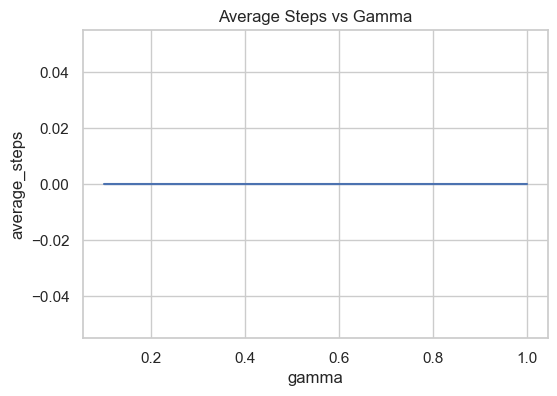

In [587]:
plot_performance(qlearning_data,qlearning_data['gamma'], 'average_steps', 'gamma', 'Average Steps vs Gamma')

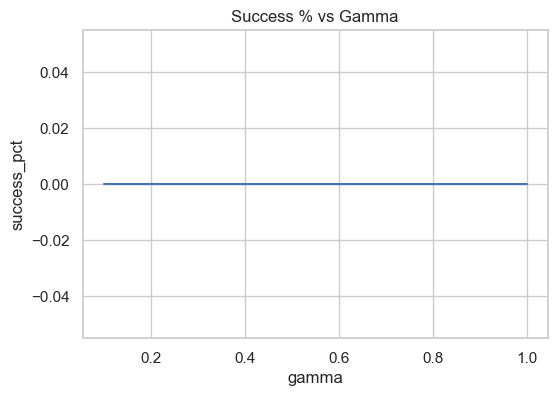

In [588]:
plot_performance(qlearning_data,qlearning_data['gamma'], 'success_pct', 'gamma', 'Success % vs Gamma')

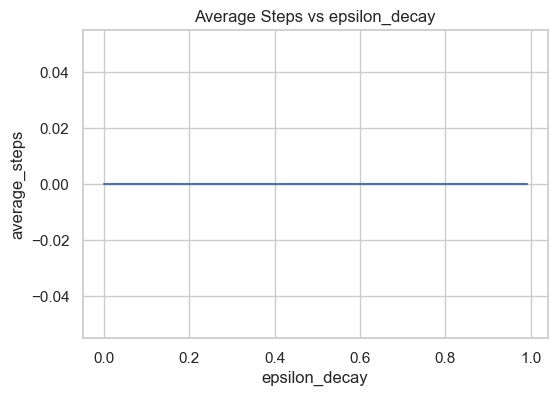

In [589]:
plot_performance(qlearning_data,qlearning_data['epsilon_decay'], 'average_steps', 'epsilon_decay', 'Average Steps vs epsilon_decay')

Best Result:
	Reward = 3923.61
	Gamma = 1.00,
	Alpha = 0.01,
	Alpha Decay: 0.900,
	Epsilon Decay: 0.990,
	Iterations: 1.0E+04


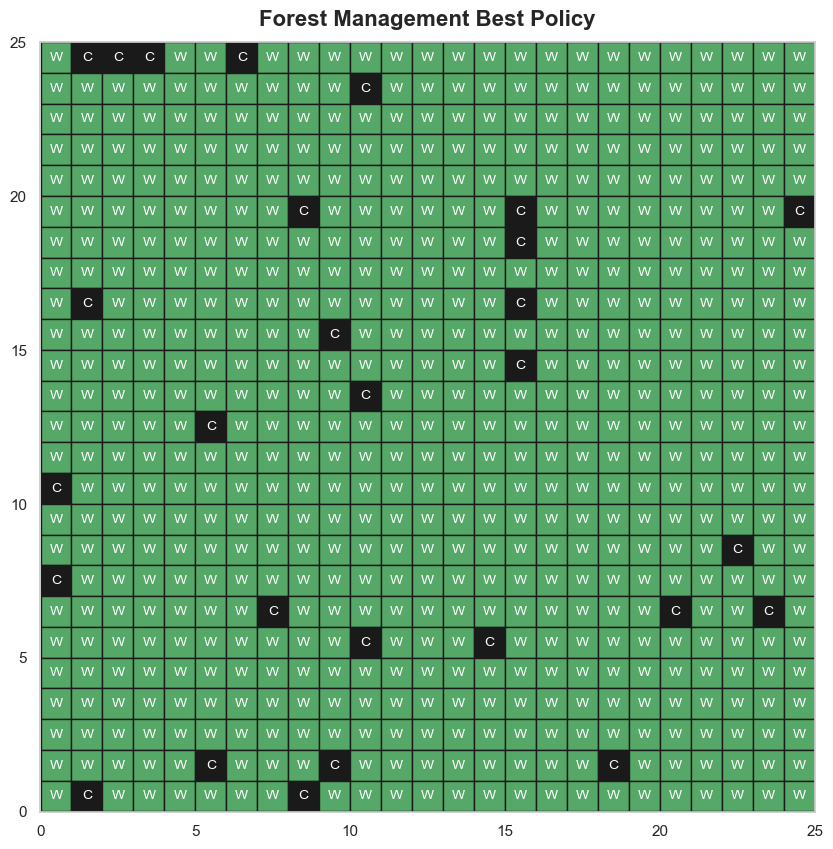

In [590]:
# find the highest score
plot_best_policy_forest(qlearning_data, 'Forest Management Best Policy')



best_run_index = qlearning_data['reward'].idxmax()
best_policy = qlearning_data['policy'][best_run_index]
print('Best Result:\n\tReward = %.2f\n\tGamma = %.2f,\n\tAlpha = %.2f,\n\tAlpha Decay: %.3f,\n\tEpsilon Decay: %.3f,\n\tIterations: %.1E'
% (qlearning_data['reward'].max(), qlearning_data['gamma'][best_run_index], qlearning_data['alpha'][best_run_index], qlearning_data['alpha_decay'][best_run_index], qlearning_data['epsilon_decay'][best_run_index], qlearning_data['iterations'][best_run_index]))